# Connect Forest Management Model with Forest Carbon Budget Model (without calibration)

Optionally, uninstall the ws3 package and replace it with a pointer to this local clone of the GitHub repository code (useful if you want ot tweak the source code for whatever reason).

## Set up Modelling Environment

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# Import ws3 Module from Local Server
import ws3
#Show Module Path
ws3.__path__

['/media/data/project/yyan/tmp/ws3/examples/ws3']

In [3]:
# Install libcbm Module from GitHub and Import it
install_libcbm = False
if install_libcbm:
    %pip install -U git+https://github.com/cat-cfs/libcbm_py.git@main
    import libcbm
    libcbm.__path__

## Create and Run `ForestModel` instance

In [4]:
# Install Pandas Library Version 2.0.3
%pip install pandas==2.0.3

Note: you may need to restart the kernel to use updated packages.


In [5]:
# Import Modules
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
import ws3.forest, ws3.core
import time
import math

In [6]:
#Start Calculating the Running Time
Start = time.time()

In [7]:
# Set Basic Parameters
base_year = 2020
horizon = 20
period_length = 10
max_age = 1000
tvy_name = 'totvol'

In [8]:
# Creat Forest Model Instance for Timber Supply Area 24
fm = ws3.forest.ForestModel(model_name='tsa24',
                            model_path='data/woodstock_model_files_tsa24',
                            base_year=base_year,
                            horizon=horizon,
                            period_length=period_length,
                            max_age=max_age)
fm.import_landscape_section()
fm.import_areas_section()
fm.import_yields_section()
fm.import_actions_section()
fm.import_transitions_section()
fm.initialize_areas()
fm.add_null_action()
fm.reset_actions()

fm.grow()

In [9]:
# Flag 'harvest' as a harvesting action in the ws3 model
harvest_acode='harvest'
fm.actions[harvest_acode].is_harvest = True

In [10]:
# Import Modules
from util import compile_scenario, plot_scenario

(<Figure size 1200x400 with 5 Axes>,
 array([<Axes: title={'center': 'Harvested area (ha)'}>,
        <Axes: title={'center': 'Harvested volume (m3)'}>,
        <Axes: title={'center': 'Growing Stock (m3)'}>,
        <Axes: title={'center': 'Ecosystem C stock (tons)'}>,
        <Axes: title={'center': 'Total Carbon Emission (tons)'}>],
       dtype=object))

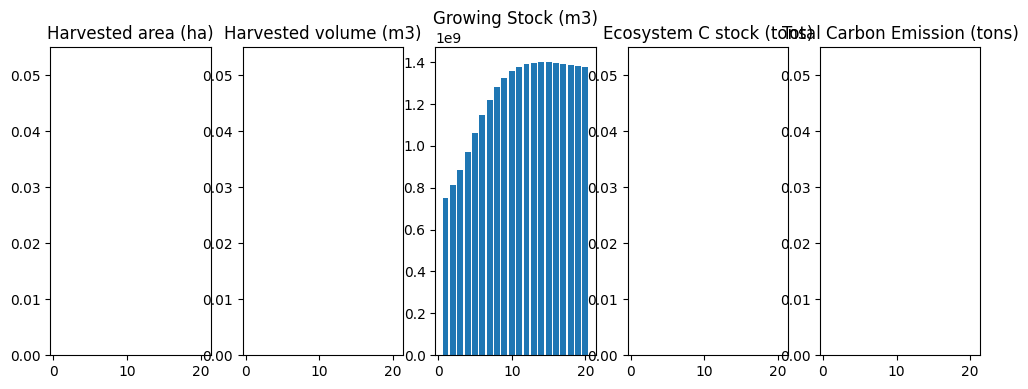

In [11]:
# Check the Forest Inventory of the Forest Model
df = compile_scenario(fm)
plot_scenario(df)

## Hard-link `ForestModel` to `libcbm`

In [12]:
# Import Modules
import libcbm
from util import run_cbm, cbm_report, plugin_c_curves

Prepare CBM input files

In [13]:
# Define Disturance Types
disturbance_type_mapping = [{'user_dist_type': 'harvest', 'default_dist_type': 'Clearcut harvesting without salvage'},
                            {'user_dist_type': 'fire', 'default_dist_type': 'Wildfire'}]
for dtype_key in fm.dtypes:
    fm.dt(dtype_key).last_pass_disturbance = 'fire' if dtype_key[2] == dtype_key[4] else 'harvest'

In [14]:
# Define Sit_config File
sit_config = {
                'mapping_config': {
                    'nonforest': None,
                    'species': {
                        'species_classifier': 'species',
                        'species_mapping': [
                            {'user_species': 'softwood', 'default_species': 'Softwood forest type'},
                            {'user_species': 'hardwood', 'default_species': 'Hardwood forest type'}
                        ]
                    },
                    'spatial_units': {
                        'mapping_mode': 'SingleDefaultSpatialUnit',
                        'admin_boundary': 'British Columbia',
                        'eco_boundary': 'Montane Cordillera'},
                    'disturbance_types': {
                        'disturbance_type_mapping': disturbance_type_mapping
                    }
                }
            }

In [15]:
# Define Sit Files
sit_classifiers = pd.read_csv('data/libcbm_model_files_tsa24/sit_classifiers.csv')
sit_disturbance_types = pd.read_csv('data/libcbm_model_files_tsa24/sit_disturbance_types.csv')
sit_age_classes = pd.read_csv('data/libcbm_model_files_tsa24/sit_age_classes.csv')
sit_inventory = pd.read_csv('data/libcbm_model_files_tsa24/sit_inventory.csv')
sit_yield = pd.read_csv('data/libcbm_model_files_tsa24/sit_yield.csv')
sit_events = pd.read_csv('data/libcbm_model_files_tsa24/sit_events.csv')
sit_transitions = pd.read_csv('data/libcbm_model_files_tsa24/sit_transitions.csv')

In [16]:
# Define Sit Tables
sit_tables = {'sit_classifiers': sit_classifiers,
              'sit_disturbance_types': sit_disturbance_types,
              'sit_age_classes': sit_age_classes,
              'sit_inventory': sit_inventory,
              'sit_yield': sit_yield,
              'sit_events': sit_events,
              'sit_transitions': sit_transitions}

Here are other two ways to generate sit tables. But they are only suitbale for small forest model since they take too much running time and memory

In [17]:
# Define Time Steps
n_steps = fm.horizon * fm.period_length

# Run CBM and Generate CBM 0utputs
cbm_output = run_cbm(sit_config, sit_tables, n_steps)

Emissions from all biomass components only resulting from fire disturbance, while these from all DOM pools resulting from annual decay processes and fire disturbance.

In [18]:
# Define Carbon Pools
biomass_pools = ['SoftwoodMerch','SoftwoodFoliage', 'SoftwoodOther', 'SoftwoodCoarseRoots','SoftwoodFineRoots',                        
                 'HardwoodMerch', 'HardwoodFoliage', 'HardwoodOther', 'HardwoodCoarseRoots', 'HardwoodFineRoots']
dom_pools = ['AboveGroundVeryFastSoil', 'BelowGroundVeryFastSoil', 'AboveGroundFastSoil', 'BelowGroundFastSoil',
             'MediumSoil', 'AboveGroundSlowSoil', 'BelowGroundSlowSoil', 'SoftwoodStemSnag', 'SoftwoodBranchSnag',
             'HardwoodStemSnag', 'HardwoodBranchSnag']
emissions_pools = ['CO2', 'CH4', 'CO', 'NO2']
products_pools = ['Products']
ecosystem_pools = biomass_pools + dom_pools
all_pools = biomass_pools + dom_pools + emissions_pools + products_pools

In [19]:
# Define Carbon Fluxes
annual_process_fluxes = [
    'DecayDOMCO2Emission',
    'DeltaBiomass_AG',
    'DeltaBiomass_BG',
    'TurnoverMerchLitterInput',
    'TurnoverFolLitterInput',
    'TurnoverOthLitterInput',
    'TurnoverCoarseLitterInput',
    'TurnoverFineLitterInput',
    'DecayVFastAGToAir',
    'DecayVFastBGToAir',
    'DecayFastAGToAir',
    'DecayFastBGToAir',
    'DecayMediumToAir',
    'DecaySlowAGToAir',
    'DecaySlowBGToAir',
    'DecaySWStemSnagToAir',
    'DecaySWBranchSnagToAir',
    'DecayHWStemSnagToAir',
    'DecayHWBranchSnagToAir'
]

npp_fluxes=[
    'DeltaBiomass_AG', 
    'DeltaBiomass_BG'
]
decay_emissions_fluxes = [
    'DecayVFastAGToAir',
    'DecayVFastBGToAir',
    'DecayFastAGToAir',
    'DecayFastBGToAir',
    'DecayMediumToAir',
    'DecaySlowAGToAir',
    'DecaySlowBGToAir',
    'DecaySWStemSnagToAir',
    'DecaySWBranchSnagToAir',
    'DecayHWStemSnagToAir',
    'DecayHWBranchSnagToAir'
]

disturbance_production_fluxes = [
    'DisturbanceSoftProduction',
    'DisturbanceHardProduction',
    'DisturbanceDOMProduction'   
]

disturbance_emissions_fluxes = [
    'DisturbanceMerchToAir',
    'DisturbanceFolToAir',
    'DisturbanceOthToAir',
    'DisturbanceCoarseToAir',
    'DisturbanceFineToAir',
    'DisturbanceVFastAGToAir',
    'DisturbanceVFastBGToAir',
    'DisturbanceFastAGToAir',
    'DisturbanceFastBGToAir',
    'DisturbanceMediumToAir',
    'DisturbanceSlowAGToAir',
    'DisturbanceSlowBGToAir',
    'DisturbanceSWStemSnagToAir',
    'DisturbanceSWBranchSnagToAir',
    'DisturbanceHWStemSnagToAir',
    'DisturbanceHWBranchSnagToAir'   
]

all_fluxes = [
    'DisturbanceCO2Production',
    'DisturbanceCH4Production',
    'DisturbanceCOProduction',
    'DisturbanceBioCO2Emission',
    'DisturbanceBioCH4Emission',
    'DisturbanceBioCOEmission',
    'DecayDOMCO2Emission',
    'DisturbanceSoftProduction',
    'DisturbanceHardProduction',
    'DisturbanceDOMProduction',
    'DeltaBiomass_AG',
    'DeltaBiomass_BG',
    'TurnoverMerchLitterInput',
    'TurnoverFolLitterInput',
    'TurnoverOthLitterInput',
    'TurnoverCoarseLitterInput',
    'TurnoverFineLitterInput',
    'DecayVFastAGToAir',
    'DecayVFastBGToAir',
    'DecayFastAGToAir',
    'DecayFastBGToAir',
    'DecayMediumToAir',
    'DecaySlowAGToAir',
    'DecaySlowBGToAir',
    'DecaySWStemSnagToAir',
    'DecaySWBranchSnagToAir',
    'DecayHWStemSnagToAir',
    'DecayHWBranchSnagToAir',
    'DisturbanceMerchToAir',
    'DisturbanceFolToAir',
    'DisturbanceOthToAir',
    'DisturbanceCoarseToAir',
    'DisturbanceFineToAir',
    'DisturbanceDOMCO2Emission',
    'DisturbanceDOMCH4Emission',
    'DisturbanceDOMCOEmission',
    'DisturbanceMerchLitterInput',
    'DisturbanceFolLitterInput',
    'DisturbanceOthLitterInput',
    'DisturbanceCoarseLitterInput',
    'DisturbanceFineLitterInput',
    'DisturbanceVFastAGToAir',
    'DisturbanceVFastBGToAir',
    'DisturbanceFastAGToAir',
    'DisturbanceFastBGToAir',
    'DisturbanceMediumToAir',
    'DisturbanceSlowAGToAir',
    'DisturbanceSlowBGToAir',
    'DisturbanceSWStemSnagToAir',
    'DisturbanceSWBranchSnagToAir',
    'DisturbanceHWStemSnagToAir',
    'DisturbanceHWBranchSnagToAir'
]

GrossGrowth_AG = flux[[
        "DeltaBiomass_AG",
        "TurnoverMerchLitterInput",
        "TurnoverFolLitterInput",
        "TurnoverOthLitterInput",
        ]].sum(axis=1)

GrossGrowth_BG = flux[[
        "DeltaBiomass_BG",
        "TurnoverCoarseLitterInput",
        "TurnoverFineLitterInput",
        ]].sum(axis=1)

In [20]:
# Define Sum Carbon Pools and Sum Carbon Fluxes
pools = ecosystem_pools
fluxes = decay_emissions_fluxes + disturbance_emissions_fluxes

sum_pools = ['ecosystem', 'biomass', 'DOM']

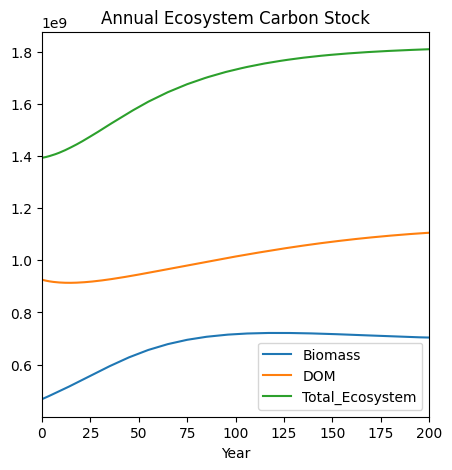

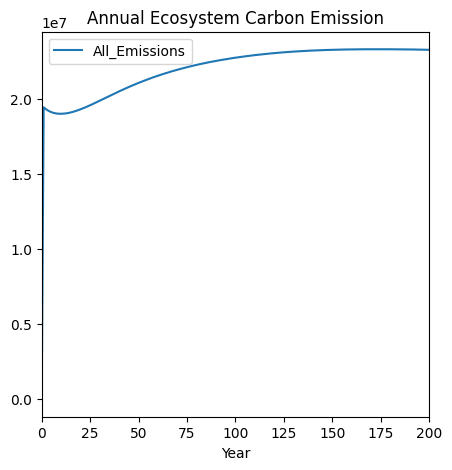

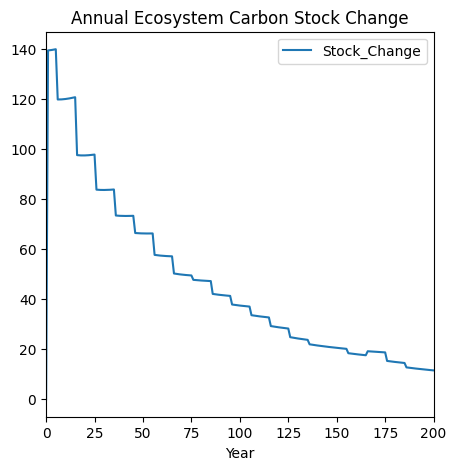

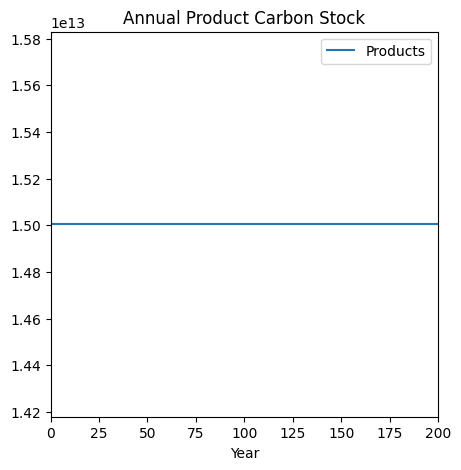

In [21]:
# Report Annual CBM Results
cbm_report(fm, cbm_output, biomass_pools, dom_pools, fluxes)

## Plug-in Carbon Yield Curves

In [23]:
# Read curves
c_curves_p = pd.read_pickle("curves/c_curves_p.pkl")
c_curves_f = pd.read_pickle("curves/c_curves_f.pkl") # Emission curves may be kind of broken

In [24]:
# Curvs Calibration
# c_curves_p = c_curves_p.iloc[:,-3:].apply(lambda x: x*1.03) # Calibrate the carbon yield curvest for total ecosystem pools
# c_curves_f = c_curves_f.iloc[:,-2:].apply(lambda x: x*1.03) # Calibrate the carbon yield curvest for net carbon flux

In [25]:
c_curves_p

SoftwoodMerch  SoftwoodFoliage  \
dtype_key                   timestep                                   
tsa24 0 2401000 100 2401000 0              0.000000         0.000000   
                            1              0.000100         0.142072   
                            2              0.000803         0.399931   
                            3              0.002724         0.575965   
                            4              0.006477         0.742157   
...                                             ...              ...   
tsa24 1 2403007 100 2423007 196          110.554996         9.315055   
                            197          110.630710         9.317758   
                            198          110.706420         9.320459   
                            199          110.782125         9.323159   
                            200          110.857825         9.325857   

                                      SoftwoodOther  SoftwoodCoarseRoots  \
dtype_key                   timestep                                       
tsa24 0 2401000 100 2401000 0              0.000000             0.000000   
                            1              0.000000             0.018159   
                            2              0.009712             0.052654   
                            3              0.182878             0.098251   
                            4              0.430046             0.153070   
...                                             ...                  ...   
tsa24 1 2403007 100 2423007 196           35.077570            31.728258   
                            197           35.089584            31.747243   
                            198           35.101597            31.766226   
                            199           35.113608            31.785206   
                            200           35.125619            31.804184   

                                      SoftwoodFineRoots  HardwoodMerch  \
dtype_key                   timestep                                     
tsa24 0 2401000 100 2401000 0                  0.000000            0.0   
                            1                  0.013403            0.0   
                            2                  0.038465            0.0   
                            3                  0.070817            0.0   
                            4                  0.108597            0.0   
...                                                 ...            ...   
tsa24 1 2403007 100 2423007 196                2.670114            0.0   
                            197                2.671205            0.0   
                            198                2.672296            0.0   
                            199                2.673388            0.0   
                            200                2.674481            0.0   

                                      HardwoodFoliage  HardwoodOther  \
dtype_key                   timestep                                   
tsa24 0 2401000 100 2401000 0                     0.0            0.0   
                            1                     0.0            0.0   
                            2                     0.0            0.0   
                            3                     0.0            0.0   
                            4                     0.0            0.0   
...                                               ...            ...   
tsa24 1 2403007 100 2423007 196                   0.0            0.0   
                            197                   0.0            0.0   
                            198                   0.0            0.0   
                            199                   0.0            0.0   
                            200                   0.0            0.0   

                                      HardwoodCoarseRoots  HardwoodFineRoots  \
dtype_key                   timestep                                           
tsa24 0 2401000 100 2401000 0                       

In [27]:
c_curves_f

DisturbanceCO2Production  \
dtype_key                   timestep                             
tsa24 0 2401000 100 2401000 0                              0.0   
                            1                              0.0   
                            2                              0.0   
                            3                              0.0   
                            4                              0.0   
...                                                        ...   
tsa24 1 2403007 100 2423007 196                            0.0   
                            197                            0.0   
                            198                            0.0   
                            199                            0.0   
                            200                            0.0   

                                      DisturbanceCH4Production  \
dtype_key                   timestep                             
tsa24 0 2401000 100 2401000 0                              0.0   
                            1                              0.0   
                            2                              0.0   
                            3                              0.0   
                            4                              0.0   
...                                                        ...   
tsa24 1 2403007 100 2423007 196                            0.0   
                            197                            0.0   
                            198                            0.0   
                            199                            0.0   
                            200                            0.0   

                                      DisturbanceCOProduction  \
dtype_key                   timestep                            
tsa24 0 2401000 100 2401000 0                             0.0   
                            1                             0.0   
                            2                             0.0   
                            3                             0.0   
                            4                             0.0   
...                                                       ...   
tsa24 1 2403007 100 2423007 196                           0.0   
                            197                           0.0   
                            198                           0.0   
                            199                           0.0   
                            200                           0.0   

                                      DisturbanceBioCO2Emission  \
dtype_key                   timestep                              
tsa24 0 2401000 100 2401000 0                               0.0   
                            1                               0.0   
                            2                               0.0   
                            3                               0.0   
                            4                               0.0   
...                                                         ...   
tsa24 1 2403007 100 2423007 196                             0.0   
                            197                             0.0   
                            198                             0.0   
                            199                             0.0   
                            200                             0.0   

                                      DisturbanceBioCH4Emission  \
dtype_key                   timestep                              
tsa24 0 2401000 100 2401000 0                               0.0   
                            1                               0.0   
                            2                               0.0   
                            3                               0.0   
                            4                               0.0   
...                                                         ...   
tsa24 1 2403007 100 2423007 196                             0.0   

In [28]:
# Plug carbon yield curves into forest model
plugin_c_curves(fm, c_curves_p, c_curves_f, pools=sum_pools, fluxes=['net_fluxes', 'total_emissions'])

found match for mask ('?', '?', '2401000', '?', '2401000')
found match for mask ('?', '?', '2401000', '?', '2401000')
found match for mask ('?', '?', '2401001', '?', '2401001')
found match for mask ('?', '?', '2401001', '?', '2401001')
found match for mask ('?', '?', '2401003', '?', '2401003')
found match for mask ('?', '?', '2401003', '?', '2401003')
found match for mask ('?', '?', '2401004', '?', '2401004')
found match for mask ('?', '?', '2401004', '?', '2401004')
found match for mask ('?', '?', '2401005', '?', '2401005')
found match for mask ('?', '?', '2401005', '?', '2401005')
found match for mask ('?', '?', '2401006', '?', '2401006')
found match for mask ('?', '?', '2401006', '?', '2401006')
found match for mask ('?', '?', '2402001', '?', '2402001')
found match for mask ('?', '?', '2402001', '?', '2402001')
found match for mask ('?', '?', '2402005', '?', '2402005')
found match for mask ('?', '?', '2402005', '?', '2402005')
found match for mask ('?', '?', '2402006', '?', '2402006

In [54]:
# Check if all carbon yield curves are plugged in well.
# fm.yields

(<Figure size 1200x400 with 5 Axes>,
 array([<Axes: title={'center': 'Harvested area (ha)'}>,
        <Axes: title={'center': 'Harvested volume (m3)'}>,
        <Axes: title={'center': 'Growing Stock (m3)'}>,
        <Axes: title={'center': 'Ecosystem C stock (tons)'}>,
        <Axes: title={'center': 'Total Carbon Emission (tons)'}>],
       dtype=object))

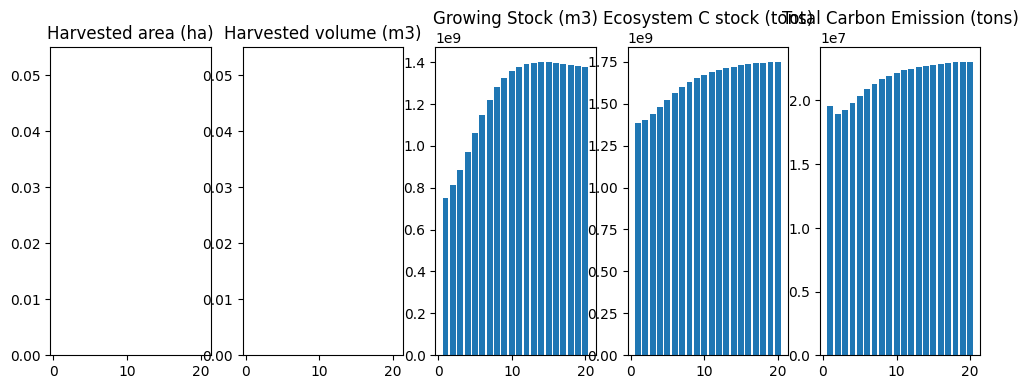

In [29]:
# Check the Forest Inventory of the ws3 Model without harvesting
df = compile_scenario(fm)
plot_scenario(df)

## Implement Optimization-based Action Scheduling

In [30]:
#Install Module
%pip install gurobipy

Note: you may need to restart the kernel to use updated packages.


In [31]:
#Import Module
import gurobipy as grb

Add a "null" action to the model for the optimization functions to work correctly.

In [32]:
#Add a Null Action
fm.add_null_action()

Define base and other scenarios below. You can change you objective functions and constraints by modifying the scenarios directly.

In [33]:
def cmp_c_z(fm, path, expr):
    """
    Compile objective function coefficient (given ForestModel instance, 
    leaf-to-root-node path, and expression to evaluate).
    """
    result = 0.
    for t, n in enumerate(path, start=1):
        d = n.data()
        if fm.is_harvest(d['acode']):
            result += fm.compile_product(t, expr, d['acode'], [d['dtk']], d['age'], coeff=False)
            # print('t')
            # print(result)
    return result

def cmp_c_cflw(fm, path, expr, mask=None): # product, all harvest actions
    """
    Compile flow constraint coefficient for product indicator (given ForestModel 
    instance, leaf-to-root-node path, expression to evaluate, and optional mask).
    """
    result = {}
    for t, n in enumerate(path, start=1):
        d = n.data()
        if mask and not fm.match_mask(mask, d['dtk']): continue
        if fm.is_harvest(d['acode']):
            result[t] = fm.compile_product(t, expr, d['acode'], [d['dtk']], d['age'], coeff=False)
    return result


def cmp_c_caa(fm, path, expr, acodes, mask=None): # product, named actions
    """
    Compile constraint coefficient for product indicator (given ForestModel 
    instance, leaf-to-root-node path, expression to evaluate, list of action codes, 
    and optional mask).
    """
    result = {}
    for t, n in enumerate(path, start=1):
        d = n.data()
        if mask and not fm.match_mask(mask, d['dtk']): continue
        if d['acode'] in acodes:
            result[t] = fm.compile_product(t, expr, d['acode'], [d['dtk']], d['age'], coeff=False)
    return result


def cmp_c_ci(fm, path, yname, mask=None): # product, named actions
    """
    Compile constraint coefficient for inventory indicator (given ForestModel instance, 
    leaf-to-root-node path, expression to evaluate, and optional mask).
    """
    result = {}
    for t, n in enumerate(path, start=1):
        d = n.data()
        if mask and not fm.match_mask(mask, d['_dtk']): continue
        result[t] = fm.inventory(t, yname=yname, age=d['_age'], dtype_keys=[d['_dtk']]) 
        #result[t] = fm.inventory(t, yname=yname, age=d['age'], dtype_keys=[d['dtk']]) 
    return result

In [34]:
def cmp_c_i(fm, path, yname, mask=None): # product, named actions
    """
    Compile objective function coefficient for inventory indicators (given ForestModel instance, 
    leaf-to-root-node path, and expression to evaluate).
    """
    result = 0.
    for t, n in enumerate(path, start=1):
        d = n.data()
        if mask and not fm.match_mask(mask, d['_dtk']): continue
        result = fm.inventory(t, yname=yname, age=d['_age'], dtype_keys=[d['_dtk']])
        #result[t] = fm.inventory(t, yname=yname, age=d['age'], dtype_keys=[d['dtk']])
    return result

In [172]:
#Define constants from product carbon estimation

# Define the product half-lives（>0.69)
half_life_solid_wood = 100
half_life_paper = 2

# Define the allocation distribution
proportion_solid_wood = 1

# Define the displacement factor 
displacement_factor = 5

In [173]:
def cmp_c_ss(fm, path, expr, yname, half_life_solid_wood=half_life_solid_wood, half_life_paper=half_life_paper, proportion_solid_wood=proportion_solid_wood, mask=None):
    """
    Compile objective function coefficient for total system carbon stock indicators (given ForestModel instance, 
    leaf-to-root-node path, and expression to evaluate).
    """
    result = 0.
    
    # Calculate decay rates based on half-lives
    k_solid_wood = math.log(2) / half_life_solid_wood  # Decay rate for solid wood products (30-year half-life)
    k_paper = math.log(2) / half_life_paper  # Decay rate for paper (2-year half-life)
    
    # Define the allocation distribution
    proportion_paper = 1 - proportion_solid_wood
    
    # wood density (Kennedy, 1965)
    wood_density = 460

    # carbon content
    carbon_content = 0.5
    
    # k_solid_wood = 0 # Decay rate for solid wood products (0-year half-life)
    # k_paper = 0 # Decay rate for paper (0-year half-life)
    
    product_stock_dict = {}  # Dictionary to track product stock for each node across iterations
    
    for t, n in enumerate(path, start=1):

        d = n.data()
        node_id = id(n)  # or another unique identifier specific to your application
        
        # Track the ecosystem carbon stock
        if mask and not fm.match_mask(mask, d['_dtk']): continue
        result = fm.inventory(t, yname, age=d['_age'], dtype_keys=[d['_dtk']])
        
        # Retrieve the last tuple of stocks from the dictionary
        last_stocks = next(reversed(product_stock_dict.values()), (0, 0))
        old_product_stock_solid_wood, old_product_stock_paper = last_stocks
        
        if fm.is_harvest(d['acode']):
            # Calculate new product stock assuming 50% goes into solid wood and 50% into paper
            new_product_mass = fm.compile_product(t, expr, d['acode'], [d['dtk']], d['age'], coeff=False)
            new_product_stock_solid_wood = new_product_mass * proportion_solid_wood * wood_density * carbon_content / 1000 # Convert kg to ton
            new_product_stock_paper = new_product_mass * proportion_paper * wood_density * carbon_content / 1000 # Convert kg to ton

            # Apply decay to old stocks and add new stocks
            sum_product_stock_solid_wood = old_product_stock_solid_wood * (1 - k_solid_wood) + new_product_stock_solid_wood * (1 - k_solid_wood)
            sum_product_stock_paper = old_product_stock_paper * (1 - k_paper) + new_product_stock_paper * (1 - k_paper)

            # Update product_stock_dict with the new sum product stocks for this node
            product_stock_dict[node_id] = (sum_product_stock_solid_wood, sum_product_stock_paper)
            
            sum_product_stock = sum_product_stock_solid_wood + sum_product_stock_paper
            result += sum_product_stock
        
        else:
            # If not harvesting, simply apply decay to the old product stocks
            sum_product_stock_solid_wood = old_product_stock_solid_wood * (1 - k_solid_wood)
            sum_product_stock_paper = old_product_stock_paper * (1 - k_paper)
            product_stock_dict[node_id] = (sum_product_stock_solid_wood, sum_product_stock_paper)

            sum_product_stock = sum_product_stock_solid_wood + sum_product_stock_paper
            result += sum_product_stock
        
        # print(t)
        # print(product_stock_dict)

    return result

In [174]:
def cmp_c_se(fm, path, expr, yname, half_life_solid_wood=half_life_solid_wood, half_life_paper=half_life_paper, proportion_solid_wood=proportion_solid_wood, displacement_factor=displacement_factor, mask=None):
    """
    Compile objective function coefficient for net system carbon emission indicators (given ForestModel instance, 
    leaf-to-root-node path, and expression to evaluate).
    """
    result = 0.
    
   # Calculate decay rates based on half-lives
    k_solid_wood = math.log(2) / half_life_solid_wood  # Decay rate for solid wood products (30-year half-life)
    k_paper = math.log(2) / half_life_paper  # Decay rate for paper (2-year half-life)
    
    # Define the allocation distribution
    proportion_paper = 1 - proportion_solid_wood
    
    # wood density (Kennedy, 1965)
    wood_density = 460 #kg/m^3

    # carbon content
    carbon_content = 0.5
    
    product_stock_dict = {}  # Dictionary to track product stock for each node across iterations

    for t, n in enumerate(path, start=1):

        d = n.data()
        node_id = id(n)  # or another unique identifier specific to your application
        
        # Track the ecosystem carbon stock change (net emission from the forest ecosystem)
        if mask and not fm.match_mask(mask, d['_dtk']): continue
        if t==1:
            result = 0.
        else:
            result += (fm.inventory(t-1, yname, age=d['_age'], dtype_keys=[d['_dtk']])-fm.inventory(t, yname, age=d['_age'], dtype_keys=[d['_dtk']]))
        
        # Retrieve the last tuple of stocks from the dictionary
        last_stocks = next(reversed(product_stock_dict.values()), (0, 0))
        old_product_stock_solid_wood, old_product_stock_paper = last_stocks
        
        if fm.is_harvest(d['acode']):
            # Calculate new product stock assuming 50% goes into solid wood and 50% into paper
            new_product_mass = fm.compile_product(t, expr, d['acode'], [d['dtk']], d['age'], coeff=False)
            new_product_stock_solid_wood = new_product_mass * proportion_solid_wood * wood_density * carbon_content / 1000 # Convert kg to ton
            new_product_stock_paper = new_product_mass * proportion_paper * wood_density * carbon_content / 1000 # Convert kg to ton

            # Apply decay to old stocks and add new stocks
            sum_product_stock_solid_wood = old_product_stock_solid_wood * (1 - k_solid_wood) + new_product_stock_solid_wood * (1 - k_solid_wood)
            sum_product_stock_paper = old_product_stock_paper * (1 - k_paper) + new_product_stock_paper * (1 - k_paper)
            
            sum_product_emission_solid_wood = old_product_stock_solid_wood * k_solid_wood + new_product_stock_solid_wood * k_solid_wood
            sum_product_emission_paper = old_product_stock_paper * k_paper + new_product_stock_paper * k_paper

            # Update product_stock_dict with the new sum product stocks for this node
            product_stock_dict[node_id] = (sum_product_stock_solid_wood, sum_product_stock_paper)
            
            sum_product_emission = (sum_product_emission_solid_wood + sum_product_emission_paper)*44/12 # Convert C to CO2
            result += sum_product_emission
            result -= new_product_stock_solid_wood*displacement_factor*44/12 # Substracting substition benefits of HWPs
        
        else:
            # If not harvesting, simply apply decay to the old product stocks
            sum_product_stock_solid_wood = old_product_stock_solid_wood * (1 - k_solid_wood)
            sum_product_stock_paper = old_product_stock_paper * (1 - k_paper)
            
            sum_product_emission_solid_wood = old_product_stock_solid_wood * k_solid_wood
            sum_product_emission_paper = old_product_stock_paper * k_paper

            # Update product_stock_dict with the new sum product stocks for this node
            product_stock_dict[node_id] = (sum_product_stock_solid_wood, sum_product_stock_paper)

            sum_product_emission = (sum_product_emission_solid_wood + sum_product_emission_paper)*44/12
            result += sum_product_emission

    return result

In [175]:
# Build the function to track and report total system carbon stock

In [176]:
def track_system_stock(fm, half_life_solid_wood=half_life_solid_wood, half_life_paper=half_life_paper, proportion_solid_wood=proportion_solid_wood):
    product_stock_dict = {}

    solid_wood_stock_list = []
    paper_stock_list = []
    product_stock_list = []
    ecosystem_stock_list = []
    system_stock_list = []

    # Calculate decay rates based on half-lives
    k_solid_wood = math.log(2) / half_life_solid_wood
    k_paper = math.log(2) / half_life_paper

    # Define the allocation distribution
    proportion_paper = 1-proportion_solid_wood

    # Constants
    wood_density = 460 #(Kennedy, 1965)
    carbon_content = 0.5

    for period in fm.periods:
        # Get old product stocks
        last_stocks = next(reversed(product_stock_dict.values()), (0, 0))
        old_product_stock_solid_wood, old_product_stock_paper = last_stocks

        # Calculate new product stocks
        new_product_biomass = fm.compile_product(period, 'totvol * 0.85', acode='harvest')
        new_product_stock_solid_wood = new_product_biomass * proportion_solid_wood * wood_density * carbon_content / 1000 #convert the unit from kg to ton
        new_product_stock_paper = new_product_biomass * proportion_paper * wood_density * carbon_content / 1000 #convert the unit from kg to ton

        # Apply decay to all stocks within the same period they're produced
        sum_product_stock_solid_wood = (old_product_stock_solid_wood + new_product_stock_solid_wood) * (1 - k_solid_wood)
        sum_product_stock_paper = (old_product_stock_paper + new_product_stock_paper) * (1 - k_paper)

        # Update product_stock_dict for this period
        product_stock_dict[period] = (sum_product_stock_solid_wood, sum_product_stock_paper)

        # Calculate total system carbon stock
        sum_product_stock = sum_product_stock_solid_wood + sum_product_stock_paper
        ecosystem_stock = fm.inventory(period, 'ecosystem')
        total_system_stock = ecosystem_stock + sum_product_stock

        # Update stock lists for this period
        solid_wood_stock_list.append(sum_product_stock_solid_wood)
        paper_stock_list.append(sum_product_stock_paper)
        product_stock_list.append(sum_product_stock)
        ecosystem_stock_list.append(ecosystem_stock)
        system_stock_list.append(total_system_stock)

    # Prepare data for plotting
    data = {
        'period': fm.periods,
        'solid_wood': solid_wood_stock_list,
        'paper': paper_stock_list,
        'sum_product': product_stock_list,
        'ecosystem': ecosystem_stock_list,
        'system': system_stock_list
    }

    df = pd.DataFrame(data)

    # Plotting
    fig, ax = plt.subplots(1, 5, figsize=(20, 4))  # Adjusted for 5 subplots
    ax[0].bar(df.period, df.solid_wood)
    ax[0].set_title('Solid Wood Product C Stock')
    ax[1].bar(df.period, df.paper)
    ax[1].set_title('Paper Product C Stock')
    ax[2].bar(df.period, df.sum_product)
    ax[2].set_title('Total Product C Stock')
    ax[3].bar(df.period, df.ecosystem)
    ax[3].set_title('Ecosystem C Stock')
    ax[4].bar(df.period, df.system)
    ax[4].set_title('Total System C Stock')

    for a in ax:
        a.set_ylim(None, None)
        a.set_xlabel('Period')
        a.set_ylabel('Stock (tons)')

    plt.tight_layout()
    return fig, ax, df

In [177]:
def track_system_emission(fm, half_life_solid_wood=half_life_solid_wood, half_life_paper=half_life_paper, proportion_solid_wood=proportion_solid_wood, displacement_factor=displacement_factor):
    product_stock_dict = {}

    solid_wood_emission_list = []
    paper_emission_list = []
    product_emission_list = []
    ecosystem_emission_list = []
    system_emission_list = []

    # Calculate decay rates based on half-lives
    k_solid_wood = math.log(2) / half_life_solid_wood
    k_paper = math.log(2) / half_life_paper

    # Define the allocation distribution
    proportion_paper = 1-proportion_solid_wood

    # Constants
    wood_density = 460 #(Kennedy, 1965)
    carbon_content = 0.5
    
    for period in fm.periods:
        # Get old product emissions
        last_stocks = next(reversed(product_stock_dict.values()), (0, 0))
        old_product_stock_solid_wood, old_product_stock_paper = last_stocks

        # Calculate new product emissions
        new_product_biomass = fm.compile_product(period, 'totvol * 0.85', acode='harvest')
        new_product_stock_solid_wood = new_product_biomass * proportion_solid_wood * wood_density * carbon_content / 1000 #convert the unit from kg to ton
        new_product_stock_paper = new_product_biomass * proportion_paper * wood_density * carbon_content / 1000 #convert the unit from kg to ton

        # Apply decay to all emissions within the same period they're produced
        sum_product_stock_solid_wood = (old_product_stock_solid_wood + new_product_stock_solid_wood) * (1 - k_solid_wood)
        sum_product_stock_paper = (old_product_stock_paper + new_product_stock_paper) * (1 - k_paper)

        sum_product_emission_solid_wood = (old_product_stock_solid_wood + new_product_stock_solid_wood) * k_solid_wood * 44 / 12 # Convert C to CO2
        sum_product_emission_paper = (old_product_stock_paper + new_product_stock_paper) * k_paper * 44 / 12 # Convert C to CO2
        
        # Update product_emission_dict for this period
        product_stock_dict[period] = (sum_product_stock_solid_wood, sum_product_stock_paper)

        # Calculate total system carbon emission
        sum_product_emission = sum_product_emission_solid_wood + sum_product_emission_paper
        ecosystem_emission = fm.inventory(period-1, 'ecosystem') - fm.inventory(period, 'ecosystem') * 44 /12 if period > 1 else 0
        total_system_emission = ecosystem_emission + sum_product_emission - new_product_stock_solid_wood * displacement_factor *44 / 12 # Substracting substition benefits of HWPsr

        # Update stock lists for this period
        solid_wood_emission_list.append(sum_product_emission_solid_wood)
        paper_emission_list.append(sum_product_emission_paper)
        product_emission_list.append(sum_product_emission)
        ecosystem_emission_list.append(ecosystem_emission)
        system_emission_list.append(total_system_emission)

    # Prepare data for plotting
    data = {
        'period': fm.periods,
        'solid_wood': solid_wood_emission_list,
        'paper': paper_emission_list,
        'sum_product': product_emission_list,
        'ecosystem': ecosystem_emission_list,
        'system': system_emission_list
    }

    df = pd.DataFrame(data)

    # Plotting
    fig, ax = plt.subplots(1, 5, figsize=(20, 4))  # Adjusted for 5 subplots
    ax[0].bar(df.period, df.solid_wood)
    ax[0].set_title('Solid Wood Product CO2 Emission')
    ax[1].bar(df.period, df.paper)
    ax[1].set_title('Paper Product CO2 Emission')
    ax[2].bar(df.period, df.sum_product)
    ax[2].set_title('Total Product CO2 Emission')
    ax[3].bar(df.period, df.ecosystem)
    ax[3].set_title('Ecosystem CO2 Emission')
    ax[4].bar(df.period, df.system)
    ax[4].set_title('Total System CO2 Emission')

    for a in ax:
        a.set_ylim(None, None)
        a.set_xlabel('Period')
        a.set_ylabel('Emission (tons)')

    plt.tight_layout()
    return fig, ax, df

Define a generic base scenario function, and link it to a dispatch function keyed on scenario name string (e.g., `base`). 

Note how we use `functools.partial` to specialize the more general functions defined above for use in the `coeff_funcs` arg of `ForestModel.add_problem`. Otherwise we would have to define an entirely new function each time we defined a slightly different objective or constraint in one of our scenarios, which would get tedious and messy. The tedium and mess would be more evident if we had a large number of alternative scenarios defined in the same notebook (which we do not here, but use your imagination). 

Note also that the expected data structures for the various args to `ForestModel.add_problem` must be matched exactly or `ws3` will likely crash somewhere in one of the series of complicated private optimization model-building methods that get called from `ForestModel.add_problem`. You _should not_ have to unpack the exact logic of this model-building code to figure out why your model is crashing... it really is quite complicated and hard to follow. If you model is crashing there, you probably fed invalid (or incorrectly structured) args to `ForestModel.add_problem`. Carefully review the structure and values of your args to find the problem. I left some notes below (and some comments in the `_gen_scen_base` function code) to help clarify the expected arg structure, and will work on expanding the docstrings in the `ws3` source code so this is less obscure going forward.

I also had to patch the `ws3` code in two places so that it would "grow" correctly with the model set up to use _years_ as the age unit. For some reason the latest `dev` branch of `ws3` on GitHub was in some sort of intermediate state between using _periods_ and _years_ as the age unit. Originally `ws3` was implemented to import and simulate legacy Woodstock model input datasets, so it used _periods_ as the age unit (like Woodstock). At some point I think I hastily patched `ws3` to use _years_ as the age unit to make it work with `spades_ws3` for specific projects that needed to get done and delivered... if I recall we set the period length to 1 year for all those projects so it "just worked", but now we have a bit of a mess. Oops. Ultimately, I will need to revert `ws3` back to using Woodstock-compatible _period_ age unit (but make sure that the `spatial` module can still spatially and temporally disaggregate the aspatial periodic solutions from the Model I LP optimization problems into year-length time slices (maybe with age optionally expressed in years in output from this, for compatibility with downstream linked models like `SpaDES`). This is just a side-effect of many iterations of re-purposing `ws3` to work in a long (ad hoc) sequence of real research projects that had very specific input and output data specs. It is actually remarkable that `ws3` is not _more_ of a mess than it currently is, given the history and essentially null development budget. Use

`ForestModel.add_problem` arg specs are described below.

`name`: String. Used as key to store `Problem` instances in a dict in the `ForestModel` instanace, so make sure it is unique within a given model or you will overwrite dict values (assuming you want to stuff multiple problems, and their solutions, into your model at the same time). 
    
`coeff_funcs`: Dict of function references, keyed on _row name_ strings. These are the functions that generate the LP optimization problem matrix coefficients (for the objective function and constraint rows). This one gets complicated, and is a likely source of bugs. Make sure the row name key strings are all unique or you will make a mess. You can name the constraint rows anything you want, but the objective function row has to be named `z`. All coefficient functions must accept exactly two args, in this order: a `ws3.forest.ForestModel` instance and a `ws3.common.Path` instance. The `z` coefficient function is special in that it must return a single float value. All other (i.e., constraint) coefficient functions just return a dict of floats, keyed on period ints (can be sparse, i.e., not necessary to include key:value pairs in output dict if value is 0.0). It is useful (but not necessary) to use `functools.partial` to specialize a smaller number of more general function definitions (with more args, that get "locked down" and hidden by `partial`) as we have done in the example in this notebook.

`cflw_e`: Dict of `(dict, int)` tuples, keyed on _row name_ strings (must match _row name_ key values used to define coefficient functions for flow constraints in `coeff_func` dict), where the int:float dict embedded in the tuple defines epsilon values keyed on periods (must include all periods, even if epsilon value is always the same). See example below. 

```
{
  'cflw_acut':({1:0.01, 2:0.01, ..., 10:0.01}, 1),
  'cflw_vcut':({1:0.05, 2:0.05, ..., 10:0.05}, 1)
}
```

`cgen_data`: Dict of dict of dicts. The outer-level dict is keyed on _row name_ strings (must match row names used in `coeff_funcs`. The middle second level of dicts always has keys `'lb'` and `'ub'`, and the inner level of dicts specifies lower- and upper-bound general constraint RHS (float) values, keyed on period (int).

`acodes`: List of strings. Action codes to be included in optimization problem formulation (actions must defined in the `ForestModel` instance, but can be only a subset).

`sense`: Must be one of `ws3.opt.SENSE_MAXIMIZE` or `ws3.opt.SENSE_MINIMIZE`.

`mask`: Tuple of strings constituting a valid mask for your `ForestModel` instance. Can be `None` if you do not want to filter `DevelopmentType` instances.

In [178]:
##### Define Gen_scenario Function
def gen_scenario(fm, name='base', util=0.85, harvest_acode='harvest',
                 cflw_ha={}, cflw_hv={}, 
                 cgen_ha={}, cgen_hv={}, 
                 cgen_gs={}, tvy_name='totvol', cp_name='ecosystem', cf_name='total_emissions', obj_mode='min_hv', mask=None):
    
    from functools import partial
    import numpy as np
    coeff_funcs = {}
    cflw_e = {}
    cgen_data = {}
    acodes = ['null', harvest_acode] # define list of action codes
    vexpr = '%s * %0.2f' % (tvy_name, util) # define volume expression
    
    if obj_mode == 'max_hv': # maximize harvest volume
        sense = ws3.opt.SENSE_MAXIMIZE 
        zexpr = vexpr
    elif obj_mode == 'min_hv': # maximize harvest volume
        sense = ws3.opt.SENSE_MINIMIZE 
        zexpr = vexpr
    else:
        raise ValueError('Invalid obj_mode: %s' % obj_mode)
        
    # coeff_funcs['z'] = partial(cmp_c_i, yname=cf_name) # define objective function coefficient function for inventory data
    # coeff_funcs['z'] = partial(cmp_c_z, expr=vexpr) # define objective function coefficient function for havrest volume
    # coeff_funcs['z'] = partial(cmp_c_ss, expr=vexpr, yname=cp_name) # define objective function coefficient function for total system carbon stock
    coeff_funcs['z'] = partial(cmp_c_se, expr=vexpr, yname=cp_name) # define objective function coefficient function for net system carbonemission
    T = fm.periods
    if cflw_ha: # define even flow constraint (on harvest area)
        cname = 'cflw_ha'
        coeff_funcs[cname] = partial(cmp_c_caa, expr='1.', acodes=[harvest_acode], mask=None) 
        cflw_e[cname] = cflw_ha
    if cflw_hv: # define even flow constraint (on harvest volume)
        cname = 'cflw_hv'
        coeff_funcs[cname] = partial(cmp_c_caa, expr=vexpr, acodes=[harvest_acode], mask=None) 
        # cflw_e[cname] = cflw_hv         
    if cgen_ha: # define general constraint (harvest area)
        cname = 'cgen_ha'
        coeff_funcs[cname] = partial(cmp_c_caa, expr='1.', acodes=[harvest_acode], mask=None) 
        cgen_data[cname] = cgen_ha
    if cgen_hv: # define general constraint (harvest volume)
        cname = 'cgen_hv'
        coeff_funcs[cname] = partial(cmp_c_caa, expr=vexpr, acodes=[harvest_acode], mask=None) 
        cgen_data[cname] = cgen_hv
    if cgen_gs: # define general constraint (growing stock)
        cname = 'cgen_gs'
        coeff_funcs[cname] = partial(cmp_c_ci, yname=tvy_name, mask=None)
        cgen_data[cname] = cgen_gs
    # if cgen_cp: # define general constraint (carbon pools)
    #     cname = 'cgen_cp'
    #     coeff_funcs[cname] = partial(cmp_c_ci, yname=cp_name, mask=None)
    #     cgen_data[cname] = cgen_cp
    # if cgen_cf: # define general constraint (carbon fluxes)
    #     cname = 'cgen_cf'
    #     coeff_funcs[cname] = partial(cmp_c_ci, yname=cf_name, mask=None)
    #     cgen_data[cname] = cgen_cf
    return fm.add_problem(name, coeff_funcs, cflw_e, cgen_data=cgen_data, acodes=acodes, sense=sense, mask=mask)

In [179]:
# Define Run_scenario Function
def run_scenario(fm, scenario_name='base'):
    cflw_ha = {}
    cflw_hv = {}
    cgen_ha = {}
    cgen_hv = {}
    cgen_gs = {}
    # cgen_cp = {}
    # cgen_cf = {}
    
    # define harvest area and harvest volume even-flow constraints
    cflw_ha = ({p:0.05 for p in fm.periods}, 1)
    cflw_hv = ({p:0.05 for p in fm.periods}, 1)
    
    in_gs = 750290200. #initial growing stock volume
    in_cp = 1412181000. #initial total ecosystem carbon stock
    # in_cf = 580000000 #intial total ecosystem carbon emission
    AAC = 7031963. # AAC of TSA24

    if scenario_name == 'base': 
        # Base scenario
        print('running base scenario')
        # cgen_gs = {'lb':{10:in_gs*0.9}, 'ub':{10:in_gs*2}} #Not less than 90% of initial growing stock
        # cgen_hv = {'lb':{x:AAC*0.5 for x in fm.periods}, 'ub':{x:AAC*1000 for x in fm.periods}} #Achieve the Annual Allowable Cu
        # cgen_hv = {'lb':{10:in_gs*10}, 'ub':{10:in_gs*10+1}}
    elif scenario_name == 'base_h': 
        # Base scenario
        print('running maxmizie harvest scenario')
        cgen_gs = {'lb':{10:in_gs*0.9}, 'ub':{10:in_gs*2}} #Not less than 90% of initial growing stock
        cgen_hv = {'lb':{1:AAC-1}, 'ub':{10:AAC}} #Achieve the Annual Allowable Cut
    elif scenario_name == 'base_c': 
        # Cabron indicators constraints
        print('running base scenario with even-flow constraints')
        cgen_gs = {'lb':{10:in_gs*0.9}, 'ub':{10:in_gs*2}} #Not less than 90% of initial growing stock
        cgen_hv = {'lb':{1:AAC*0.5}, 'ub':{1:AAC*2}}  #Not less than 10% of annual allowable cut
        # cgen_cf = {'lb':{10:in_cf}, 'ub':{10:in_cf*1.1}} #Not more than 110% of initial total ecosystem carbon stock
    elif scenario_name == 'reduce_10%_AAC': 
        # Reduce 10% of harvest volume from base scenario
        print('running base scenario reduced 10% of AAC')
        cgen_gs = {'lb':{10:in_gs*0.9}, 'ub':{10:in_gs*0.9+1}}#Not less than 90% of initial growing stock
        cgen_hv = {'lb':{1:AAC*0.9-1}, 'ub':{1:AAC*0.9}}    
    elif scenario_name == 'reduce_20%_AAC': 
        # Reduce 20% of harvest volume from base scenario
        print('running base scenario reduced 20% of AAC')
        cgen_gs = {'lb':{10:in_gs*0.9}, 'ub':{10:in_gs*0.9+1}} #Not less than 90% of initial growing stock
        cgen_hv = {'lb':{1:AAC*0.8-1}, 'ub':{1:AAC*0.8}}   
    elif scenario_name == 'increase_10%_AAC': 
        # Increase 10% of harvest volume from base scenario
        print('running base scenario increased 10% of AAC')
        cgen_gs = {'lb':{10:in_gs*0.9}, 'ub':{10:in_gs*0.9+1}} #Not less than 90% of initial growing stock
        cgen_hv = {'lb':{1:AAC*1.1-1}, 'ub':{1:AAC*1.1}}
    elif scenario_name == 'increase_20%_AAC': 
        # Increase 20% of harvest volume from base scenario
        print('running base scenario increased 20% of AAC')
        cgen_gs = {'lb':{10:in_gs*0.9}, 'ub':{10:in_gs*0.9+1}} #Not less than 90% of initial growing stock
        cgen_hv = {'lb':{1:AAC*1.2-1}, 'ub':{1:AAC*1.2}}   
    else:
        assert False # bad scenario name
      
    # p = gen_scenario(fm=fm, 
    #                  name=scenario_name, 
    #                  cflw_ha=cflw_ha, 
    #                  cflw_hv=cflw_hv,
    #                  cgen_ha=cgen_ha,
    #                  cgen_hv=cgen_hv,
    #                  cgen_gs=cgen_gs)
    
    p = gen_scenario(fm=fm, 
                     name=scenario_name, 
                     cflw_ha=cflw_ha, 
                     cflw_hv=cflw_hv,
                     cgen_ha=cgen_ha,
                     cgen_hv=cgen_hv,
                     cgen_gs=cgen_gs,)

    # fm.reset()
    m = p.solve()

    if m.status != grb.GRB.OPTIMAL:
        print('Model not optimal.')
        # sys.exit()
        
    sch = fm.compile_schedule(p)
    fm.apply_schedule(sch, 
                      force_integral_area=False, 
                      override_operability=False,
                      fuzzy_age=False,
                      recourse_enabled=False,
                      verbose=False,
                      compile_c_ycomps=True)
    
    from util import compile_scenario, plot_scenario
    df = compile_scenario(fm)
    fig, ax = plot_scenario(df)
    # cbm_results = cbm_hardlink(fm,disturbance_type_mapping)
    
    return fig, df, p

# Run Optimization Scenarios

(<Figure size 2000x400 with 5 Axes>,
 array([<Axes: title={'center': 'Solid Wood Product C Stock'}, xlabel='Period', ylabel='Stock (tons)'>,
        <Axes: title={'center': 'Paper Product C Stock'}, xlabel='Period', ylabel='Stock (tons)'>,
        <Axes: title={'center': 'Total Product C Stock'}, xlabel='Period', ylabel='Stock (tons)'>,
        <Axes: title={'center': 'Ecosystem C Stock'}, xlabel='Period', ylabel='Stock (tons)'>,
        <Axes: title={'center': 'Total System C Stock'}, xlabel='Period', ylabel='Stock (tons)'>],
       dtype=object),
     period  solid_wood  paper  sum_product     ecosystem        system
 0        1         0.0    0.0          0.0  1.381789e+09  1.381789e+09
 1        2         0.0    0.0          0.0  1.402196e+09  1.402196e+09
 2        3         0.0    0.0          0.0  1.436742e+09  1.436742e+09
 3        4         0.0    0.0          0.0  1.478353e+09  1.478353e+09
 4        5         0.0    0.0          0.0  1.521575e+09  1.521575e+09
 5        6  

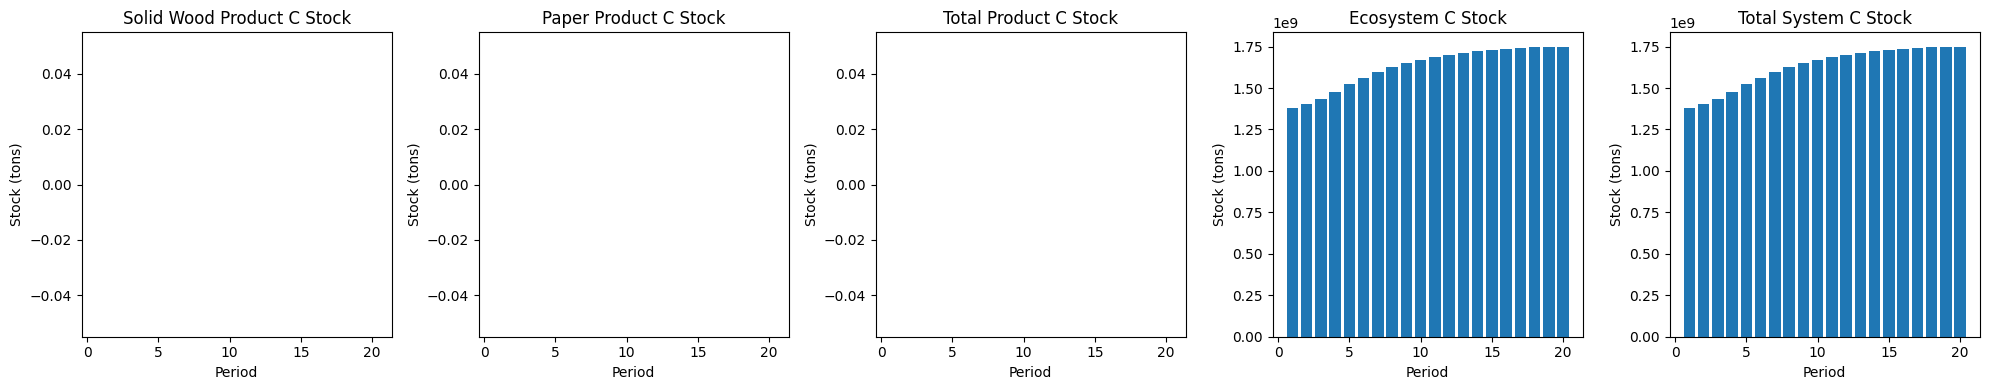

In [254]:
track_system_stock(fm)

(<Figure size 2000x400 with 5 Axes>,
 array([<Axes: title={'center': 'Solid Wood Product CO2 Emission'}, xlabel='Period', ylabel='Emission (tons)'>,
        <Axes: title={'center': 'Paper Product CO2 Emission'}, xlabel='Period', ylabel='Emission (tons)'>,
        <Axes: title={'center': 'Total Product CO2 Emission'}, xlabel='Period', ylabel='Emission (tons)'>,
        <Axes: title={'center': 'Ecosystem CO2 Emission'}, xlabel='Period', ylabel='Emission (tons)'>,
        <Axes: title={'center': 'Total System CO2 Emission'}, xlabel='Period', ylabel='Emission (tons)'>],
       dtype=object),
     period  solid_wood  paper  sum_product     ecosystem        system
 0        1         0.0    0.0          0.0  0.000000e+00  0.000000e+00
 1        2         0.0    0.0          0.0 -3.759598e+09 -3.759598e+09
 2        3         0.0    0.0          0.0 -3.865857e+09 -3.865857e+09
 3        4         0.0    0.0          0.0 -3.983884e+09 -3.983884e+09
 4        5         0.0    0.0          0.0 -

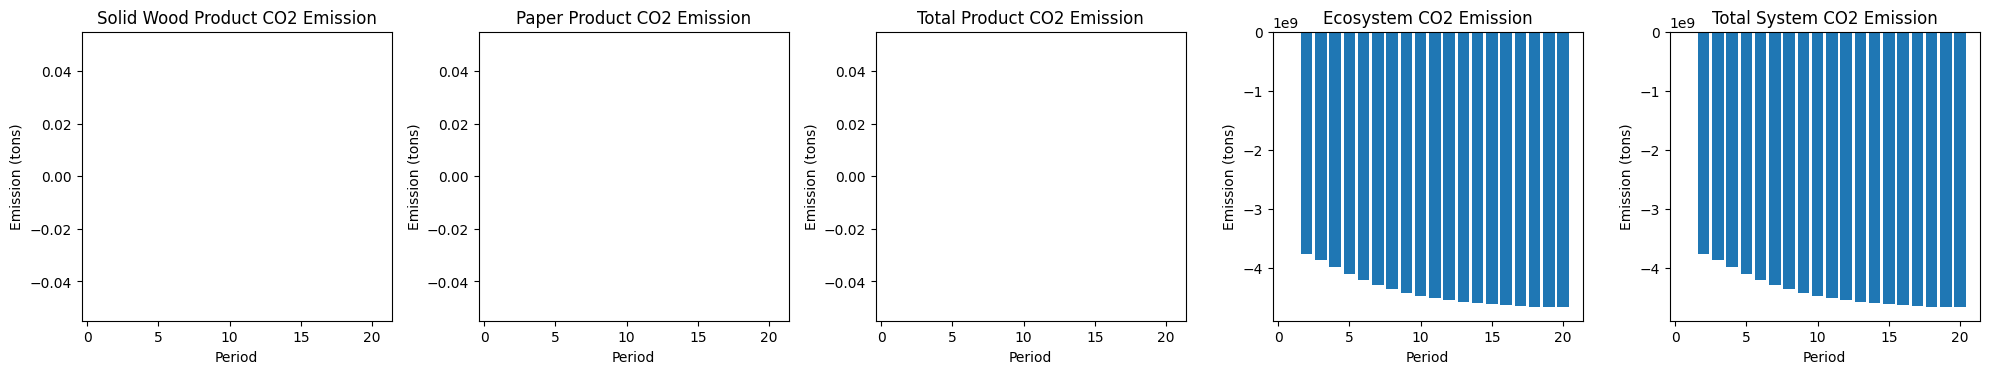

In [255]:
track_system_emission(fm)

## Maximize the Timber Supply

running base scenario
Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-22
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (linux64)

CPU model: Intel Xeon Processor (Skylake, IBRS), instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 16 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 770 rows, 45499 columns and 45499 nonzeros
Model fingerprint: 0x878d485e
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [9e+02, 9e+07]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+00]
Presolve removed 770 rows and 45499 columns
Presolve time: 0.06s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.8788281e+09   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.08 seconds (0.02 work units)
Optimal objective  1.878828085e+09
foo


(<Figure size 1200x400 with 5 Axes>,
     period        oha           ohv           ogs           ocp           ocf
 0        1  1466474.7  2.976293e+08  3.992527e+08  1.305103e+09  1.442216e+07
 1        2   297394.0  4.951365e+07  3.928198e+08  1.232426e+09  1.771104e+07
 2        3   302810.7  4.569043e+07  4.003617e+08  1.203642e+09  1.561386e+07
 3        4   186302.3  2.817519e+07  4.390145e+08  1.201248e+09  1.530304e+07
 4        5   217516.5  3.022491e+07  4.856161e+08  1.216623e+09  1.519505e+07
 5        6    36221.9  7.142696e+06  5.752078e+08  1.247937e+09  1.610442e+07
 6        7     3974.1  9.273657e+05  6.825711e+08  1.292129e+09  1.675748e+07
 7        8   235412.2  6.027709e+07  7.225186e+08  1.332605e+09  1.670133e+07
 8        9   607874.2  1.571847e+08  6.407064e+08  1.344629e+09  1.621990e+07
 9       10  1031999.5  2.267181e+08  4.606076e+08  1.323336e+09  1.540925e+07
 10      11   225493.7  5.026229e+07  4.566035e+08  1.272139e+09  1.794705e+07
 11      12    

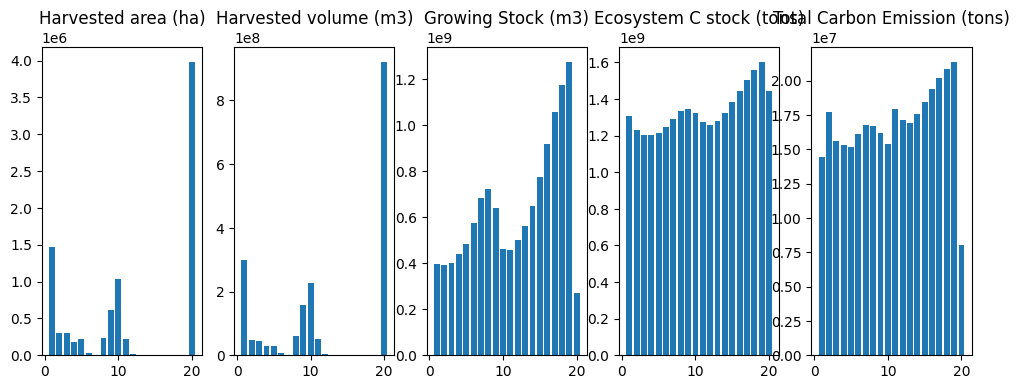

In [44]:
# Without Even-flow Constraints
run_scenario(fm,'base')

running base scenario
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (linux64)

CPU model: Intel Xeon Processor (Skylake, IBRS), instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 16 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 810 rows, 45499 columns and 486195 nonzeros
Model fingerprint: 0xee882251
Coefficient statistics:
  Matrix range     [2e-01, 1e+05]
  Objective range  [9e+02, 9e+07]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+00]
Presolve removed 332 rows and 770 columns
Presolve time: 0.29s
Presolved: 478 rows, 44729 columns, 470383 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 1.669e+04
 Factor NZ  : 2.218e+04 (roughly 20 MB of memory)
 Factor Ops : 1.107e+06 (less than 1 second per iteration)
 Threads    : 14

Barrier performed 0 iterations in 0.76 seconds (0.16 work units)
Barrier solve interrupte

(<Figure size 1200x400 with 5 Axes>,
     period            oha           ohv           ogs           ocp  \
 0        1  412253.413793  1.025216e+08  6.287911e+08  1.355339e+09   
 1        2  432866.084483  8.887756e+07  5.867429e+08  1.324769e+09   
 2        3  391640.743103  7.819234e+07  5.669255e+08  1.306844e+09   
 3        4  391640.743103  7.097351e+07  5.643531e+08  1.293075e+09   
 4        5  391640.743103  6.611549e+07  5.742219e+08  1.285775e+09   
 5        6  391640.743103  7.605989e+07  5.767078e+08  1.281941e+09   
 6        7  391640.743103  9.577248e+07  5.535385e+08  1.280826e+09   
 7        8  391640.743103  9.403526e+07  5.216345e+08  1.273323e+09   
 8        9  391640.743103  8.728113e+07  4.856715e+08  1.261944e+09   
 9       10  391640.743103  8.712928e+07  4.410250e+08  1.252823e+09   
 10      11  391640.743103  7.068775e+07  4.145930e+08  1.243525e+09   
 11      12  391640.743103  3.644006e+07  4.435076e+08  1.252427e+09   
 12      13  391640.743103 

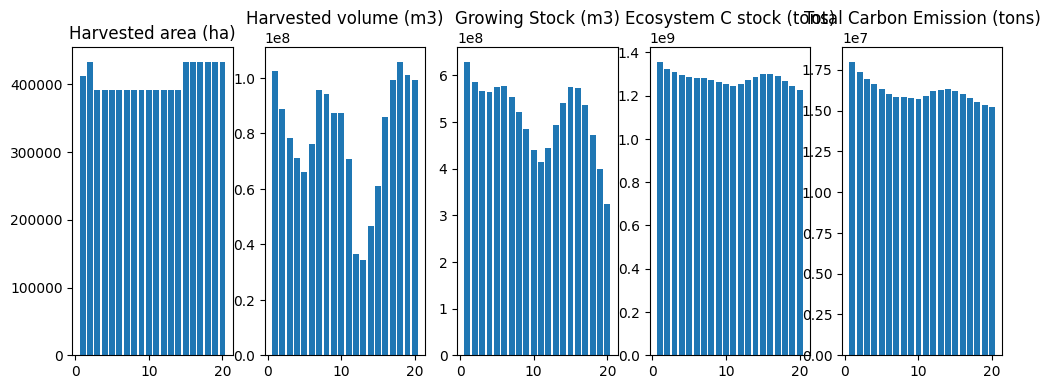

In [46]:
# With Even-flow Constraints
run_scenario(fm,'base')

In [47]:
sch = fm.compile_schedule()

In [48]:
def sch_to_df(sch):
     # Transforming data to fit the dataframe columns
    transformed_data = [(dtk[0], dtk[1], dtk[2], dtk[3], dtk[4], age, area, acode, period, etype) for dtk, age, area, acode, period, etype in sch]
    
    # Creating DataFrame
    df_sch = pd.DataFrame(transformed_data, columns=['theme0', 'theme1', 'theme2', 'theme3', 'theme4', 'age', 'area', 'acode', 'period', 'etype'])
    
    return df_sch
    
#     # Check if dtk2 equals dtk4 and select non-equal ones
#     non_equal_dtk2_dtk4 = df[df['dtk2'] != df['dtk4']]
    
#     return non_equal_dtk2_dtk4

In [51]:
df_sch = sch_to_df(sch)
df_sch

theme0 theme1   theme2 theme3   theme4  age     area    acode  period  \
0    tsa24      1  2401007    100  2401007  195    196.9  harvest       1   
1    tsa24      1  2401007    100  2401007  205   1403.2  harvest       1   
2    tsa24      1  2401007    100  2401007  215    175.0  harvest       1   
3    tsa24      1  2401007    100  2401007  225    508.3  harvest       1   
4    tsa24      1  2401007    100  2401007  235    209.6  harvest       1   
..     ...    ...      ...    ...      ...  ...      ...      ...     ...   
556  tsa24      1  2403003    304  2423003  100  51498.2  harvest      20   
557  tsa24      1  2403003    304  2423003  110   8011.4  harvest      20   
558  tsa24      1  2403007    100  2423007   90  21112.0  harvest      20   
559  tsa24      1  2403007    100  2423007  100   7881.5  harvest      20   
560  tsa24      1  2403007    100  2423007   80   6871.6  harvest      20   

         etype  
0    _existing  
1    _existing  
2    _existing  
3    _existing  
4    _existing  
..         ...  
556  _existing  
557  _existing  
558  _existing  
559  _existing  
560  _existing  

[561 rows x 10 columns]

In [59]:
matching_rows = df_sch[df_sch['theme2'].values == df_sch['theme4'].values]

In [60]:
matching_rows

theme0 theme1   theme2 theme3   theme4  age         area    acode  period  \
0    tsa24      1  2401007    100  2401007  195    196.90000  harvest       1   
1    tsa24      1  2401007    100  2401007  205   1403.20000  harvest       1   
2    tsa24      1  2401007    100  2401007  215    175.00000  harvest       1   
3    tsa24      1  2401007    100  2401007  225    508.30000  harvest       1   
4    tsa24      1  2401007    100  2401007  235    209.60000  harvest       1   
..     ...    ...      ...    ...      ...  ...          ...      ...     ...   
430  tsa24      1  2402004    104  2402004  215   2390.70000  harvest      11   
435  tsa24      1  2403001    304  2403001  165   7084.30000  harvest      11   
436  tsa24      1  2403001    304  2403001  175  11605.90000  harvest      11   
437  tsa24      1  2403001    304  2403001  185  20447.30000  harvest      11   
438  tsa24      1  2403001    304  2403001  195  17995.77069  harvest      11   

         etype  
0    _existing  
1    _existing  
2    _existing  
3    _existing  
4    _existing  
..         ...  
430  _existing  
435  _existing  
436  _existing  
437  _existing  
438  _existing  

[368 rows x 10 columns]

In [52]:
ratios = df_sch.groupby('period').apply(
    lambda x: (x['theme2'] == x['theme4']).sum() / len(x)
).reset_index(name='ratio')

print(ratios)

    period     ratio
0        1  1.000000
1        2  1.000000
2        3  0.928571
3        4  0.947368
4        5  1.000000
5        6  0.906977
6        7  0.055556
7        8  0.000000
8        9  0.266667
9       10  0.111111
10      11  0.323529
11      12  0.000000
12      13  0.000000
13      14  0.000000
14      15  0.000000
15      16  0.000000
16      17  0.000000
17      18  0.000000
18      19  0.000000
19      20  0.000000


## Maximize the Total Ecosystem Carbon Stock

running base scenario
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (linux64)

CPU model: Intel Xeon Processor (Skylake, IBRS), instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 16 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 770 rows, 45499 columns and 45499 nonzeros
Model fingerprint: 0xd640f249
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [5e+00, 6e+05]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+00]
Presolve removed 770 rows and 45499 columns
Presolve time: 0.04s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    2.3377196e+07   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.07 seconds (0.02 work units)
Optimal objective  2.337719571e+07
foo


(<Figure size 1200x400 with 5 Axes>,
     period        oha           ohv           ogs           ocp           ocf
 0        1  2312520.6  4.033453e+08  2.748809e+08  1.282753e+09  1.189598e+07
 1        2    84680.5  1.288202e+07  2.998184e+08  1.176176e+09  1.829242e+07
 2        3    53942.4  9.319606e+06  3.416223e+08  1.147708e+09  1.510261e+07
 3        4        0.0  0.000000e+00  4.080884e+08  1.157815e+09  1.457629e+07
 4        5        0.0  0.000000e+00  4.883555e+08  1.196573e+09  1.496520e+07
 5        6        0.0  0.000000e+00  5.882979e+08  1.249195e+09  1.595136e+07
 6        7        0.0  0.000000e+00  7.046801e+08  1.308184e+09  1.711957e+07
 7        8        0.0  0.000000e+00  8.307440e+08  1.369742e+09  1.823640e+07
 8        9        0.0  0.000000e+00  9.546062e+08  1.428060e+09  1.918325e+07
 9       10        0.0  0.000000e+00  1.068358e+09  1.481108e+09  1.995214e+07
 10      11        0.0  0.000000e+00  1.169587e+09  1.529128e+09  2.057406e+07
 11      12    

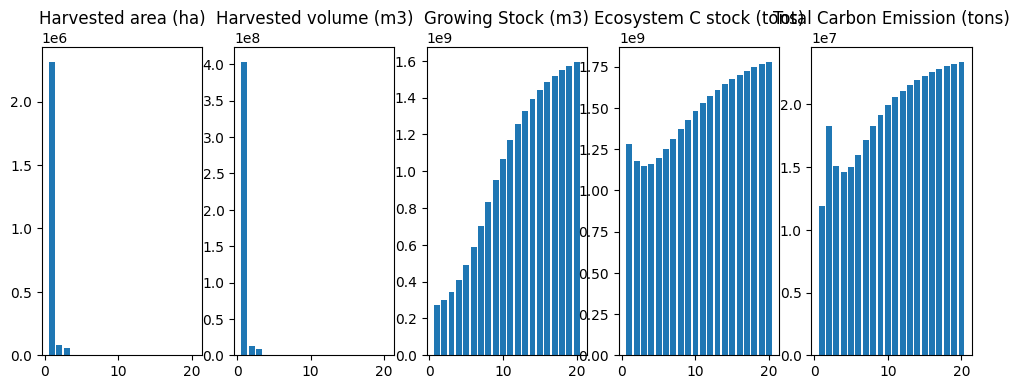

In [63]:
# Without Even-flow Constraints
# Simulation Horizon - 20 Years
run_scenario(fm,'base')

In [65]:
sch = fm.compile_schedule()

In [66]:
df_sch = sch_to_df(sch)

In [67]:
df_sch

theme0 theme1   theme2 theme3   theme4  age     area    acode  period  \
0    tsa24      1  2401002    204  2401002   85  65921.6  harvest       1   
1    tsa24      1  2401002    204  2401002   95  64774.1  harvest       1   
2    tsa24      1  2401002    204  2401002  105  26896.5  harvest       1   
3    tsa24      1  2401002    204  2401002  115  18851.4  harvest       1   
4    tsa24      1  2401002    204  2401002  125  28349.1  harvest       1   
..     ...    ...      ...    ...      ...  ...      ...      ...     ...   
341  tsa24      1  2403000    100  2403000   85  18263.5  harvest       3   
342  tsa24      1  2403002    204  2403002   85   2007.3  harvest       3   
343  tsa24      1  2403003    304  2403003   85  16868.7  harvest       3   
344  tsa24      1  2403004    104  2403004   85   1245.6  harvest       3   
345  tsa24      1  2403007    100  2403007   85   2656.8  harvest       3   

         etype  
0    _existing  
1    _existing  
2    _existing  
3    _existing  
4    _existing  
..         ...  
341  _existing  
342  _existing  
343  _existing  
344  _existing  
345  _existing  

[346 rows x 10 columns]

In [69]:
def plot_histograms(df, period=1):
    # Filter the DataFrame for period 1
    df_period = df[df['period'] == period].copy()  # Use .copy() to avoid SettingWithCopyWarning
    
    # Total Area by dtk4 for Period 1
    area_by_dtk4 = df_period.groupby('theme4')['area'].sum().reset_index()
    plt.figure(figsize=(10, 5))
    plt.bar(area_by_dtk4['theme4'], area_by_dtk4['area'], color='skyblue')
    plt.title(f'Total Area by theme4 in Period {period}')
    plt.xlabel('theme4')
    plt.ylabel('Total Area')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    
    # Total Area by Age Classes for Period 1
    classes = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200, 210, 220, 230, 240, 250, 260, 270, 280, 290, 300, 310, 320, 330, 340, 350, 360, 370, 380, 390, 400]
    labels = [f'{i}-{i+10}' for i in range(0, 400, 10)]
    df_period['age_class'] = pd.cut(df_period['age'], bins=classes, labels=labels, right=False)
    area_by_age_class = df_period.groupby('age_class')['area'].sum().reset_index()
    
    plt.figure(figsize=(10, 5))
    plt.bar(area_by_age_class['age_class'], area_by_age_class['area'], color='orange')
    plt.title(f'Total Area by theme4 in Period {period}')
    plt.xlabel('Age Class')
    plt.ylabel('Total Area')
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()

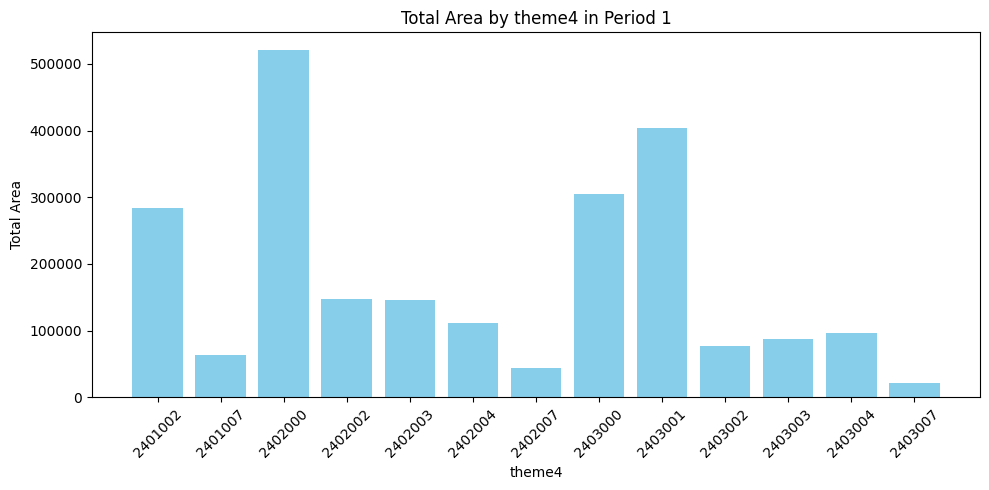

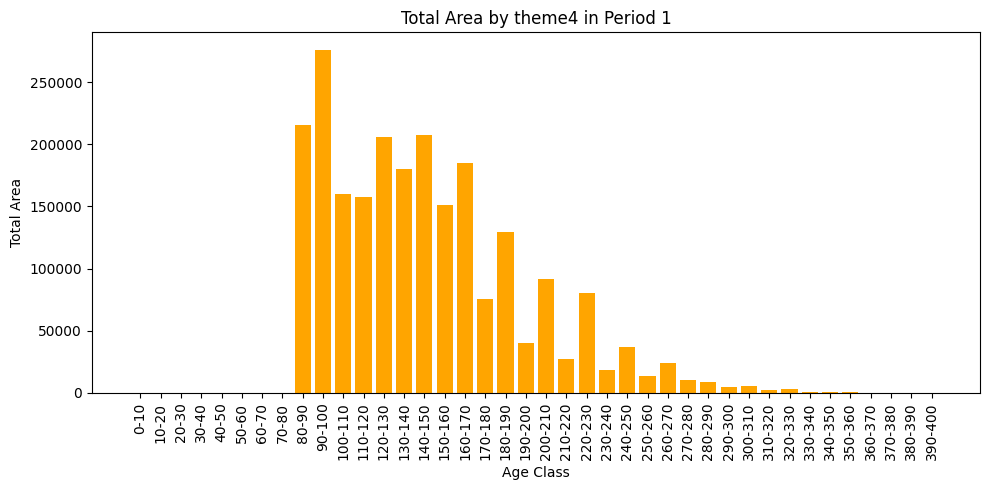

In [70]:
plot_histograms(df_sch)

running base scenario
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (linux64)

CPU model: Intel Xeon Processor (Skylake, IBRS), instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 16 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 810 rows, 45499 columns and 486195 nonzeros
Model fingerprint: 0x6e105ad7
Coefficient statistics:
  Matrix range     [2e-01, 1e+05]
  Objective range  [5e+00, 6e+05]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+00]
Presolve removed 332 rows and 330 columns
Presolve time: 0.36s
Presolved: 478 rows, 45169 columns, 470823 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 1.669e+04
 Factor NZ  : 2.218e+04 (roughly 20 MB of memory)
 Factor Ops : 1.107e+06 (less than 1 second per iteration)
 Threads    : 14

Barrier performed 0 iterations in 0.72 seconds (0.16 work units)
Barrier solve interrupte

(<Figure size 1200x400 with 5 Axes>,
     period  oha  ohv           ogs           ocp           ocf
 0        1  0.0  0.0  7.494048e+08  1.381789e+09  1.954011e+07
 1        2  0.0  0.0  8.124675e+08  1.402196e+09  1.894992e+07
 2        3  0.0  0.0  8.861458e+08  1.436742e+09  1.921555e+07
 3        4  0.0  0.0  9.707337e+08  1.478353e+09  1.975706e+07
 4        5  0.0  0.0  1.060630e+09  1.521575e+09  2.033804e+07
 5        6  0.0  0.0  1.146251e+09  1.561899e+09  2.085700e+07
 6        7  0.0  0.0  1.219698e+09  1.597082e+09  2.128955e+07
 7        8  0.0  0.0  1.278276e+09  1.626686e+09  2.164259e+07
 8        9  0.0  0.0  1.322490e+09  1.651037e+09  2.192896e+07
 9       10  0.0  0.0  1.354309e+09  1.670935e+09  2.216033e+07
 10      11  0.0  0.0  1.376027e+09  1.687321e+09  2.234828e+07
 11      12  0.0  0.0  1.389710e+09  1.700760e+09  2.250060e+07
 12      13  0.0  0.0  1.397148e+09  1.711820e+09  2.262491e+07
 13      14  0.0  0.0  1.399821e+09  1.721052e+09  2.272777e+07
 14

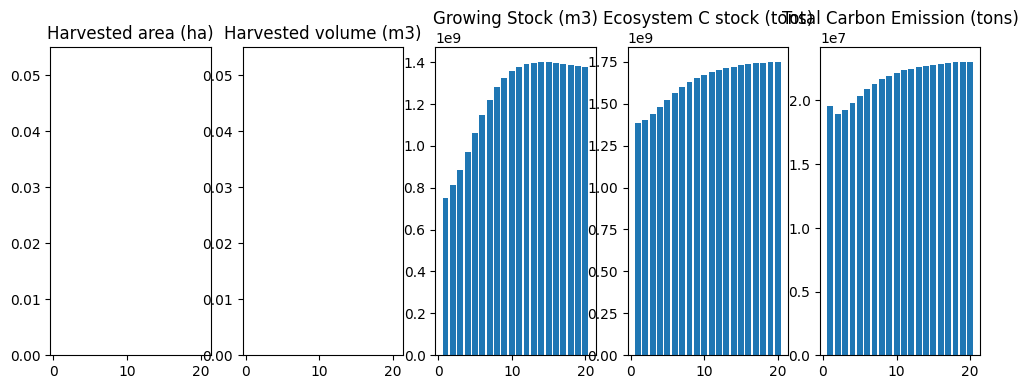

In [73]:
# With Even-flow Constraints
# Simulation Horizon - 20 Years
run_scenario(fm,'base')

running base scenario
Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-22
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (linux64)

CPU model: Intel Xeon Processor (Skylake, IBRS), instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 16 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 830 rows, 367968 columns and 5631132 nonzeros
Model fingerprint: 0x9f386777
Coefficient statistics:
  Matrix range     [2e-01, 1e+05]
  Objective range  [5e+00, 6e+05]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+00]
Presolve removed 332 rows and 330 columns
Presolve time: 3.69s
Presolved: 498 rows, 367638 columns, 5510466 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 2.644e+04
 Factor NZ  : 3.278e+04 (roughly 150 MB of memory)
 Factor Ops : 2.335e+06 (less than 1 second per iteration)
 Threads   

(<Figure size 1200x400 with 5 Axes>,
     period          oha            ohv           ogs           ocp  \
 0        1  1974.962457  604293.829795  7.486938e+08  1.391233e+09   
 1        2  2073.710580  626571.699693  8.109858e+08  1.413469e+09   
 2        3  2073.710580  655867.861485  8.838416e+08  1.449948e+09   
 3        4  2073.710580  677944.848532  9.675810e+08  1.493691e+09   
 4        5  2073.710580  595777.049693  1.056791e+09  1.539231e+09   
 5        6  2073.710580  661808.247927  1.141767e+09  1.582103e+09   
 6        7  2073.710580  686553.730341  1.214728e+09  1.619979e+09   
 7        8  2073.710580  678955.815179  1.272987e+09  1.652346e+09   
 8        9  2073.710580  660136.455742  1.317084e+09  1.679367e+09   
 9       10  2073.710580  689197.711331  1.348902e+09  1.701592e+09   
 10      11  2073.710580  703656.834471  1.370729e+09  1.719763e+09   
 11      12  2073.710580  674764.486937  1.384659e+09  1.734558e+09   
 12      13  2073.710580  602999.376544 

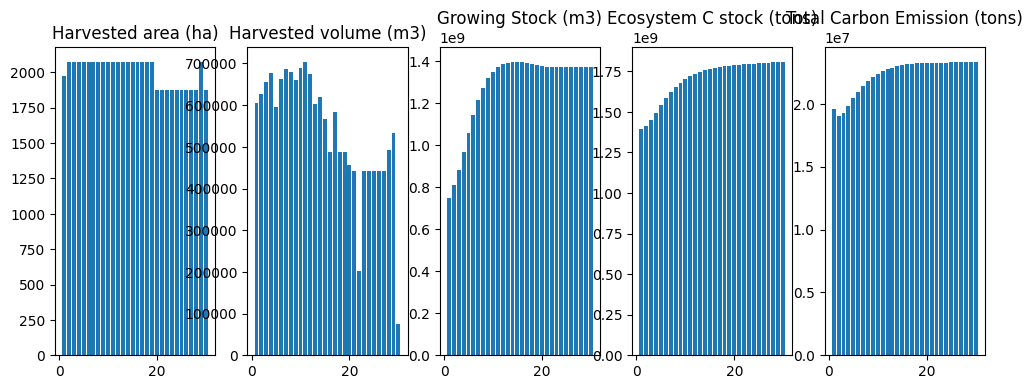

In [71]:
# With Even-flow Constraints
# Simulation Horizon - 30 Years
run_scenario(fm,'base')

running base scenario
Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-22
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (linux64)

CPU model: Intel Xeon Processor (Skylake, IBRS), instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 16 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 850 rows, 2969714 columns and 59090828 nonzeros
Model fingerprint: 0x320f7a43
Coefficient statistics:
  Matrix range     [2e-01, 1e+05]
  Objective range  [5e+00, 6e+05]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+00]
Presolve removed 332 rows and 330 columns (presolve time = 8s) ...
Presolve removed 332 rows and 330 columns (presolve time = 11s) ...
Presolve removed 332 rows and 330 columns (presolve time = 22s) ...
Presolve removed 332 rows and 330 columns (presolve time = 26s) ...
Presolve removed 332 rows and 330 columns (presolve time = 33s) ...
Presolve removed 332 rows and 330 columns
Presolve time: 39.

(<Figure size 1200x400 with 5 Axes>,
     period           oha           ohv           ogs           ocp  \
 0        1  44738.294372  6.389204e+06  7.418881e+08  1.389048e+09   
 1        2  46975.209091  7.707804e+06  7.954973e+08  1.406500e+09   
 2        3  46975.209091  6.578798e+06  8.608423e+08  1.437836e+09   
 3        4  46975.209091  7.590290e+06  9.356309e+08  1.475182e+09   
 4        5  46975.209091  7.654225e+06  1.015623e+09  1.514137e+09   
 5        6  46975.209091  7.572433e+06  1.091438e+09  1.550455e+09   
 6        7  46975.209091  7.752052e+06  1.154988e+09  1.581637e+09   
 7        8  46975.209091  8.060709e+06  1.203831e+09  1.607496e+09   
 8        9  46975.209091  8.207796e+06  1.239046e+09  1.628600e+09   
 9       10  46975.209091  9.312171e+06  1.261808e+09  1.645395e+09   
 10      11  46975.209091  8.820516e+06  1.276578e+09  1.659116e+09   
 11      12  46975.209091  8.381806e+06  1.285474e+09  1.670896e+09   
 12      13  46975.209091  1.291295e+07 

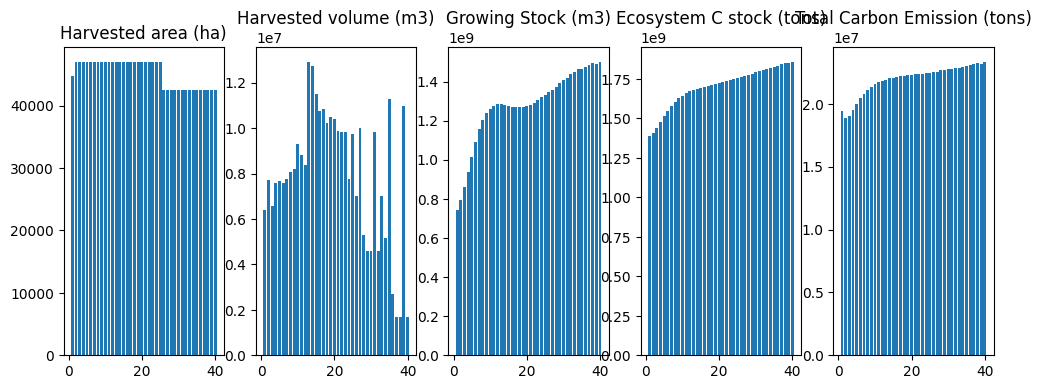

In [70]:
# With Even-flow Constraints
# Simulation Horizon - 40 Years
run_scenario(fm,'base')

## Maximize Total System Carbon Storage without Any Constraints

running base scenario
Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-22
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (linux64)

CPU model: Intel Xeon Processor (Skylake, IBRS), instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 16 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 770 rows, 45499 columns and 45499 nonzeros
Model fingerprint: 0x232972b6
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [4e+02, 5e+07]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+00]
Presolve removed 770 rows and 45499 columns
Presolve time: 0.07s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.7789538e+09   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.09 seconds (0.02 work units)
Optimal objective  1.778953780e+09
foo


(<Figure size 1200x400 with 5 Axes>,
     period        oha           ohv           ogs           ocp           ocf
 0        1  2028013.8  3.731222e+08  3.104375e+08  1.292235e+09  1.271669e+07
 1        2    84680.5  1.288202e+07  3.379425e+08  1.198684e+09  1.838058e+07
 2        3    49976.7  8.921846e+06  3.823674e+08  1.176157e+09  1.557212e+07
 3        4        0.0  0.000000e+00  4.505953e+08  1.189230e+09  1.515209e+07
 4        5        0.0  0.000000e+00  5.322398e+08  1.228757e+09  1.555516e+07
 5        6        0.0  0.000000e+00  6.329356e+08  1.280789e+09  1.648937e+07
 6        7        0.0  0.000000e+00  7.482746e+08  1.337587e+09  1.757165e+07
 7        8        0.0  0.000000e+00  8.700852e+08  1.395929e+09  1.859447e+07
 8        9        0.0  0.000000e+00  9.870906e+08  1.451174e+09  1.946375e+07
 9       10        0.0  0.000000e+00  1.093705e+09  1.501135e+09  2.017675e+07
 10      11        0.0  0.000000e+00  1.187843e+09  1.546007e+09  2.075455e+07
 11      12    

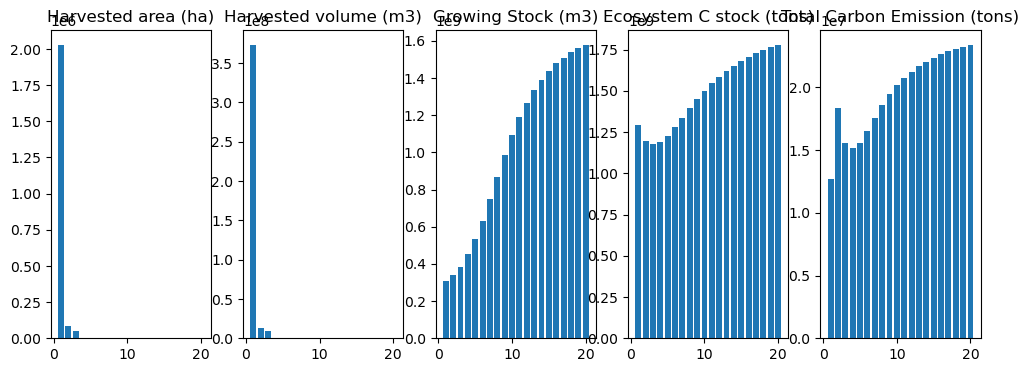

In [85]:
# product_info = {
#     "solid_wood": (0, 30),  # proportion, half-life
#     "paper": (1, 1)
# }

run_scenario(fm,'base')

(<Figure size 2000x400 with 5 Axes>,
 array([<AxesSubplot:title={'center':'Solid Wood Product C Stock'}, xlabel='Period', ylabel='Stock (tons)'>,
        <AxesSubplot:title={'center':'Paper Product C Stock'}, xlabel='Period', ylabel='Stock (tons)'>,
        <AxesSubplot:title={'center':'Total Product C Stock'}, xlabel='Period', ylabel='Stock (tons)'>,
        <AxesSubplot:title={'center':'Ecosystem C Stock'}, xlabel='Period', ylabel='Stock (tons)'>,
        <AxesSubplot:title={'center':'Total System C Stock'}, xlabel='Period', ylabel='Stock (tons)'>],
       dtype=object),
     period  solid_wood         paper   sum_product     ecosystem        system
 0        1         0.0  2.633353e+07  2.633353e+07  1.292235e+09  1.318569e+09
 1        2         0.0  8.989681e+06  8.989681e+06  1.198684e+09  1.207673e+09
 2        3         0.0  3.388179e+06  3.388179e+06  1.176157e+09  1.179545e+09
 3        4         0.0  1.039672e+06  1.039672e+06  1.189230e+09  1.190270e+09
 4        5         

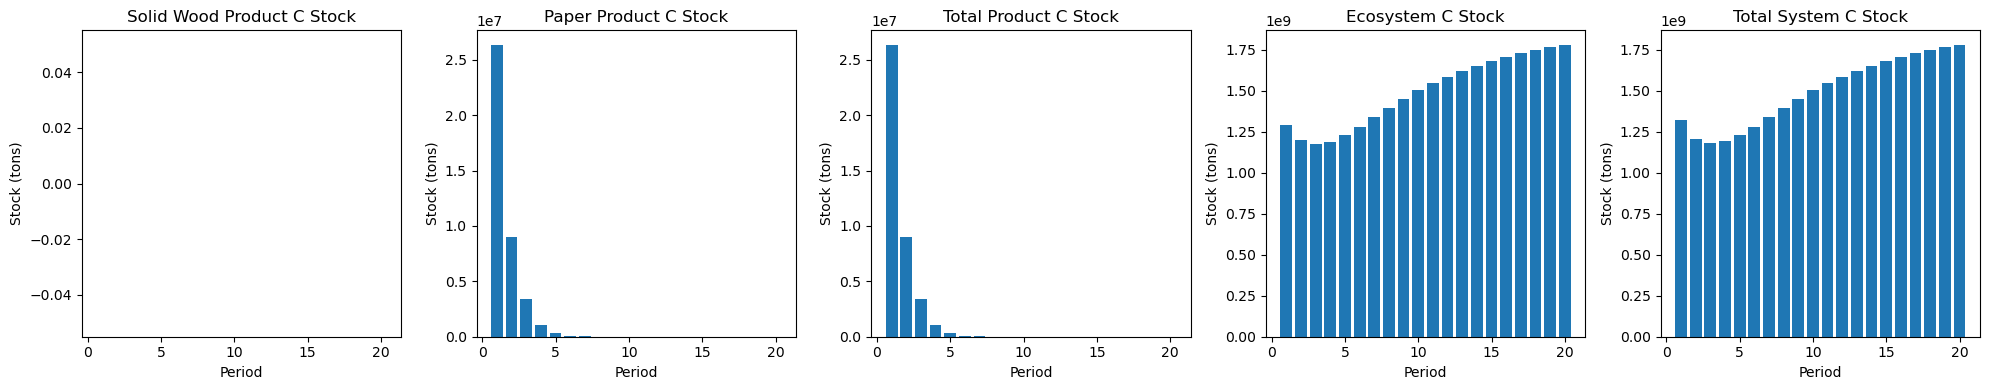

In [86]:
track_system_stock(fm)

(<Figure size 2000x400 with 5 Axes>,
 array([<AxesSubplot:title={'center':'Solid Wood Product CO2 Emission'}, xlabel='Period', ylabel='Emission (tons)'>,
        <AxesSubplot:title={'center':'Paper Product CO2 Emission'}, xlabel='Period', ylabel='Emission (tons)'>,
        <AxesSubplot:title={'center':'Total Product CO2 Emission'}, xlabel='Period', ylabel='Emission (tons)'>,
        <AxesSubplot:title={'center':'Ecosystem CO2 Emission'}, xlabel='Period', ylabel='Emission (tons)'>,
        <AxesSubplot:title={'center':'Total System CO2 Emission'}, xlabel='Period', ylabel='Emission (tons)'>],
       dtype=object),
     period  solid_wood         paper   sum_product     ecosystem        system
 0        1         0.0  2.181101e+08  2.181101e+08  0.000000e+00  2.181101e+08
 1        2         0.0  7.445795e+07  7.445795e+07 -3.102938e+09 -3.028480e+09
 2        3         0.0  2.806293e+07  2.806293e+07 -3.113891e+09 -3.085828e+09
 3        4         0.0  8.611190e+06  8.611190e+06 -3.18435

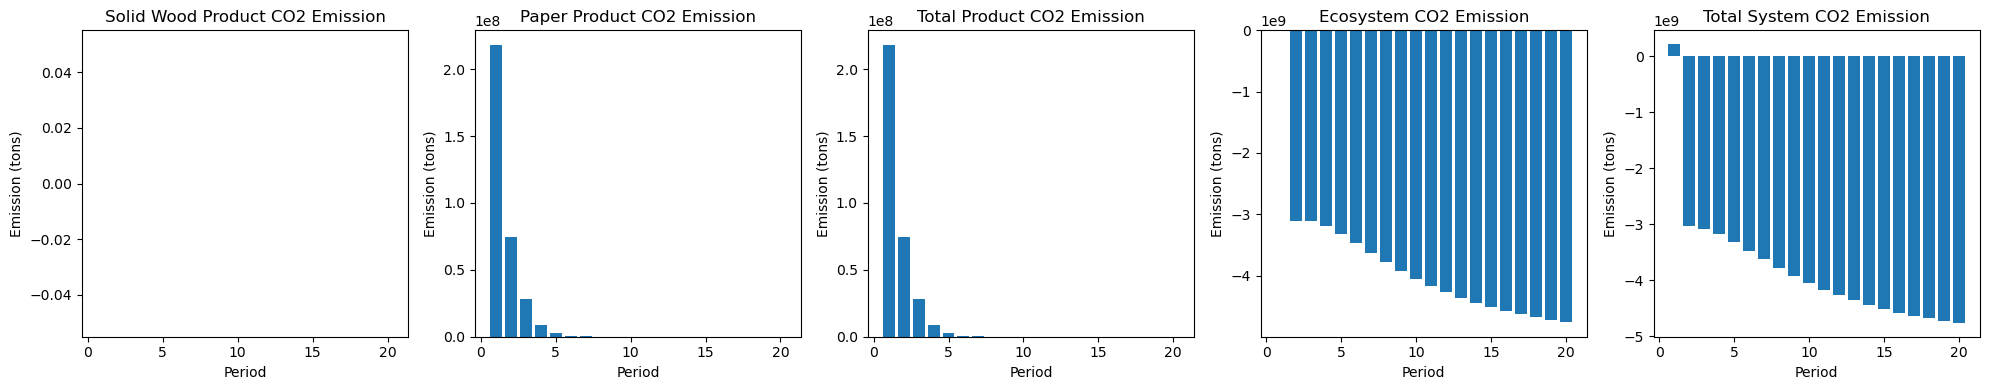

In [87]:
track_system_emission(fm)

running base scenario
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (linux64)

CPU model: Intel Xeon Processor (Skylake, IBRS), instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 16 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 770 rows, 45499 columns and 45499 nonzeros
Model fingerprint: 0xfa3b5c1b
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [4e+02, 5e+07]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+00]
Presolve removed 770 rows and 45499 columns
Presolve time: 0.06s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.7789729e+09   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.08 seconds (0.02 work units)
Optimal objective  1.778972939e+09
foo


(<Figure size 1200x400 with 5 Axes>,
     period        oha           ohv           ogs           ocp           ocf
 0        1  2028013.8  3.731222e+08  3.104375e+08  1.292235e+09  1.271669e+07
 1        2    84680.5  1.288202e+07  3.379425e+08  1.198684e+09  1.838058e+07
 2        3    49976.7  8.921846e+06  3.823674e+08  1.176157e+09  1.557212e+07
 3        4        0.0  0.000000e+00  4.505953e+08  1.189230e+09  1.515209e+07
 4        5        0.0  0.000000e+00  5.322398e+08  1.228757e+09  1.555516e+07
 5        6        0.0  0.000000e+00  6.329356e+08  1.280789e+09  1.648937e+07
 6        7        0.0  0.000000e+00  7.482746e+08  1.337587e+09  1.757165e+07
 7        8        0.0  0.000000e+00  8.700852e+08  1.395929e+09  1.859447e+07
 8        9        0.0  0.000000e+00  9.870906e+08  1.451174e+09  1.946375e+07
 9       10        0.0  0.000000e+00  1.093705e+09  1.501135e+09  2.017675e+07
 10      11        0.0  0.000000e+00  1.187843e+09  1.546007e+09  2.075455e+07
 11      12    

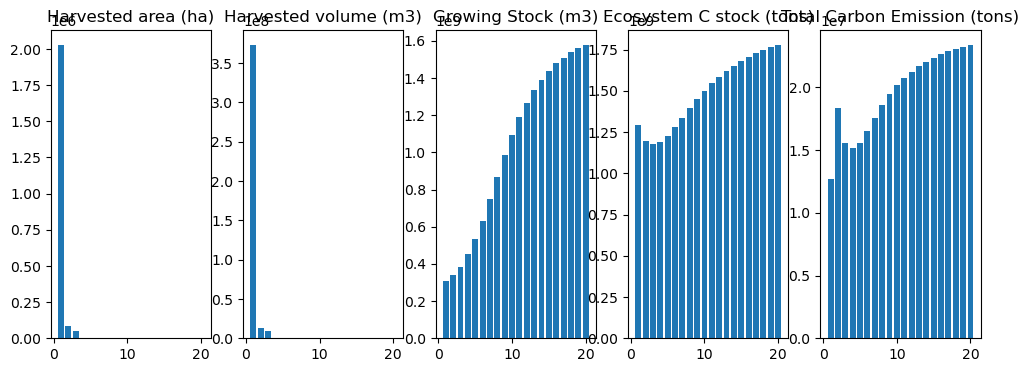

In [97]:
# product_info = {
#     "solid_wood": (0, 30),  # proportion, half-life
#     "paper": (1, 2)
# }

run_scenario(fm,'base')

(<Figure size 2000x400 with 5 Axes>,
 array([<AxesSubplot:title={'center':'Solid Wood Product C Stock'}, xlabel='Period', ylabel='Stock (tons)'>,
        <AxesSubplot:title={'center':'Paper Product C Stock'}, xlabel='Period', ylabel='Stock (tons)'>,
        <AxesSubplot:title={'center':'Total Product C Stock'}, xlabel='Period', ylabel='Stock (tons)'>,
        <AxesSubplot:title={'center':'Ecosystem C Stock'}, xlabel='Period', ylabel='Stock (tons)'>,
        <AxesSubplot:title={'center':'Total System C Stock'}, xlabel='Period', ylabel='Stock (tons)'>],
       dtype=object),
     period  solid_wood         paper   sum_product     ecosystem        system
 0        1         0.0  5.607582e+07  5.607582e+07  1.292235e+09  1.348311e+09
 1        2         0.0  3.857744e+07  3.857744e+07  1.198684e+09  1.237261e+09
 2        3         0.0  2.654836e+07  2.654836e+07  1.176157e+09  1.202705e+09
 3        4         0.0  1.734740e+07  1.734740e+07  1.189230e+09  1.206578e+09
 4        5         

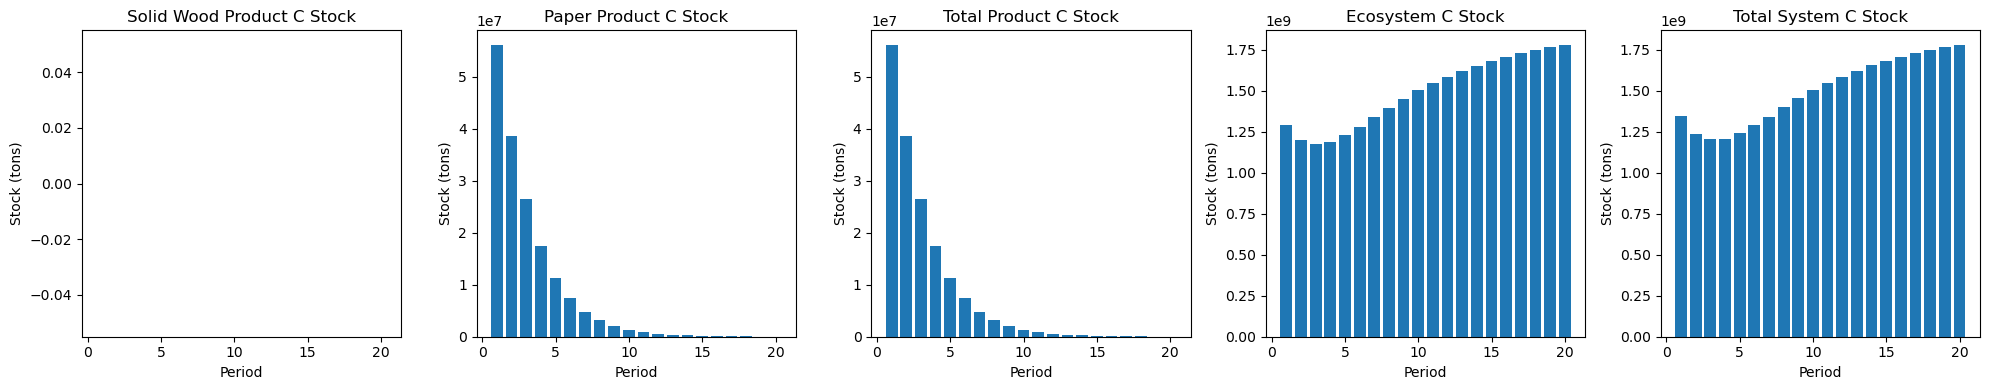

In [98]:
track_system_stock(fm)

(<Figure size 2000x400 with 5 Axes>,
 array([<AxesSubplot:title={'center':'Solid Wood Product CO2 Emission'}, xlabel='Period', ylabel='Emission (tons)'>,
        <AxesSubplot:title={'center':'Paper Product CO2 Emission'}, xlabel='Period', ylabel='Emission (tons)'>,
        <AxesSubplot:title={'center':'Total Product CO2 Emission'}, xlabel='Period', ylabel='Emission (tons)'>,
        <AxesSubplot:title={'center':'Ecosystem CO2 Emission'}, xlabel='Period', ylabel='Emission (tons)'>,
        <AxesSubplot:title={'center':'Total System CO2 Emission'}, xlabel='Period', ylabel='Emission (tons)'>],
       dtype=object),
     period  solid_wood         paper   sum_product     ecosystem        system
 0        1         0.0  1.090551e+08  1.090551e+08  0.000000e+00  1.090551e+08
 1        2         0.0  7.502458e+07  7.502458e+07 -3.102938e+09 -3.027913e+09
 2        3         0.0  5.163069e+07  5.163069e+07 -3.113891e+09 -3.062260e+09
 3        4         0.0  3.373686e+07  3.373686e+07 -3.18435

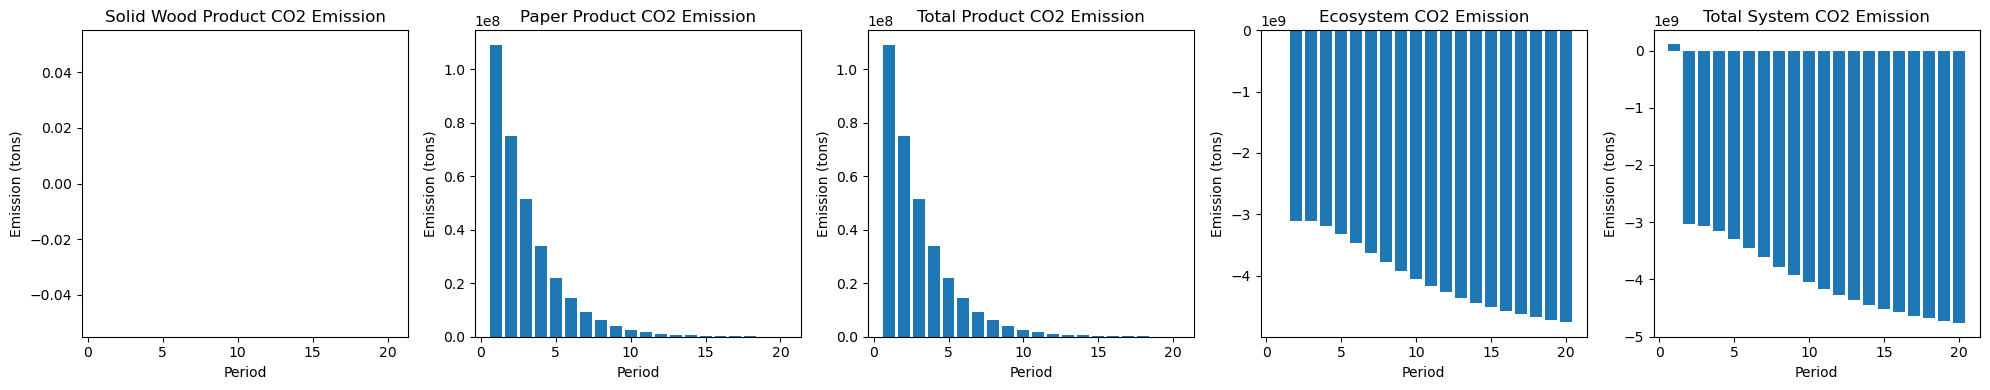

In [99]:
track_system_emission(fm)

running base scenario
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (linux64)

CPU model: Intel Xeon Processor (Skylake, IBRS), instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 16 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 770 rows, 45499 columns and 45499 nonzeros
Model fingerprint: 0x174c3118
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [4e+02, 5e+07]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+00]
Presolve removed 770 rows and 45499 columns
Presolve time: 0.04s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.8099084e+09   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.06 seconds (0.02 work units)
Optimal objective  1.809908407e+09
foo


(<Figure size 1200x400 with 5 Axes>,
     period        oha           ohv           ogs           ocp           ocf
 0        1  2290592.1  3.984607e+08  2.806274e+08  1.283055e+09  1.198641e+07
 1        2   108845.2  1.844562e+07  2.995791e+08  1.177615e+09  1.819086e+07
 2        3    54064.4  9.344554e+06  3.412967e+08  1.148131e+09  1.514394e+07
 3        4    13746.1  3.822219e+06  4.032080e+08  1.157319e+09  1.453038e+07
 4        5    26180.0  7.399122e+06  4.736901e+08  1.193690e+09  1.486418e+07
 5        6    68959.7  1.948974e+07  5.482893e+08  1.241264e+09  1.566749e+07
 6        7   119032.4  3.364153e+07  6.215342e+08  1.289811e+09  1.661690e+07
 7        8        0.0  0.000000e+00  7.419101e+08  1.339330e+09  1.807875e+07
 8        9        0.0  0.000000e+00  8.634023e+08  1.393226e+09  1.875908e+07
 9       10        0.0  0.000000e+00  9.791647e+08  1.446511e+09  1.949302e+07
 10      11        0.0  0.000000e+00  1.089849e+09  1.498050e+09  2.017107e+07
 11      12    

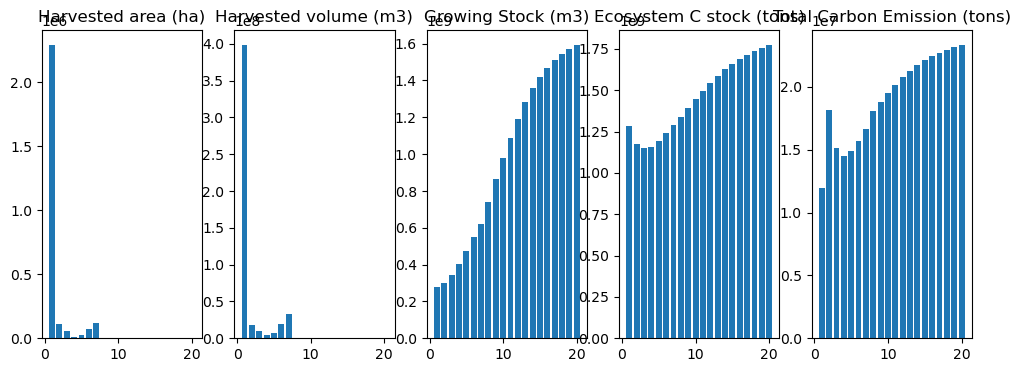

In [109]:
# product_info = {
#     "solid_wood": (0.5, 30),  # proportion, half-life
#     "paper": (0.5, 2)
# }

run_scenario(fm,'base')

(<Figure size 2000x400 with 5 Axes>,
 array([<AxesSubplot:title={'center':'Solid Wood Product C Stock'}, xlabel='Period', ylabel='Stock (tons)'>,
        <AxesSubplot:title={'center':'Paper Product C Stock'}, xlabel='Period', ylabel='Stock (tons)'>,
        <AxesSubplot:title={'center':'Total Product C Stock'}, xlabel='Period', ylabel='Stock (tons)'>,
        <AxesSubplot:title={'center':'Ecosystem C Stock'}, xlabel='Period', ylabel='Stock (tons)'>,
        <AxesSubplot:title={'center':'Total System C Stock'}, xlabel='Period', ylabel='Stock (tons)'>],
       dtype=object),
     period    solid_wood         paper   sum_product     ecosystem  \
 0        1  4.476425e+07  2.994195e+07  7.470620e+07  1.283055e+09   
 1        2  4.580221e+07  2.095094e+07  6.675315e+07  1.177615e+09   
 2        3  4.579375e+07  1.439208e+07  6.018583e+07  1.148131e+09   
 3        4  4.516509e+07  9.691385e+06  5.485647e+07  1.157319e+09   
 4        5  4.495279e+07  6.888607e+06  5.184140e+07  1.193690e+

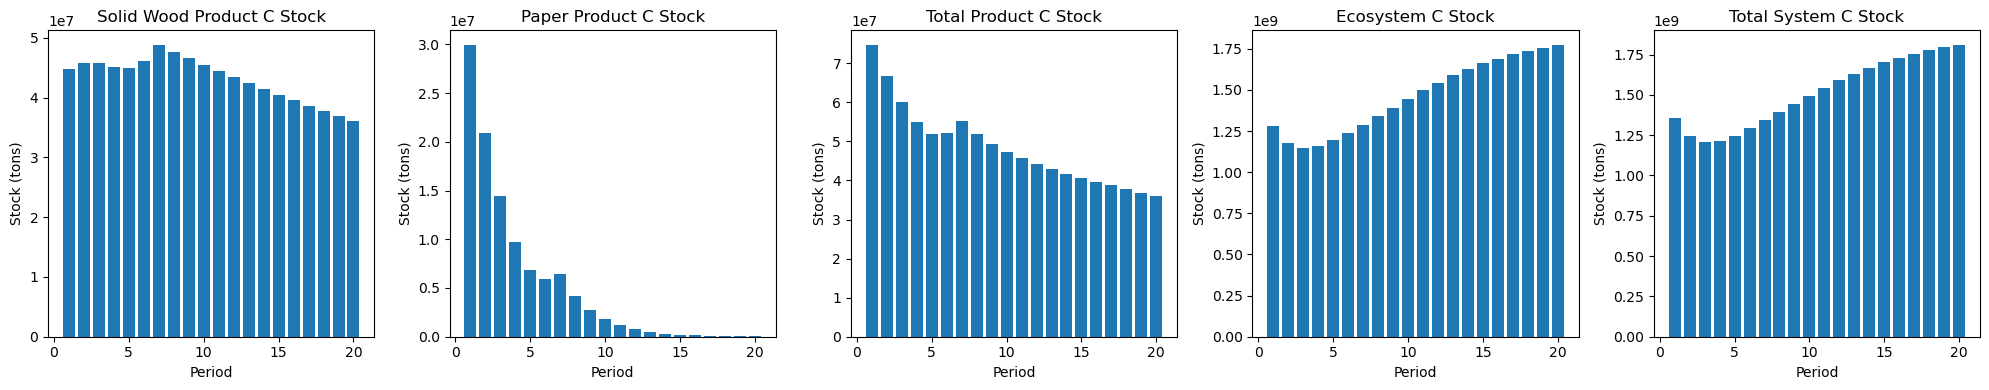

In [110]:
track_system_stock(fm)

(<Figure size 2000x400 with 5 Axes>,
 array([<AxesSubplot:title={'center':'Solid Wood Product CO2 Emission'}, xlabel='Period', ylabel='Emission (tons)'>,
        <AxesSubplot:title={'center':'Paper Product CO2 Emission'}, xlabel='Period', ylabel='Emission (tons)'>,
        <AxesSubplot:title={'center':'Total Product CO2 Emission'}, xlabel='Period', ylabel='Emission (tons)'>,
        <AxesSubplot:title={'center':'Ecosystem CO2 Emission'}, xlabel='Period', ylabel='Emission (tons)'>,
        <AxesSubplot:title={'center':'Total System CO2 Emission'}, xlabel='Period', ylabel='Emission (tons)'>],
       dtype=object),
     period    solid_wood         paper   sum_product     ecosystem  \
 0        1  3.882031e+06  5.823047e+07  6.211250e+07  0.000000e+00   
 1        2  3.972045e+06  4.074494e+07  4.471698e+07 -3.034865e+09   
 2        3  3.971311e+06  2.798942e+07  3.196073e+07 -3.032197e+09   
 3        4  3.916793e+06  1.884760e+07  2.276439e+07 -3.095371e+09   
 4        5  3.898382e+06

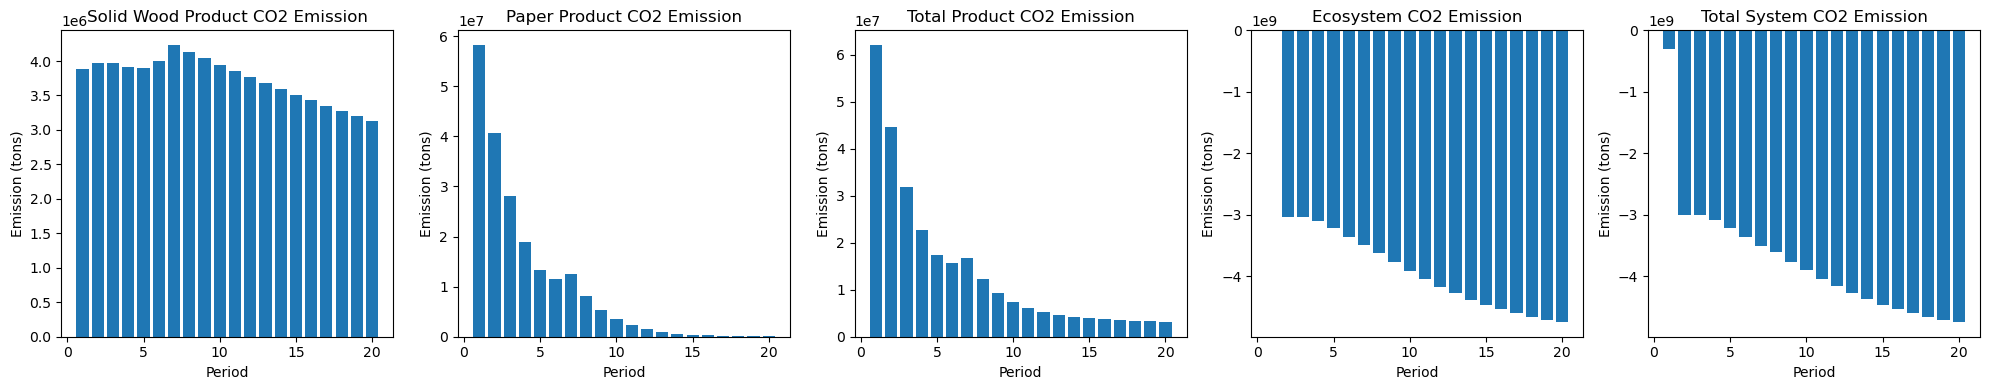

In [111]:
track_system_emission(fm)

running base scenario
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (linux64)

CPU model: Intel Xeon Processor (Skylake, IBRS), instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 16 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 770 rows, 45499 columns and 45499 nonzeros
Model fingerprint: 0x7b4893cd
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [4e+02, 6e+07]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+00]
Presolve removed 770 rows and 45499 columns
Presolve time: 0.05s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.8616028e+09   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.07 seconds (0.02 work units)
Optimal objective  1.861602825e+09
foo


(<Figure size 1200x400 with 5 Axes>,
     period        oha           ohv           ogs           ocp           ocf
 0        1  2312520.6  4.033453e+08  2.748809e+08  1.282753e+09  1.189598e+07
 1        2   110879.3  1.502816e+07  2.972935e+08  1.175719e+09  1.822054e+07
 2        3    72728.6  1.086135e+07  3.369023e+08  1.145795e+09  1.504771e+07
 3        4    14565.7  3.940257e+06  3.980459e+08  1.154004e+09  1.448288e+07
 4        5       61.7  1.151168e+04  4.771572e+08  1.190807e+09  1.489489e+07
 5        6        0.0  0.000000e+00  5.761680e+08  1.242518e+09  1.584034e+07
 6        7      616.9  1.780219e+05  6.915951e+08  1.301201e+09  1.700075e+07
 7        8   159351.0  4.216792e+07  7.679776e+08  1.355721e+09  1.754558e+07
 8        9   343103.8  9.297665e+07  7.804554e+08  1.387967e+09  1.782620e+07
 9       10   353363.7  1.164234e+08  7.505481e+08  1.393965e+09  1.818408e+07
 10      11    91394.3  2.897582e+07  8.064655e+08  1.399324e+09  1.924684e+07
 11      12    

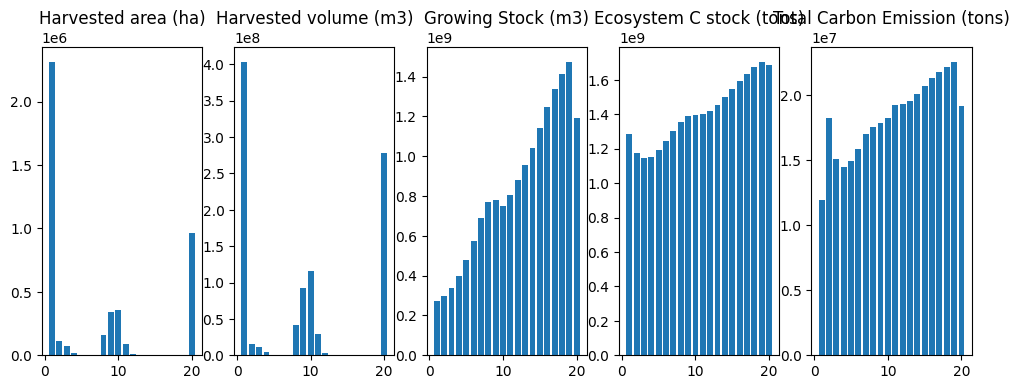

In [83]:
# product_info = {
#     "solid_wood": (1, 30),  # proportion, half-life
#     "paper": (0, 2)
# }

run_scenario(fm,'base')

(<Figure size 2000x400 with 5 Axes>,
 array([<Axes: title={'center': 'Solid Wood Product C Stock'}, xlabel='Period', ylabel='Stock (tons)'>,
        <Axes: title={'center': 'Paper Product C Stock'}, xlabel='Period', ylabel='Stock (tons)'>,
        <Axes: title={'center': 'Total Product C Stock'}, xlabel='Period', ylabel='Stock (tons)'>,
        <Axes: title={'center': 'Ecosystem C Stock'}, xlabel='Period', ylabel='Stock (tons)'>,
        <Axes: title={'center': 'Total System C Stock'}, xlabel='Period', ylabel='Stock (tons)'>],
       dtype=object),
     period    solid_wood  paper   sum_product     ecosystem        system
 0        1  9.212638e+07    0.0  9.212638e+07  1.282753e+09  1.374879e+09
 1        2  9.492033e+07    0.0  9.492033e+07  1.175719e+09  1.270639e+09
 2        3  9.674319e+07    0.0  9.674319e+07  1.145795e+09  1.242538e+09
 3        4  9.697259e+07    0.0  9.697259e+07  1.154004e+09  1.250977e+09
 4        5  9.630306e+07    0.0  9.630306e+07  1.190807e+09  1.287110

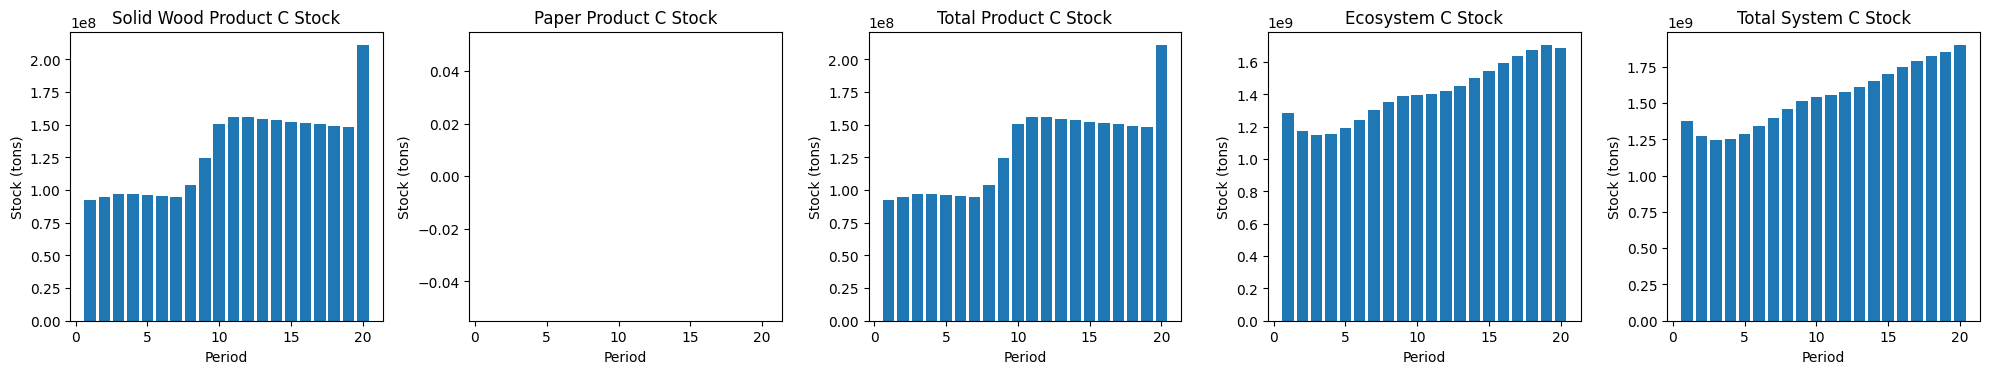

In [94]:
track_system_stock(fm)

(<Figure size 2000x400 with 5 Axes>,
 array([<Axes: title={'center': 'Solid Wood Product CO2 Emission'}, xlabel='Period', ylabel='Emission (tons)'>,
        <Axes: title={'center': 'Paper Product CO2 Emission'}, xlabel='Period', ylabel='Emission (tons)'>,
        <Axes: title={'center': 'Total Product CO2 Emission'}, xlabel='Period', ylabel='Emission (tons)'>,
        <Axes: title={'center': 'Ecosystem CO2 Emission'}, xlabel='Period', ylabel='Emission (tons)'>,
        <Axes: title={'center': 'Total System CO2 Emission'}, xlabel='Period', ylabel='Emission (tons)'>],
       dtype=object),
     period    solid_wood  paper   sum_product     ecosystem        system
 0        1  2.357771e+06    0.0  2.357771e+06  0.000000e+00 -7.459822e+08
 1        2  2.429276e+06    0.0  2.429276e+06 -3.028216e+09 -3.053669e+09
 2        3  2.475928e+06    0.0  2.475928e+06 -3.025529e+09 -3.043204e+09
 3        4  2.481799e+06    0.0  2.481799e+06 -3.085555e+09 -3.090383e+09
 4        5  2.464664e+06    0

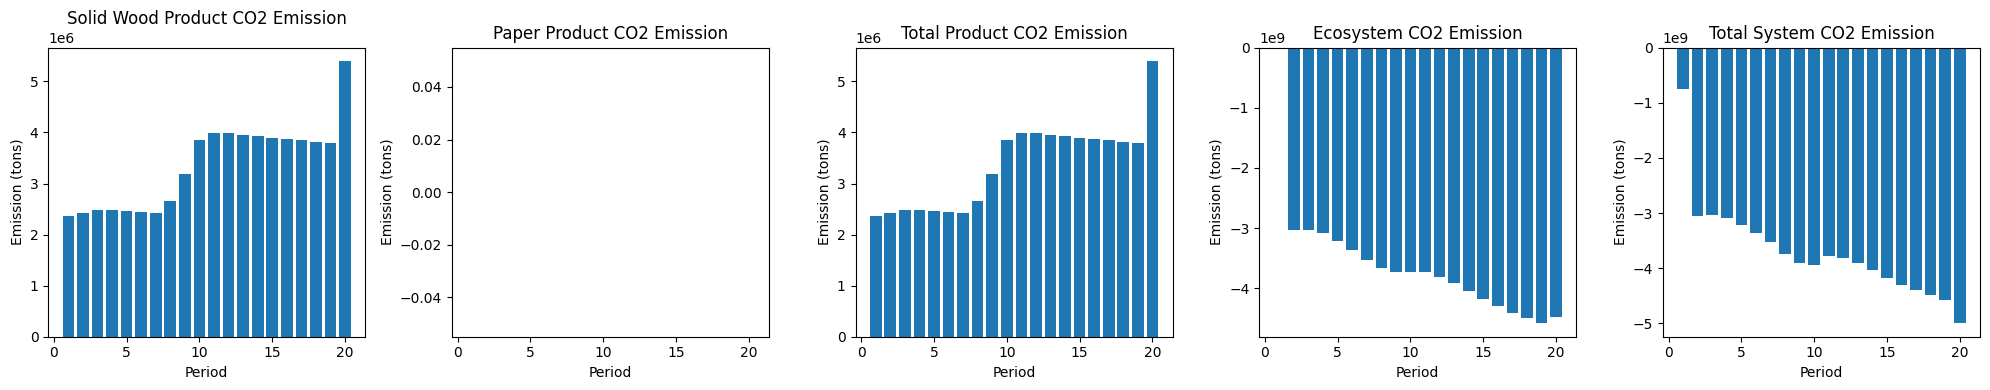

In [95]:
track_system_emission(fm)

running base scenario
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (linux64)

CPU model: Intel Xeon Processor (Skylake, IBRS), instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 16 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 770 rows, 45499 columns and 45499 nonzeros
Model fingerprint: 0x800073b2
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [4e+02, 6e+07]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+00]
Presolve removed 770 rows and 45499 columns
Presolve time: 0.04s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.8995760e+09   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.06 seconds (0.02 work units)
Optimal objective  1.899576014e+09
foo


(<Figure size 1200x400 with 5 Axes>,
     period        oha           ohv           ogs           ocp           ocf
 0        1  2302997.4  4.013499e+08  2.772284e+08  1.282838e+09  1.193524e+07
 1        2   120402.5  1.724611e+07  2.972935e+08  1.176344e+09  1.817915e+07
 2        3    65843.2  9.933275e+06  3.379941e+08  1.146115e+09  1.508737e+07
 3        4    19680.8  4.661072e+06  3.984252e+08  1.154407e+09  1.446865e+07
 4        5       61.7  1.151168e+04  4.773681e+08  1.190949e+09  1.490259e+07
 5        6        0.0  0.000000e+00  5.759528e+08  1.242509e+09  1.584171e+07
 6        7     1516.5  4.250915e+05  6.910060e+08  1.301069e+09  1.699676e+07
 7        8   203133.7  5.584482e+07  7.513259e+08  1.353155e+09  1.737019e+07
 8        9   546350.7  1.494989e+08  6.965461e+08  1.374009e+09  1.706579e+07
 9       10   568105.9  1.318538e+08  6.433922e+08  1.366085e+09  1.761085e+07
 10      11   122018.3  3.716987e+07  6.790332e+08  1.350947e+09  1.872303e+07
 11      12    

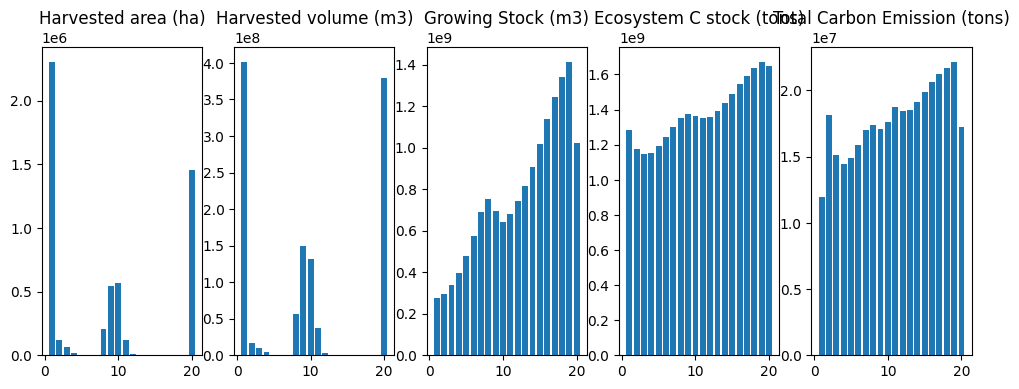

In [96]:
# product_info = {
#     "solid_wood": (1, 100),  # proportion, half-life
#     "paper": (0, 2)
# }

run_scenario(fm,'base')

(<Figure size 2000x400 with 5 Axes>,
 array([<Axes: title={'center': 'Solid Wood Product C Stock'}, xlabel='Period', ylabel='Stock (tons)'>,
        <Axes: title={'center': 'Paper Product C Stock'}, xlabel='Period', ylabel='Stock (tons)'>,
        <Axes: title={'center': 'Total Product C Stock'}, xlabel='Period', ylabel='Stock (tons)'>,
        <Axes: title={'center': 'Ecosystem C Stock'}, xlabel='Period', ylabel='Stock (tons)'>,
        <Axes: title={'center': 'Total System C Stock'}, xlabel='Period', ylabel='Stock (tons)'>],
       dtype=object),
     period    solid_wood  paper   sum_product     ecosystem        system
 0        1  9.167064e+07    0.0  9.167064e+07  1.282838e+09  1.374508e+09
 1        2  9.497433e+07    0.0  9.497433e+07  1.176344e+09  1.271318e+09
 2        3  9.658484e+07    0.0  9.658484e+07  1.146115e+09  1.242700e+09
 3        4  9.697998e+07    0.0  9.697998e+07  1.154407e+09  1.251387e+09
 4        5  9.631040e+07    0.0  9.631040e+07  1.190949e+09  1.287259

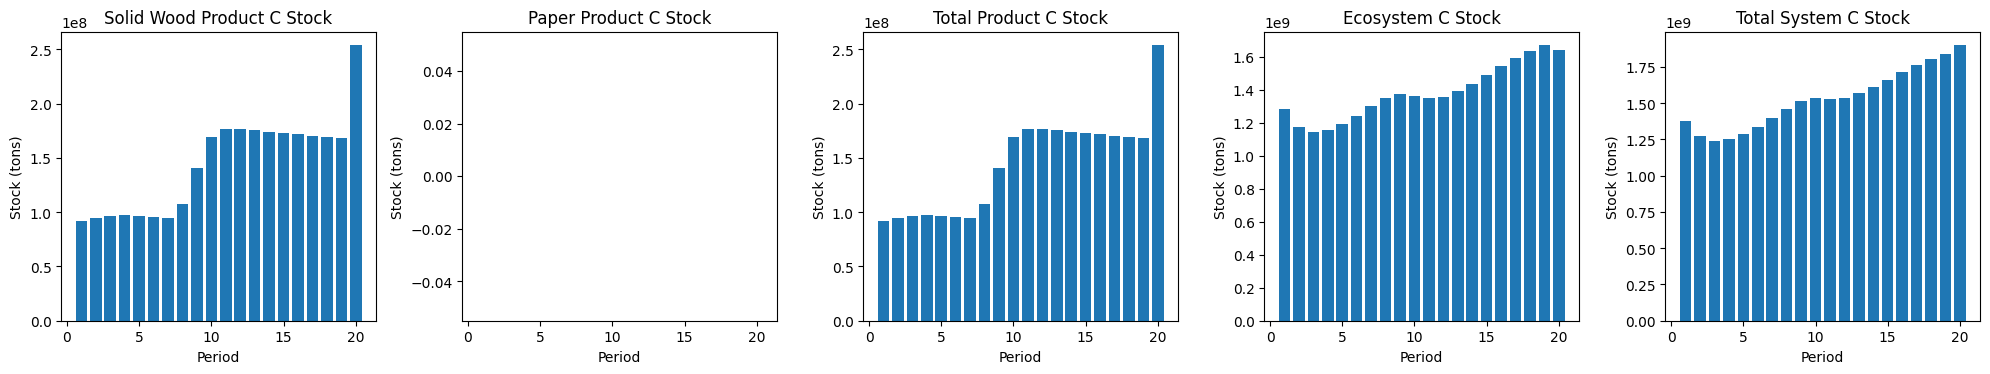

In [98]:
track_system_stock(fm)

(<Figure size 2000x400 with 5 Axes>,
 array([<Axes: title={'center': 'Solid Wood Product CO2 Emission'}, xlabel='Period', ylabel='Emission (tons)'>,
        <Axes: title={'center': 'Paper Product CO2 Emission'}, xlabel='Period', ylabel='Emission (tons)'>,
        <Axes: title={'center': 'Total Product CO2 Emission'}, xlabel='Period', ylabel='Emission (tons)'>,
        <Axes: title={'center': 'Ecosystem CO2 Emission'}, xlabel='Period', ylabel='Emission (tons)'>,
        <Axes: title={'center': 'Total System CO2 Emission'}, xlabel='Period', ylabel='Emission (tons)'>],
       dtype=object),
     period    solid_wood  paper   sum_product     ecosystem        system
 0        1  2.346108e+06    0.0  2.346108e+06  0.000000e+00 -7.422918e+08
 1        2  2.430658e+06    0.0  2.430658e+06 -3.030424e+09 -3.059990e+09
 2        3  2.471876e+06    0.0  2.471876e+06 -3.026078e+09 -3.042036e+09
 3        4  2.481989e+06    0.0  2.481989e+06 -3.086712e+09 -3.092878e+09
 4        5  2.464852e+06    0

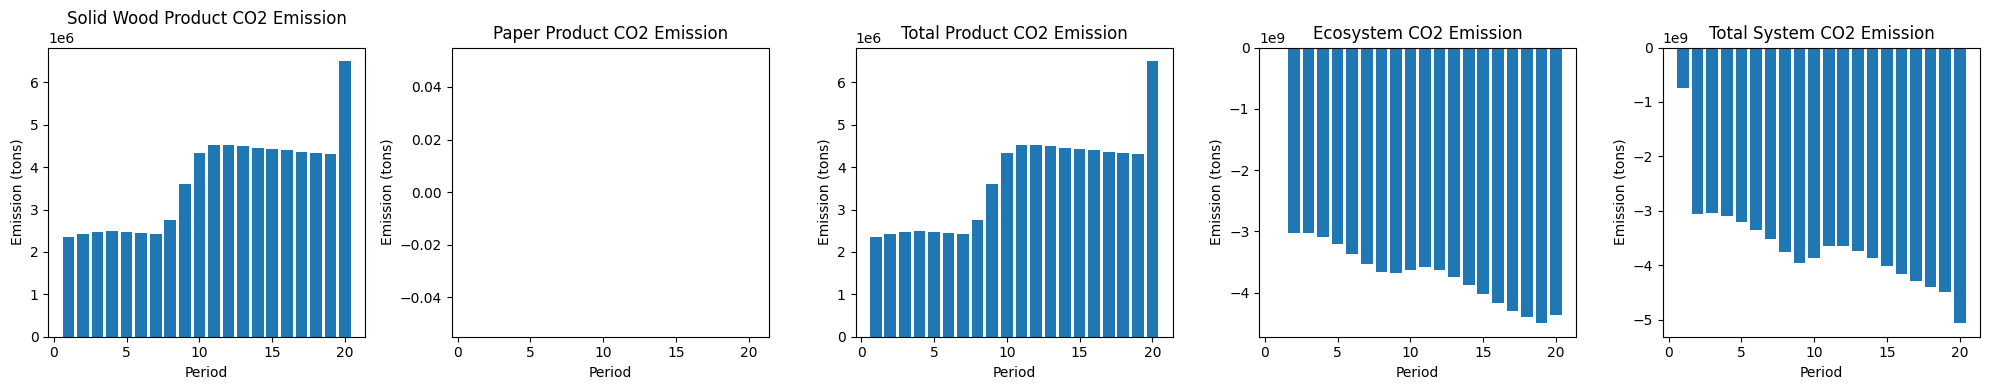

In [99]:
track_system_emission(fm)

In [100]:
# One instance for a product dictionary

# 1
# {139688993720928: (0.0, 0.0)}
# 2
# {139688993720928: (0.0, 0.0), 139688993721216: (0.0, 0.0)}
# 3
# {139688993720928: (0.0, 0.0), 139688993721216: (0.0, 0.0), 139688993721504: (0.0, 0.0)}
# 4
# {139688993720928: (0.0, 0.0), 139688993721216: (0.0, 0.0), 139688993721504: (0.0, 0.0), 139688993721792: (0.0, 0.0)}
# 5
# {139688993720928: (0.0, 0.0), 139688993721216: (0.0, 0.0), 139688993721504: (0.0, 0.0), 139688993721792: (0.0, 0.0), 139688993722128: (24767.355761059913, 0.0)}
# 6
# {139688993720928: (0.0, 0.0), 139688993721216: (0.0, 0.0), 139688993721504: (0.0, 0.0), 139688993721792: (0.0, 0.0), 139688993722128: (24767.355761059913, 0.0), 139688993724048: (24595.681532902872, 0.0)}
# 7
# {139688993720928: (0.0, 0.0), 139688993721216: (0.0, 0.0), 139688993721504: (0.0, 0.0), 139688993721792: (0.0, 0.0), 139688993722128: (24767.355761059913, 0.0), 139688993724048: (24595.681532902872, 0.0), 139688993732112: (24425.19725981805, 0.0)}
# 8
# {139688993720928: (0.0, 0.0), 139688993721216: (0.0, 0.0), 139688993721504: (0.0, 0.0), 139688993721792: (0.0, 0.0), 139688993722128: (24767.355761059913, 0.0), 139688993724048: (24595.681532902872, 0.0), 139688993732112: (24425.19725981805, 0.0), 139688993733408: (24255.894693665417, 0.0)}
# 9
# {139688993720928: (0.0, 0.0), 139688993721216: (0.0, 0.0), 139688993721504: (0.0, 0.0), 139688993721792: (0.0, 0.0), 139688993722128: (24767.355761059913, 0.0), 139688993724048: (24595.681532902872, 0.0), 139688993732112: (24425.19725981805, 0.0), 139688993733408: (24255.894693665417, 0.0), 139688993884624: (24087.765643476687, 0.0)}
# 10
# {139688993720928: (0.0, 0.0), 139688993721216: (0.0, 0.0), 139688993721504: (0.0, 0.0), 139688993721792: (0.0, 0.0), 139688993722128: (24767.355761059913, 0.0), 139688993724048: (24595.681532902872, 0.0), 139688993732112: (24425.19725981805, 0.0), 139688993733408: (24255.894693665417, 0.0), 139688993884624: (24087.765643476687, 0.0), 139688993888608: (23920.80197505904, 0.0)}
# 11
# {139688993720928: (0.0, 0.0), 139688993721216: (0.0, 0.0), 139688993721504: (0.0, 0.0), 139688993721792: (0.0, 0.0), 139688993722128: (24767.355761059913, 0.0), 139688993724048: (24595.681532902872, 0.0), 139688993732112: (24425.19725981805, 0.0), 139688993733408: (24255.894693665417, 0.0), 139688993884624: (24087.765643476687, 0.0), 139688993888608: (23920.80197505904, 0.0), 139688993889280: (23754.99561060159, 0.0)}
# 12
# {139688993720928: (0.0, 0.0), 139688993721216: (0.0, 0.0), 139688993721504: (0.0, 0.0), 139688993721792: (0.0, 0.0), 139688993722128: (24767.355761059913, 0.0), 139688993724048: (24595.681532902872, 0.0), 139688993732112: (24425.19725981805, 0.0), 139688993733408: (24255.894693665417, 0.0), 139688993884624: (24087.765643476687, 0.0), 139688993888608: (23920.80197505904, 0.0), 139688993889280: (23754.99561060159, 0.0), 139688993892016: (23590.338528284563, 0.0)}
# 13
# {139688993720928: (0.0, 0.0), 139688993721216: (0.0, 0.0), 139688993721504: (0.0, 0.0), 139688993721792: (0.0, 0.0), 139688993722128: (24767.355761059913, 0.0), 139688993724048: (24595.681532902872, 0.0), 139688993732112: (24425.19725981805, 0.0), 139688993733408: (24255.894693665417, 0.0), 139688993884624: (24087.765643476687, 0.0), 139688993888608: (23920.80197505904, 0.0), 139688993889280: (23754.99561060159, 0.0), 139688993892016: (23590.338528284563, 0.0), 139688993892544: (23426.82276189121, 0.0)}
# 14
# {139688993720928: (0.0, 0.0), 139688993721216: (0.0, 0.0), 139688993721504: (0.0, 0.0), 139688993721792: (0.0, 0.0), 139688993722128: (24767.355761059913, 0.0), 139688993724048: (24595.681532902872, 0.0), 139688993732112: (24425.19725981805, 0.0), 139688993733408: (24255.894693665417, 0.0), 139688993884624: (24087.765643476687, 0.0), 139688993888608: (23920.80197505904, 0.0), 139688993889280: (23754.99561060159, 0.0), 139688993892016: (23590.338528284563, 0.0), 139688993892544: (23426.82276189121, 0.0), 139688993893168: (37110.75740069997, 0.0)}
# 15
# {139688993720928: (0.0, 0.0), 139688993721216: (0.0, 0.0), 139688993721504: (0.0, 0.0), 139688993721792: (0.0, 0.0), 139688993722128: (24767.355761059913, 0.0), 139688993724048: (24595.681532902872, 0.0), 139688993732112: (24425.19725981805, 0.0), 139688993733408: (24255.894693665417, 0.0), 139688993884624: (24087.765643476687, 0.0), 139688993888608: (23920.80197505904, 0.0), 139688993889280: (23754.99561060159, 0.0), 139688993892016: (23590.338528284563, 0.0), 139688993892544: (23426.82276189121, 0.0), 139688993893168: (37110.75740069997, 0.0), 139688993895088: (36853.52523209258, 0.0)}
# 16
# {139688993720928: (0.0, 0.0), 139688993721216: (0.0, 0.0), 139688993721504: (0.0, 0.0), 139688993721792: (0.0, 0.0), 139688993722128: (24767.355761059913, 0.0), 139688993724048: (24595.681532902872, 0.0), 139688993732112: (24425.19725981805, 0.0), 139688993733408: (24255.894693665417, 0.0), 139688993884624: (24087.765643476687, 0.0), 139688993888608: (23920.80197505904, 0.0), 139688993889280: (23754.99561060159, 0.0), 139688993892016: (23590.338528284563, 0.0), 139688993892544: (23426.82276189121, 0.0), 139688993893168: (37110.75740069997, 0.0), 139688993895088: (36853.52523209258, 0.0), 139688993895952: (36598.07606100938, 0.0)}
# 17
# {139688993720928: (0.0, 0.0), 139688993721216: (0.0, 0.0), 139688993721504: (0.0, 0.0), 139688993721792: (0.0, 0.0), 139688993722128: (24767.355761059913, 0.0), 139688993724048: (24595.681532902872, 0.0), 139688993732112: (24425.19725981805, 0.0), 139688993733408: (24255.894693665417, 0.0), 139688993884624: (24087.765643476687, 0.0), 139688993888608: (23920.80197505904, 0.0), 139688993889280: (23754.99561060159, 0.0), 139688993892016: (23590.338528284563, 0.0), 139688993892544: (23426.82276189121, 0.0), 139688993893168: (37110.75740069997, 0.0), 139688993895088: (36853.52523209258, 0.0), 139688993895952: (36598.07606100938, 0.0), 139688993897152: (36344.39752865331, 0.0)}
# 18
# {139688993720928: (0.0, 0.0), 139688993721216: (0.0, 0.0), 139688993721504: (0.0, 0.0), 139688993721792: (0.0, 0.0), 139688993722128: (24767.355761059913, 0.0), 139688993724048: (24595.681532902872, 0.0), 139688993732112: (24425.19725981805, 0.0), 139688993733408: (24255.894693665417, 0.0), 139688993884624: (24087.765643476687, 0.0), 139688993888608: (23920.80197505904, 0.0), 139688993889280: (23754.99561060159, 0.0), 139688993892016: (23590.338528284563, 0.0), 139688993892544: (23426.82276189121, 0.0), 139688993893168: (37110.75740069997, 0.0), 139688993895088: (36853.52523209258, 0.0), 139688993895952: (36598.07606100938, 0.0), 139688993897152: (36344.39752865331, 0.0), 139688993897392: (36092.47736189195, 0.0)}
# 19
# {139688993720928: (0.0, 0.0), 139688993721216: (0.0, 0.0), 139688993721504: (0.0, 0.0), 139688993721792: (0.0, 0.0), 139688993722128: (24767.355761059913, 0.0), 139688993724048: (24595.681532902872, 0.0), 139688993732112: (24425.19725981805, 0.0), 139688993733408: (24255.894693665417, 0.0), 139688993884624: (24087.765643476687, 0.0), 139688993888608: (23920.80197505904, 0.0), 139688993889280: (23754.99561060159, 0.0), 139688993892016: (23590.338528284563, 0.0), 139688993892544: (23426.82276189121, 0.0), 139688993893168: (37110.75740069997, 0.0), 139688993895088: (36853.52523209258, 0.0), 139688993895952: (36598.07606100938, 0.0), 139688993897152: (36344.39752865331, 0.0), 139688993897392: (36092.47736189195, 0.0), 139688993897632: (35842.30337266376, 0.0)}
# 20
# {139688993720928: (0.0, 0.0), 139688993721216: (0.0, 0.0), 139688993721504: (0.0, 0.0), 139688993721792: (0.0, 0.0), 139688993722128: (24767.355761059913, 0.0), 139688993724048: (24595.681532902872, 0.0), 139688993732112: (24425.19725981805, 0.0), 139688993733408: (24255.894693665417, 0.0), 139688993884624: (24087.765643476687, 0.0), 139688993888608: (23920.80197505904, 0.0), 139688993889280: (23754.99561060159, 0.0), 139688993892016: (23590.338528284563, 0.0), 139688993892544: (23426.82276189121, 0.0), 139688993893168: (37110.75740069997, 0.0), 139688993895088: (36853.52523209258, 0.0), 139688993895952: (36598.07606100938, 0.0), 139688993897152: (36344.39752865331, 0.0), 139688993897392: (36092.47736189195, 0.0), 139688993897632: (35842.30337266376, 0.0), 139688993897920: (35593.8634573884, 0.0)}

## Maximize Total System Carbon Storage with Even-flow Constraints

running base scenario
Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-22
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (linux64)

CPU model: Intel Xeon Processor (Skylake, IBRS), instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 16 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 810 rows, 45499 columns and 486195 nonzeros
Model fingerprint: 0x4609857c
Coefficient statistics:
  Matrix range     [2e-01, 1e+05]
  Objective range  [4e+02, 5e+07]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+00]
Presolve removed 332 rows and 330 columns
Presolve time: 0.27s
Presolved: 478 rows, 45169 columns, 470823 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 1.669e+04
 Factor NZ  : 2.218e+04 (roughly 20 MB of memory)
 Factor Ops : 1.107e+06 (less than 1 second per iteration)
 Threads    : 14

(<Figure size 1200x400 with 5 Axes>,
     period  oha  ohv           ogs           ocp           ocf
 0        1  0.0  0.0  7.494048e+08  1.381789e+09  1.954011e+07
 1        2  0.0  0.0  8.124675e+08  1.402196e+09  1.894992e+07
 2        3  0.0  0.0  8.861458e+08  1.436742e+09  1.921555e+07
 3        4  0.0  0.0  9.707337e+08  1.478353e+09  1.975706e+07
 4        5  0.0  0.0  1.060630e+09  1.521575e+09  2.033804e+07
 5        6  0.0  0.0  1.146251e+09  1.561899e+09  2.085700e+07
 6        7  0.0  0.0  1.219698e+09  1.597082e+09  2.128955e+07
 7        8  0.0  0.0  1.278276e+09  1.626686e+09  2.164259e+07
 8        9  0.0  0.0  1.322490e+09  1.651037e+09  2.192896e+07
 9       10  0.0  0.0  1.354309e+09  1.670935e+09  2.216033e+07
 10      11  0.0  0.0  1.376027e+09  1.687321e+09  2.234828e+07
 11      12  0.0  0.0  1.389710e+09  1.700760e+09  2.250060e+07
 12      13  0.0  0.0  1.397148e+09  1.711820e+09  2.262491e+07
 13      14  0.0  0.0  1.399821e+09  1.721052e+09  2.272777e+07
 14

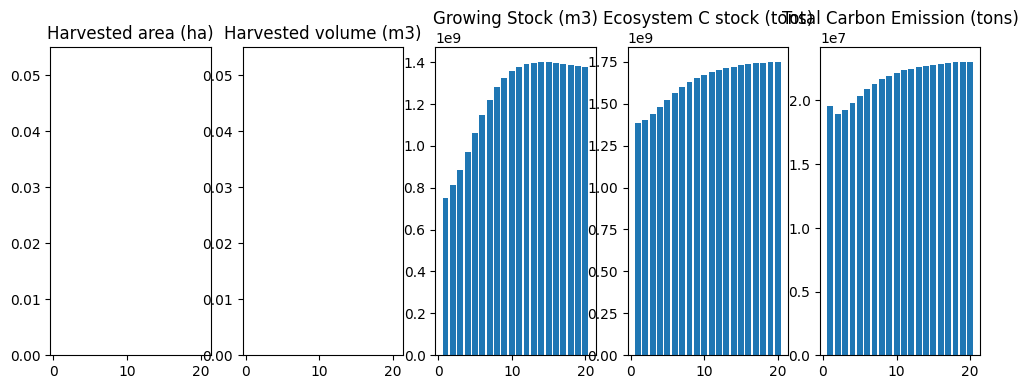

In [76]:
# product_info = {
#     "solid_wood": (0, 30),  # proportion, half-life
#     "paper": (1, 2)
# }

run_scenario(fm,'base')

running base scenario
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (linux64)

CPU model: Intel Xeon Processor (Skylake, IBRS), instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 16 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 810 rows, 45499 columns and 486195 nonzeros
Model fingerprint: 0x1b9f8be6
Coefficient statistics:
  Matrix range     [2e-01, 1e+05]
  Objective range  [4e+02, 5e+07]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+00]
Presolve removed 332 rows and 330 columns
Presolve time: 0.23s
Presolved: 478 rows, 45169 columns, 470823 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 1.669e+04
 Factor NZ  : 2.218e+04 (roughly 20 MB of memory)
 Factor Ops : 1.107e+06 (less than 1 second per iteration)
 Threads    : 14

Barrier performed 0 iterations in 0.55 seconds (0.15 work units)
Barrier solve interrupte

(<Figure size 1200x400 with 5 Axes>,
     period          oha           ohv           ogs           ocp  \
 0        1  3284.711538  1.117624e+06  7.480899e+08  1.381585e+09   
 1        2  3448.947115  1.167002e+06  8.097835e+08  1.401560e+09   
 2        3  3448.947115  1.148590e+06  8.821077e+08  1.435579e+09   
 3        4  3448.947115  1.125939e+06  9.653609e+08  1.476655e+09   
 4        5  3448.947115  1.141860e+06  1.053997e+09  1.519373e+09   
 5        6  3448.947115  1.087625e+06  1.138663e+09  1.559252e+09   
 6        7  3448.947115  1.087625e+06  1.211475e+09  1.594101e+09   
 7        8  3448.947115  1.087625e+06  1.269704e+09  1.623459e+09   
 8        9  3448.947115  1.087625e+06  1.313815e+09  1.647635e+09   
 9       10  3448.947115  1.084782e+06  1.345718e+09  1.667413e+09   
 10      11  3448.947115  1.084694e+06  1.367717e+09  1.683737e+09   
 11      12  3448.947115  1.075899e+06  1.381872e+09  1.697169e+09   
 12      13  3120.475962  9.627134e+05  1.390082e+09 

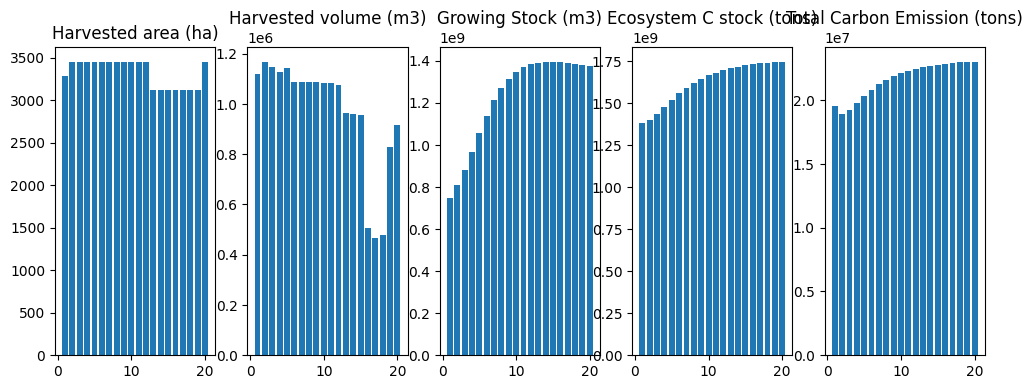

In [95]:
# product_info = {
#     "solid_wood": (0.5, 30),  # proportion, half-life
#     "paper": (0.5, 2)
# }

run_scenario(fm,'base')

(<Figure size 2000x400 with 5 Axes>,
 array([<Axes: title={'center': 'Solid Wood Product C Stock'}, xlabel='Period', ylabel='Stock (tons)'>,
        <Axes: title={'center': 'Paper Product C Stock'}, xlabel='Period', ylabel='Stock (tons)'>,
        <Axes: title={'center': 'Total Product C Stock'}, xlabel='Period', ylabel='Stock (tons)'>,
        <Axes: title={'center': 'Ecosystem C Stock'}, xlabel='Period', ylabel='Stock (tons)'>,
        <Axes: title={'center': 'Total System C Stock'}, xlabel='Period', ylabel='Stock (tons)'>],
       dtype=object),
     period    solid_wood          paper   sum_product     ecosystem  \
 0        1  1.255572e+05   83982.778278  2.095399e+05  1.381585e+09   
 1        2  2.537606e+05  142569.788770  3.963304e+05  1.401560e+09   
 2        3  3.769334e+05  179468.538740  5.564020e+05  1.435579e+09   
 3        4  4.947157e+05  201877.092774  6.965928e+05  1.476655e+09   
 4        5  6.115653e+05  217715.806650  8.292811e+05  1.519373e+09   
 5        6  

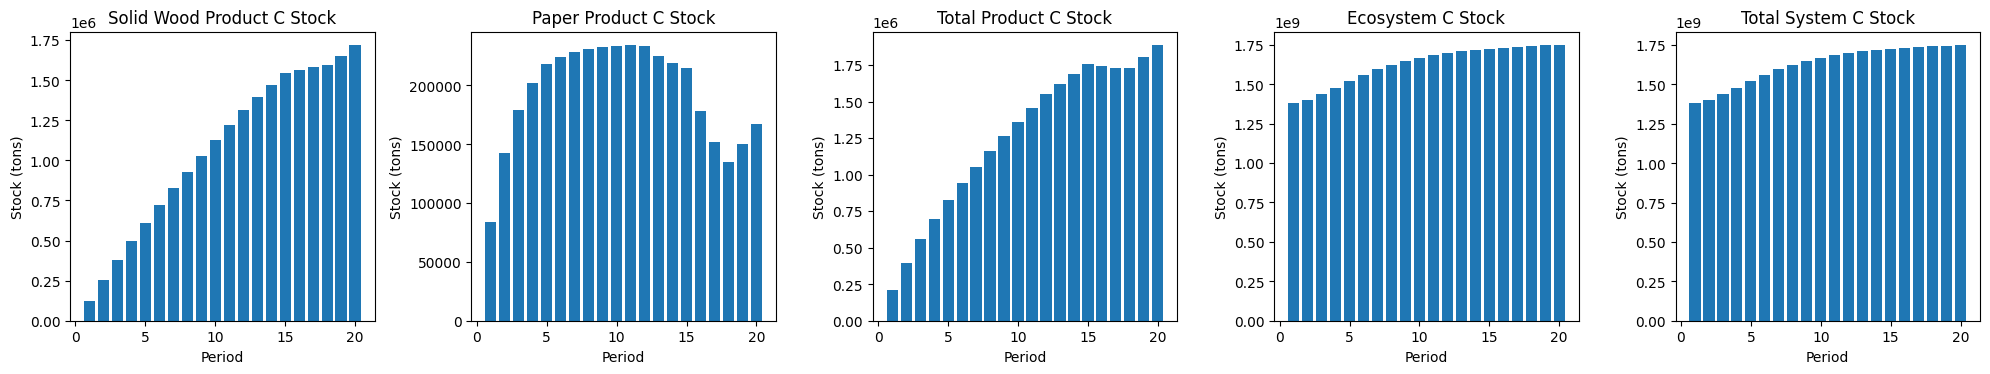

In [96]:
track_system_stock(fm)

(<Figure size 2000x400 with 5 Axes>,
 array([<Axes: title={'center': 'Solid Wood Product CO2 Emission'}, xlabel='Period', ylabel='Emission (tons)'>,
        <Axes: title={'center': 'Paper Product CO2 Emission'}, xlabel='Period', ylabel='Emission (tons)'>,
        <Axes: title={'center': 'Total Product CO2 Emission'}, xlabel='Period', ylabel='Emission (tons)'>,
        <Axes: title={'center': 'Ecosystem CO2 Emission'}, xlabel='Period', ylabel='Emission (tons)'>,
        <Axes: title={'center': 'Total System CO2 Emission'}, xlabel='Period', ylabel='Emission (tons)'>],
       dtype=object),
     period     solid_wood          paper    sum_product     ecosystem  \
 0        1   10888.528468  163327.927022  174216.455490  0.000000e+00   
 1        2   22006.544855  277266.703166  299273.248020 -3.757468e+09   
 2        3   32688.300610  349026.609969  381714.910579 -3.862231e+09   
 3        4   42902.579577  392606.290864  435508.870442 -3.978821e+09   
 4        5   53035.970629  423409.

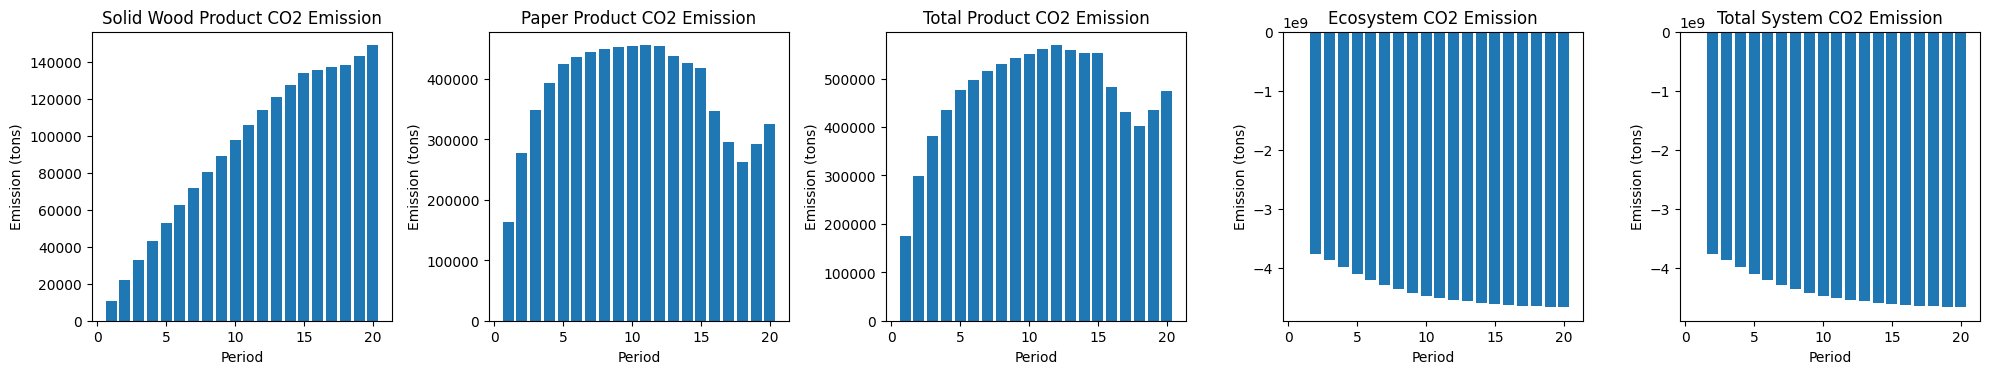

In [97]:
track_system_emission(fm)

running base scenario
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (linux64)

CPU model: Intel Xeon Processor (Skylake, IBRS), instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 16 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 810 rows, 45499 columns and 486195 nonzeros
Model fingerprint: 0xa29f0593
Coefficient statistics:
  Matrix range     [2e-01, 1e+05]
  Objective range  [4e+02, 6e+07]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+00]
Presolve removed 332 rows and 330 columns
Presolve time: 0.25s
Presolved: 478 rows, 45169 columns, 470823 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 1.669e+04
 Factor NZ  : 2.218e+04 (roughly 20 MB of memory)
 Factor Ops : 1.107e+06 (less than 1 second per iteration)
 Threads    : 14

Barrier performed 0 iterations in 0.56 seconds (0.14 work units)
Barrier solve interrupte

(<Figure size 1200x400 with 5 Axes>,
     period           oha           ohv           ogs           ocp  \
 0        1  56714.666667  1.582465e+07  7.307875e+08  1.377608e+09   
 1        2  59550.400000  1.657868e+07  7.745817e+08  1.390654e+09   
 2        3  59550.400000  1.644289e+07  8.292427e+08  1.416484e+09   
 3        4  59550.400000  1.606906e+07  8.952688e+08  1.449136e+09   
 4        5  59550.400000  1.595332e+07  9.669295e+08  1.484026e+09   
 5        6  59550.400000  1.806738e+07  1.033509e+09  1.516372e+09   
 6        7  59550.400000  1.488754e+07  1.095391e+09  1.544819e+09   
 7        8  59550.400000  1.752664e+07  1.143036e+09  1.568935e+09   
 8        9  59550.400000  2.057615e+07  1.176090e+09  1.588664e+09   
 9       10  59550.400000  2.053071e+07  1.200386e+09  1.604649e+09   
 10      11  59550.400000  2.113295e+07  1.217463e+09  1.617591e+09   
 11      12  59550.400000  2.119845e+07  1.228636e+09  1.628455e+09   
 12      13  53878.933333  1.946376e+07 

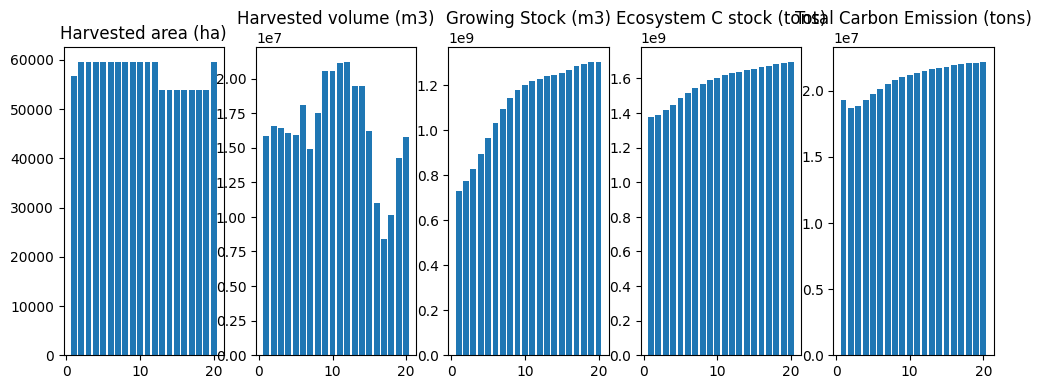

In [ ]:
# product_info = {
#     "solid_wood": (1, 30),  # proportion, half-life
#     "paper": (0, 2)
# }

run_scenario(fm,'base')

(<Figure size 2000x400 with 5 Axes>,
 array([<Axes: title={'center': 'Solid Wood Product C Stock'}, xlabel='Period', ylabel='Stock (tons)'>,
        <Axes: title={'center': 'Paper Product C Stock'}, xlabel='Period', ylabel='Stock (tons)'>,
        <Axes: title={'center': 'Total Product C Stock'}, xlabel='Period', ylabel='Stock (tons)'>,
        <Axes: title={'center': 'Ecosystem C Stock'}, xlabel='Period', ylabel='Stock (tons)'>,
        <Axes: title={'center': 'Total System C Stock'}, xlabel='Period', ylabel='Stock (tons)'>],
       dtype=object),
     period    solid_wood  paper   sum_product     ecosystem        system
 0        1  3.555575e+06    0.0  3.555575e+06  1.377608e+09  1.381164e+09
 1        2  7.198420e+06    0.0  7.198420e+06  1.390654e+09  1.397853e+09
 2        3  1.072659e+07    0.0  1.072659e+07  1.416484e+09  1.427210e+09
 3        4  1.408924e+07    0.0  1.408924e+07  1.449136e+09  1.463225e+09
 4        5  1.734820e+07    0.0  1.734820e+07  1.484026e+09  1.501374

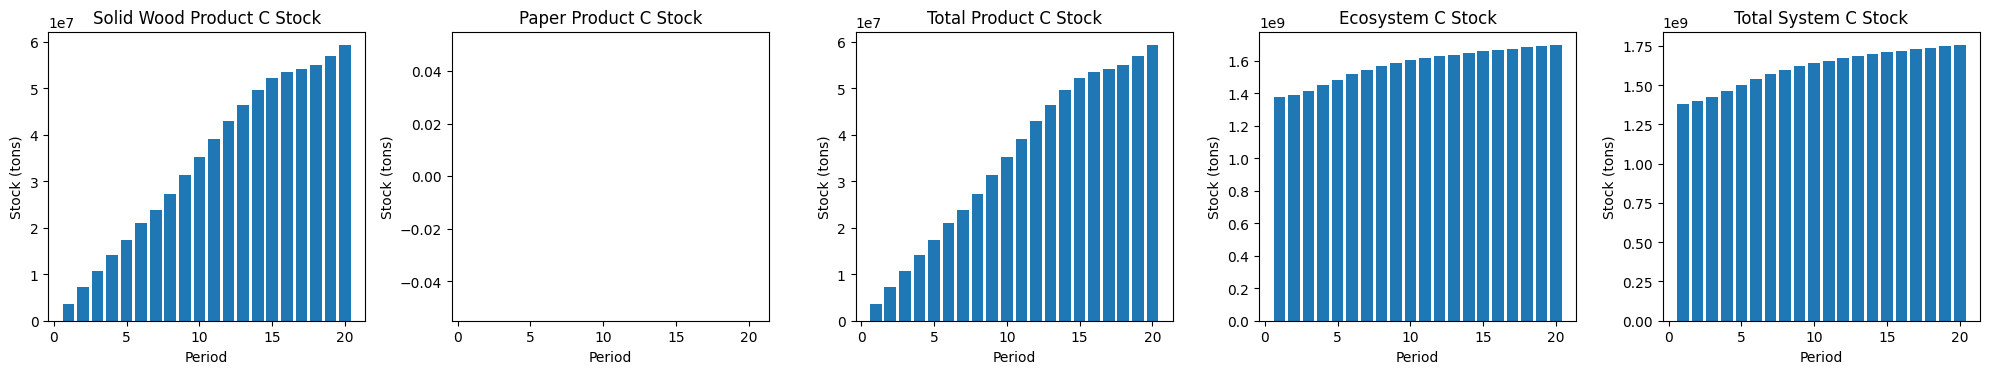

In [108]:
track_system_stock(fm)

(<Figure size 2000x400 with 5 Axes>,
 array([<Axes: title={'center': 'Solid Wood Product CO2 Emission'}, xlabel='Period', ylabel='Emission (tons)'>,
        <Axes: title={'center': 'Paper Product CO2 Emission'}, xlabel='Period', ylabel='Emission (tons)'>,
        <Axes: title={'center': 'Total Product CO2 Emission'}, xlabel='Period', ylabel='Emission (tons)'>,
        <Axes: title={'center': 'Ecosystem CO2 Emission'}, xlabel='Period', ylabel='Emission (tons)'>,
        <Axes: title={'center': 'Total System CO2 Emission'}, xlabel='Period', ylabel='Emission (tons)'>],
       dtype=object),
     period    solid_wood  paper   sum_product     ecosystem        system
 0        1  3.083455e+05    0.0  3.083455e+05  0.000000e+00 -2.905165e+07
 1        2  6.242591e+05    0.0  6.242591e+05 -3.721457e+09 -3.751592e+09
 2        3  9.302276e+05    0.0  9.302276e+05 -3.803119e+09 -3.832696e+09
 3        4  1.221843e+06    0.0  1.221843e+06 -3.897015e+09 -3.925607e+09
 4        5  1.504465e+06    0

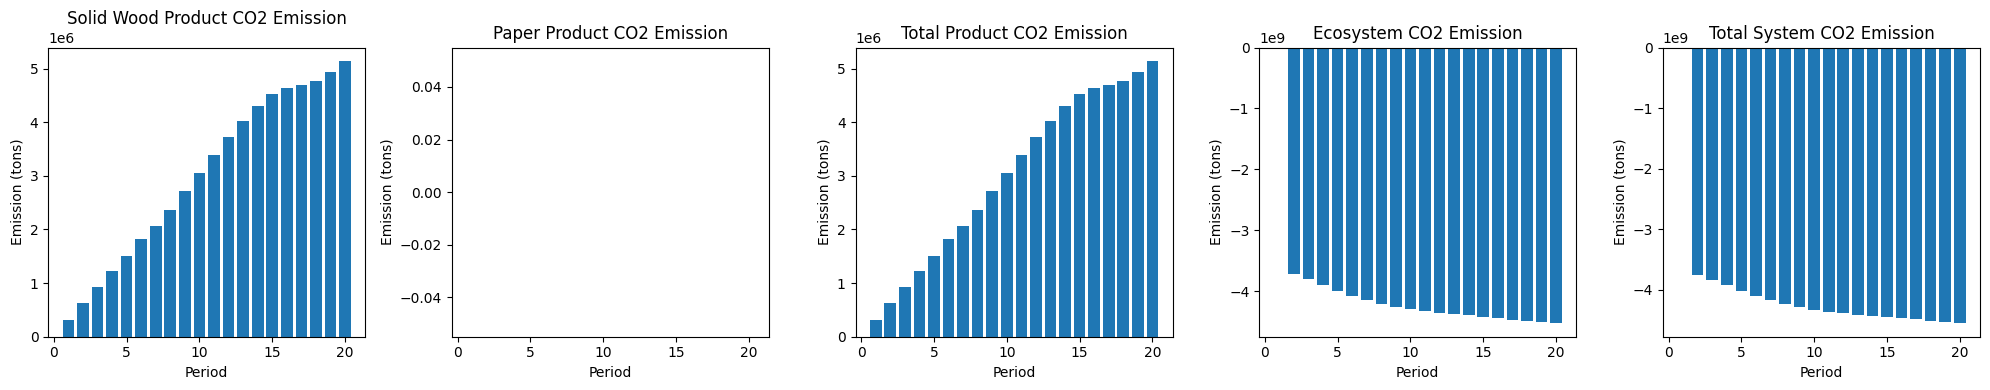

In [109]:
track_system_emission(fm)

running base scenario
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (linux64)

CPU model: Intel Xeon Processor (Skylake, IBRS), instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 16 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 810 rows, 45499 columns and 486195 nonzeros
Model fingerprint: 0xd716e8db
Coefficient statistics:
  Matrix range     [2e-01, 1e+05]
  Objective range  [4e+02, 6e+07]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+00]
Presolve removed 332 rows and 330 columns
Presolve time: 0.26s
Presolved: 478 rows, 45169 columns, 470823 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 1.669e+04
 Factor NZ  : 2.218e+04 (roughly 20 MB of memory)
 Factor Ops : 1.107e+06 (less than 1 second per iteration)
 Threads    : 14

Barrier performed 0 iterations in 0.74 seconds (0.15 work units)
Barrier solve interrupte

(<Figure size 1200x400 with 5 Axes>,
     period           oha           ohv           ogs           ocp  \
 0        1  93321.177700  2.357764e+07  7.216664e+08  1.375004e+09   
 1        2  97987.236585  2.607020e+07  7.543358e+08  1.383809e+09   
 2        3  97987.236585  2.709662e+07  7.965140e+08  1.404152e+09   
 3        4  97987.236585  2.722945e+07  8.494050e+08  1.430846e+09   
 4        5  97987.236585  2.795102e+07  9.070405e+08  1.458768e+09   
 5        6  97987.236585  2.652118e+07  9.635904e+08  1.485399e+09   
 6        7  97987.236585  3.028812e+07  1.007668e+09  1.509273e+09   
 7        8  97987.236585  2.278374e+07  1.051600e+09  1.528732e+09   
 8        9  97987.236585  2.314241e+07  1.088140e+09  1.546012e+09   
 9       10  97987.236585  3.177245e+07  1.108076e+09  1.560734e+09   
 10      11  97987.236585  3.218717e+07  1.123093e+09  1.572086e+09   
 11      12  88655.118815  3.293994e+07  1.134095e+09  1.581403e+09   
 12      13  88655.118815  3.179979e+07 

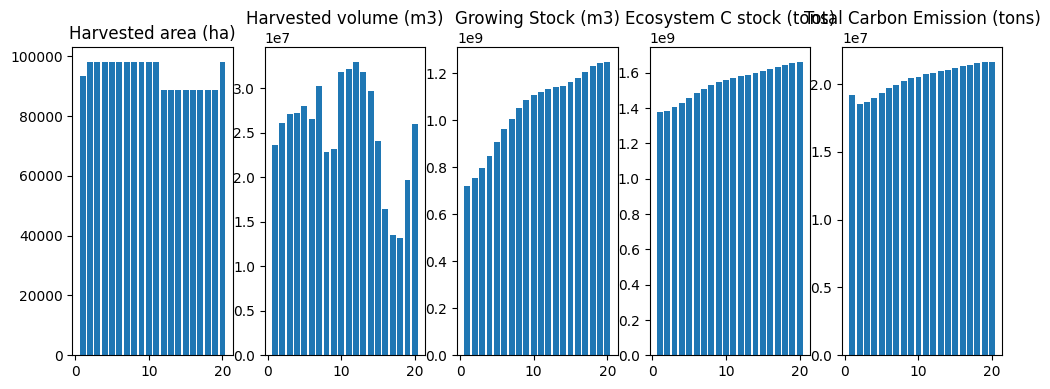

In [109]:
# product_info = {
#     "solid_wood": (1, 100),  # proportion, half-life
#     "paper": (0, 2)
# }

run_scenario(fm,'base')

(<Figure size 2000x400 with 5 Axes>,
 array([<Axes: title={'center': 'Solid Wood Product C Stock'}, xlabel='Period', ylabel='Stock (tons)'>,
        <Axes: title={'center': 'Paper Product C Stock'}, xlabel='Period', ylabel='Stock (tons)'>,
        <Axes: title={'center': 'Total Product C Stock'}, xlabel='Period', ylabel='Stock (tons)'>,
        <Axes: title={'center': 'Ecosystem C Stock'}, xlabel='Period', ylabel='Stock (tons)'>,
        <Axes: title={'center': 'Total System C Stock'}, xlabel='Period', ylabel='Stock (tons)'>],
       dtype=object),
     period    solid_wood  paper   sum_product     ecosystem        system
 0        1  5.385268e+06    0.0  5.385268e+06  1.375004e+09  1.380389e+09
 1        2  1.130252e+07    0.0  1.130252e+07  1.383809e+09  1.395111e+09
 2        3  1.741320e+07    0.0  1.741320e+07  1.404152e+09  1.421565e+09
 3        4  2.351187e+07    0.0  2.351187e+07  1.430846e+09  1.454358e+09
 4        5  2.973307e+07    0.0  2.973307e+07  1.458768e+09  1.488501

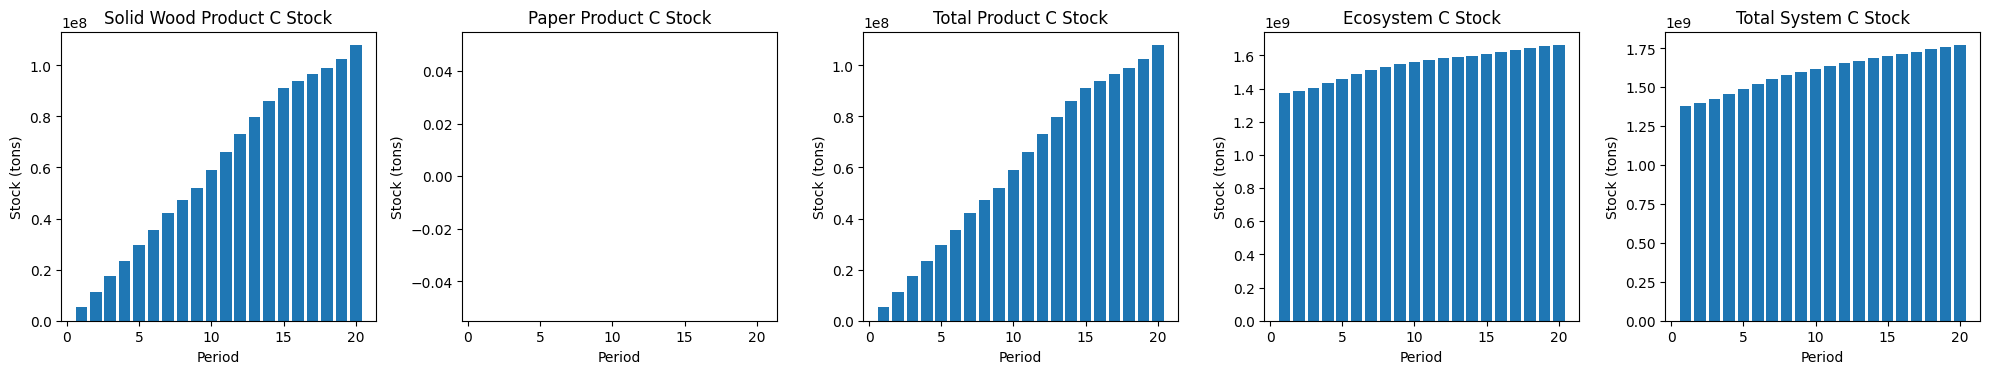

In [110]:
track_system_stock(fm)

(<Figure size 2000x400 with 5 Axes>,
 array([<Axes: title={'center': 'Solid Wood Product CO2 Emission'}, xlabel='Period', ylabel='Emission (tons)'>,
        <Axes: title={'center': 'Paper Product CO2 Emission'}, xlabel='Period', ylabel='Emission (tons)'>,
        <Axes: title={'center': 'Total Product CO2 Emission'}, xlabel='Period', ylabel='Emission (tons)'>,
        <Axes: title={'center': 'Ecosystem CO2 Emission'}, xlabel='Period', ylabel='Emission (tons)'>,
        <Axes: title={'center': 'Total System CO2 Emission'}, xlabel='Period', ylabel='Emission (tons)'>],
       dtype=object),
     period    solid_wood  paper   sum_product     ecosystem        system
 0        1  1.378240e+05    0.0  1.378240e+05  0.000000e+00 -4.360655e+07
 1        2  2.892631e+05    0.0  2.892631e+05 -3.698961e+09 -3.747041e+09
 2        3  4.456525e+05    0.0  4.456525e+05 -3.764747e+09 -3.814575e+09
 3        4  6.017343e+05    0.0  6.017343e+05 -3.842284e+09 -3.892201e+09
 4        5  7.609523e+05    0

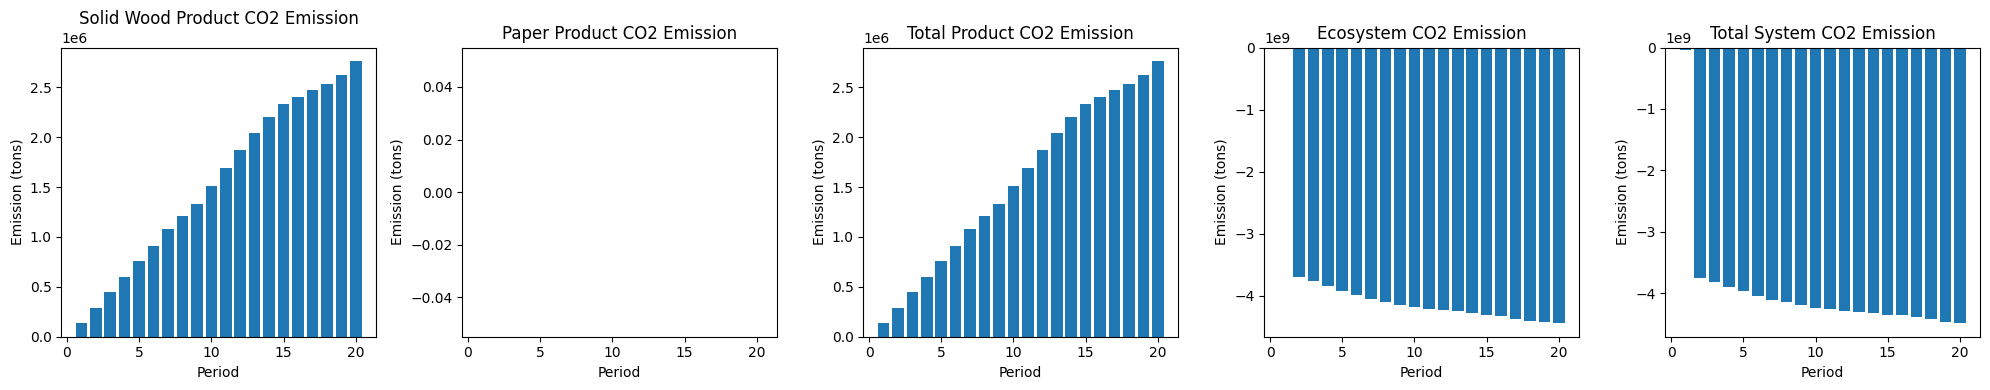

In [111]:
track_system_emission(fm)

## Minimize Net System Carbon Emission without Even-flow Constraints

running base scenario
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (linux64)

CPU model: Intel Xeon Processor (Skylake, IBRS), instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 16 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 810 rows, 45499 columns and 486195 nonzeros
Model fingerprint: 0x57ddd9e8
Coefficient statistics:
  Matrix range     [2e-01, 1e+05]
  Objective range  [7e+03, 8e+08]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+00]
Presolve removed 332 rows and 330 columns
Presolve time: 0.25s
Presolved: 478 rows, 45169 columns, 470823 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 1.669e+04
 Factor NZ  : 2.218e+04 (roughly 20 MB of memory)
 Factor Ops : 1.107e+06 (less than 1 second per iteration)
 Threads    : 14

Barrier performed 0 iterations in 0.48 seconds (0.14 work units)
Barrier solve interrupte

(<Figure size 1200x400 with 5 Axes>,
     period  oha  ohv           ogs           ocp           ocf
 0        1  0.0  0.0  7.494048e+08  1.381789e+09  1.954011e+07
 1        2  0.0  0.0  8.124675e+08  1.402196e+09  1.894992e+07
 2        3  0.0  0.0  8.861458e+08  1.436742e+09  1.921555e+07
 3        4  0.0  0.0  9.707337e+08  1.478353e+09  1.975706e+07
 4        5  0.0  0.0  1.060630e+09  1.521575e+09  2.033804e+07
 5        6  0.0  0.0  1.146251e+09  1.561899e+09  2.085700e+07
 6        7  0.0  0.0  1.219698e+09  1.597082e+09  2.128955e+07
 7        8  0.0  0.0  1.278276e+09  1.626686e+09  2.164259e+07
 8        9  0.0  0.0  1.322490e+09  1.651037e+09  2.192896e+07
 9       10  0.0  0.0  1.354309e+09  1.670935e+09  2.216033e+07
 10      11  0.0  0.0  1.376027e+09  1.687321e+09  2.234828e+07
 11      12  0.0  0.0  1.389710e+09  1.700760e+09  2.250060e+07
 12      13  0.0  0.0  1.397148e+09  1.711820e+09  2.262491e+07
 13      14  0.0  0.0  1.399821e+09  1.721052e+09  2.272777e+07
 14

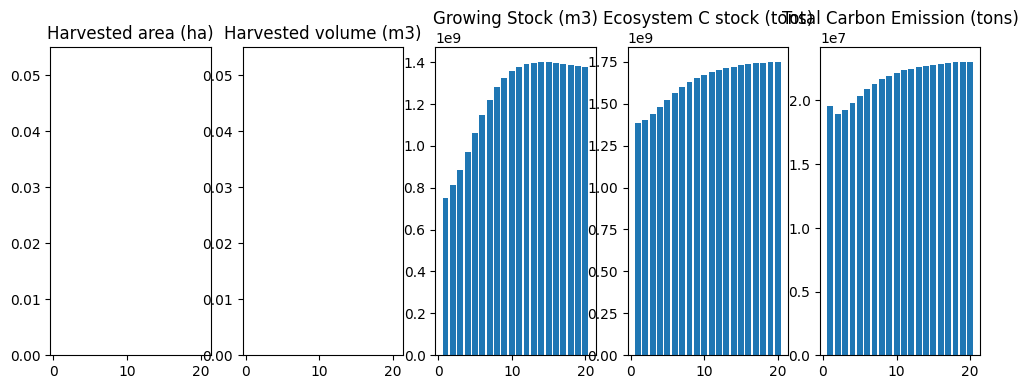

In [242]:
# product_info = {
#     "solid_wood": (0, 30),  # proportion, half-life
#     "paper": (1, 2)
# }
# Displacement factor = 2.2
run_scenario(fm,'base')

running base scenario
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (linux64)

CPU model: Intel Xeon Processor (Skylake, IBRS), instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 16 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 770 rows, 45499 columns and 45499 nonzeros
Model fingerprint: 0x9c3a3f0d
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [7e+03, 8e+08]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+00]
Presolve removed 770 rows and 45499 columns
Presolve time: 0.04s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.1632977e+10   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.06 seconds (0.01 work units)
Optimal objective -3.163297726e+10
foo


(<Figure size 1200x400 with 5 Axes>,
     period        oha           ohv           ogs           ocp           ocf
 0        1        0.0  0.000000e+00  7.494048e+08  1.381789e+09  1.954011e+07
 1        2        0.0  0.000000e+00  8.124675e+08  1.402196e+09  1.894992e+07
 2        3        0.0  0.000000e+00  8.861458e+08  1.436742e+09  1.921555e+07
 3        4        0.0  0.000000e+00  9.707337e+08  1.478353e+09  1.975706e+07
 4        5        0.0  0.000000e+00  1.060630e+09  1.521575e+09  2.033804e+07
 5        6        0.0  0.000000e+00  1.146251e+09  1.561899e+09  2.085700e+07
 6        7        0.0  0.000000e+00  1.219698e+09  1.597082e+09  2.128955e+07
 7        8        0.0  0.000000e+00  1.278276e+09  1.626686e+09  2.164259e+07
 8        9        0.0  0.000000e+00  1.322490e+09  1.651037e+09  2.192896e+07
 9       10        0.0  0.000000e+00  1.354309e+09  1.670935e+09  2.216033e+07
 10      11        0.0  0.000000e+00  1.376027e+09  1.687321e+09  2.234828e+07
 11      12    

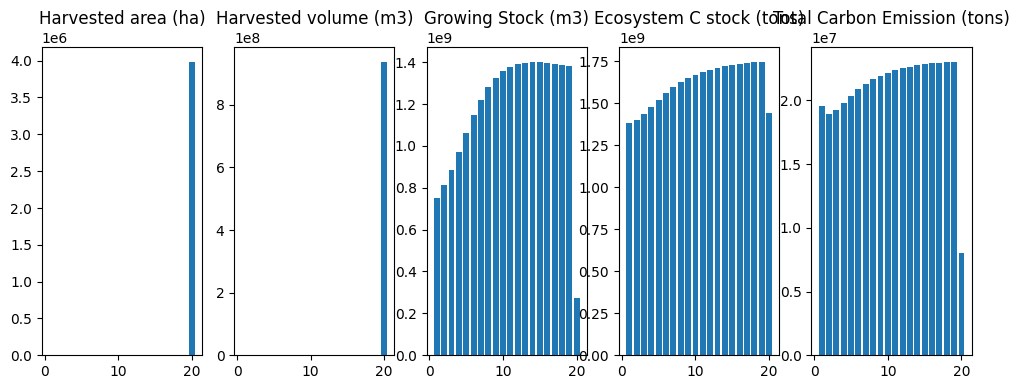

In [193]:
# product_info = {
#     "solid_wood": (0.5, 30),  # proportion, half-life
#     "paper": (0.5, 2)
# }
# Displacement factor = 2.2
run_scenario(fm,'base')

(<Figure size 2000x400 with 5 Axes>,
 array([<Axes: title={'center': 'Solid Wood Product C Stock'}, xlabel='Period', ylabel='Stock (tons)'>,
        <Axes: title={'center': 'Paper Product C Stock'}, xlabel='Period', ylabel='Stock (tons)'>,
        <Axes: title={'center': 'Total Product C Stock'}, xlabel='Period', ylabel='Stock (tons)'>,
        <Axes: title={'center': 'Ecosystem C Stock'}, xlabel='Period', ylabel='Stock (tons)'>,
        <Axes: title={'center': 'Total System C Stock'}, xlabel='Period', ylabel='Stock (tons)'>],
       dtype=object),
     period    solid_wood         paper   sum_product     ecosystem  \
 0        1  0.000000e+00  0.000000e+00  0.000000e+00  1.381789e+09   
 1        2  0.000000e+00  0.000000e+00  0.000000e+00  1.402196e+09   
 2        3  0.000000e+00  0.000000e+00  0.000000e+00  1.436742e+09   
 3        4  0.000000e+00  0.000000e+00  0.000000e+00  1.478353e+09   
 4        5  0.000000e+00  0.000000e+00  0.000000e+00  1.521575e+09   
 5        6  0.0000

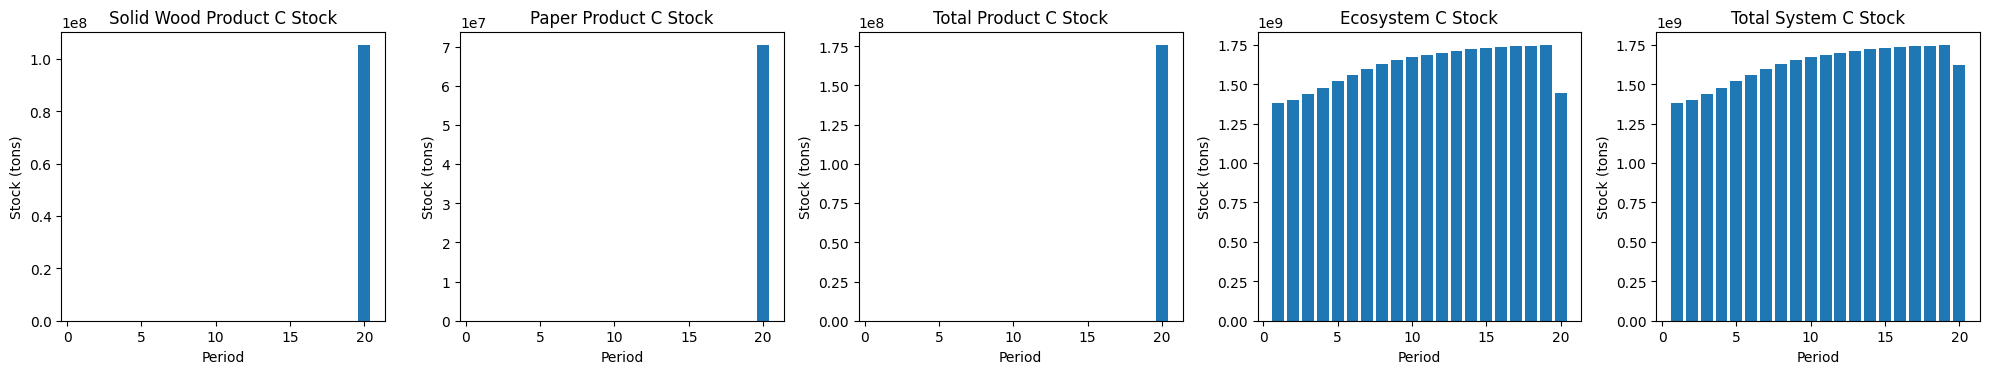

In [194]:
track_system_stock(fm)

(<Figure size 2000x400 with 5 Axes>,
 array([<Axes: title={'center': 'Solid Wood Product CO2 Emission'}, xlabel='Period', ylabel='Emission (tons)'>,
        <Axes: title={'center': 'Paper Product CO2 Emission'}, xlabel='Period', ylabel='Emission (tons)'>,
        <Axes: title={'center': 'Total Product CO2 Emission'}, xlabel='Period', ylabel='Emission (tons)'>,
        <Axes: title={'center': 'Ecosystem CO2 Emission'}, xlabel='Period', ylabel='Emission (tons)'>,
        <Axes: title={'center': 'Total System CO2 Emission'}, xlabel='Period', ylabel='Emission (tons)'>],
       dtype=object),
     period    solid_wood         paper   sum_product     ecosystem  \
 0        1  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
 1        2  0.000000e+00  0.000000e+00  0.000000e+00 -3.759598e+09   
 2        3  0.000000e+00  0.000000e+00  0.000000e+00 -3.865857e+09   
 3        4  0.000000e+00  0.000000e+00  0.000000e+00 -3.983884e+09   
 4        5  0.000000e+00  0.000000e+00  0.000000e

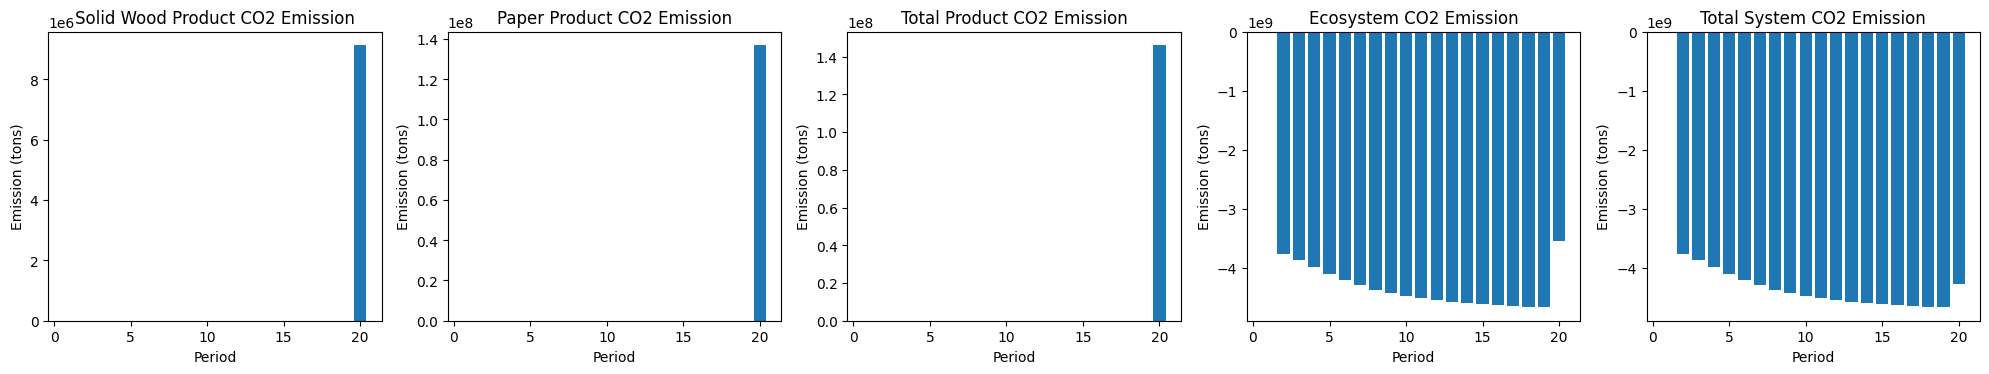

In [195]:
track_system_emission(fm)

running base scenario
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (linux64)

CPU model: Intel Xeon Processor (Skylake, IBRS), instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 16 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 770 rows, 45499 columns and 45499 nonzeros
Model fingerprint: 0x06dfba37
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [7e+03, 9e+08]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+00]
Presolve removed 770 rows and 45499 columns
Presolve time: 0.04s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.2629941e+10   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.05 seconds (0.01 work units)
Optimal objective -3.262994128e+10
foo


(<Figure size 1200x400 with 5 Axes>,
     period        oha           ohv           ogs           ocp           ocf
 0        1    17050.3  5.189091e+06  7.433000e+08  1.381061e+09  1.946911e+07
 1        2        0.0  0.000000e+00  8.061083e+08  1.400191e+09  1.895616e+07
 2        3        0.0  0.000000e+00  8.796014e+08  1.434212e+09  1.918730e+07
 3        4        0.0  0.000000e+00  9.640703e+08  1.475716e+09  1.972107e+07
 4        5        0.0  0.000000e+00  1.054419e+09  1.519141e+09  2.030528e+07
 5        6        0.0  0.000000e+00  1.141210e+09  1.559840e+09  2.083017e+07
 6        7        0.0  0.000000e+00  1.216031e+09  1.595453e+09  2.126771e+07
 7        8        0.0  0.000000e+00  1.275837e+09  1.625434e+09  2.162513e+07
 8        9        0.0  0.000000e+00  1.321126e+09  1.650113e+09  2.191539e+07
 9       10        0.0  0.000000e+00  1.353830e+09  1.670278e+09  2.215010e+07
 10      11        0.0  0.000000e+00  1.376321e+09  1.686894e+09  2.234095e+07
 11      12    

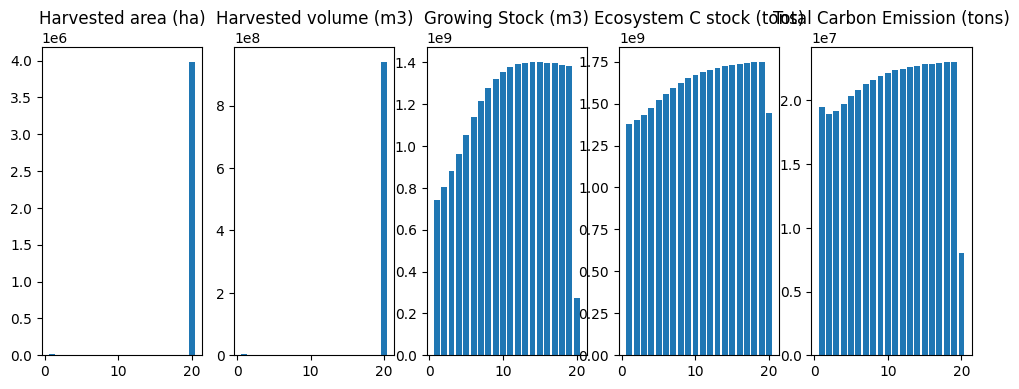

In [205]:
# product_info = {
#     "solid_wood": (1, 30),  # proportion, half-life
#     "paper": (0, 2)
# }
# Displacement factor = 2.2
run_scenario(fm,'base')

(<Figure size 2000x400 with 5 Axes>,
 array([<Axes: title={'center': 'Solid Wood Product C Stock'}, xlabel='Period', ylabel='Stock (tons)'>,
        <Axes: title={'center': 'Paper Product C Stock'}, xlabel='Period', ylabel='Stock (tons)'>,
        <Axes: title={'center': 'Total Product C Stock'}, xlabel='Period', ylabel='Stock (tons)'>,
        <Axes: title={'center': 'Ecosystem C Stock'}, xlabel='Period', ylabel='Stock (tons)'>,
        <Axes: title={'center': 'Total System C Stock'}, xlabel='Period', ylabel='Stock (tons)'>],
       dtype=object),
     period    solid_wood  paper   sum_product     ecosystem        system
 0        1  1.165915e+06    0.0  1.165915e+06  1.381061e+09  1.382227e+09
 1        2  1.138977e+06    0.0  1.138977e+06  1.400191e+09  1.401330e+09
 2        3  1.112661e+06    0.0  1.112661e+06  1.434212e+09  1.435325e+09
 3        4  1.086953e+06    0.0  1.086953e+06  1.475716e+09  1.476803e+09
 4        5  1.061839e+06    0.0  1.061839e+06  1.519141e+09  1.520202

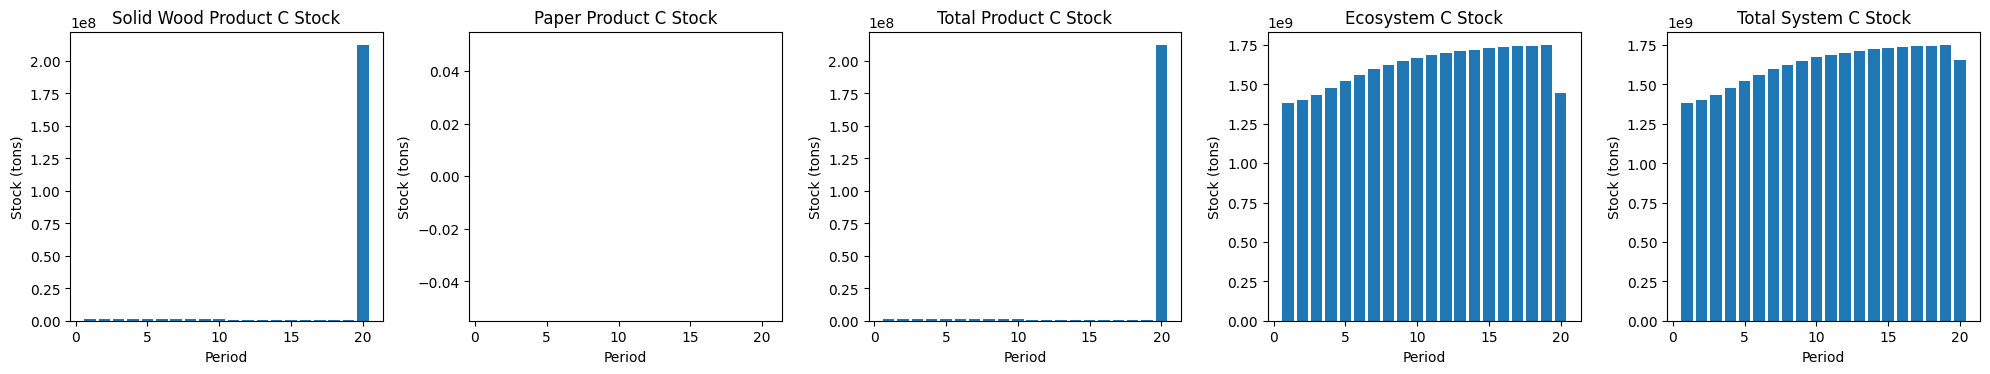

In [206]:
track_system_stock(fm)

(<Figure size 2000x400 with 5 Axes>,
 array([<Axes: title={'center': 'Solid Wood Product C Stock'}, xlabel='Period', ylabel='Stock (tons)'>,
        <Axes: title={'center': 'Paper Product C Stock'}, xlabel='Period', ylabel='Stock (tons)'>,
        <Axes: title={'center': 'Total Product C Stock'}, xlabel='Period', ylabel='Stock (tons)'>,
        <Axes: title={'center': 'Ecosystem C Stock'}, xlabel='Period', ylabel='Stock (tons)'>,
        <Axes: title={'center': 'Total System C Stock'}, xlabel='Period', ylabel='Stock (tons)'>],
       dtype=object),
     period    solid_wood  paper   sum_product     ecosystem        system
 0        1  1.165915e+06    0.0  1.165915e+06  1.381061e+09  1.382227e+09
 1        2  1.138977e+06    0.0  1.138977e+06  1.400191e+09  1.401330e+09
 2        3  1.112661e+06    0.0  1.112661e+06  1.434212e+09  1.435325e+09
 3        4  1.086953e+06    0.0  1.086953e+06  1.475716e+09  1.476803e+09
 4        5  1.061839e+06    0.0  1.061839e+06  1.519141e+09  1.520202

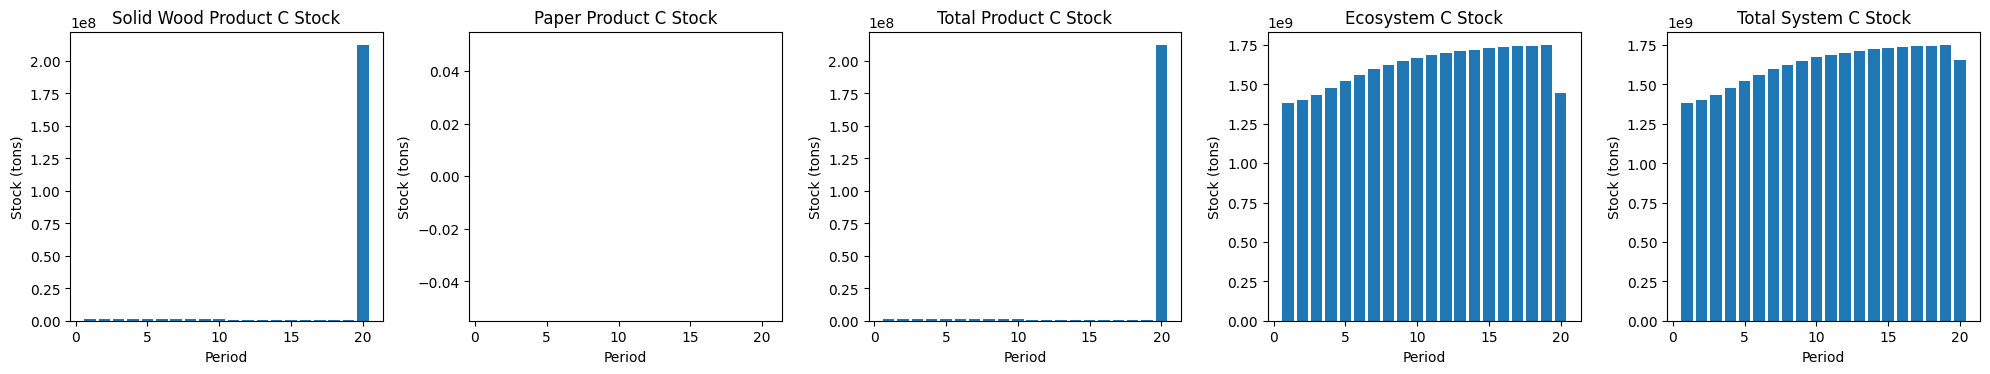

In [207]:
track_system_stock(fm)

running base scenario
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (linux64)

CPU model: Intel Xeon Processor (Skylake, IBRS), instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 16 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 770 rows, 45499 columns and 45499 nonzeros
Model fingerprint: 0x1f376cbd
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [7e+03, 9e+08]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+00]
Presolve removed 770 rows and 45499 columns
Presolve time: 0.05s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.2646041e+10   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.06 seconds (0.01 work units)
Optimal objective -3.264604080e+10
foo


(<Figure size 1200x400 with 5 Axes>,
     period        oha           ohv           ogs           ocp           ocf
 0        1    98211.5  2.737261e+07  7.172017e+08  1.378141e+09  1.913513e+07
 1        2        0.0  0.000000e+00  7.788768e+08  1.391481e+09  1.897555e+07
 2        3        0.0  0.000000e+00  8.514894e+08  1.423068e+09  1.905264e+07
 3        4        0.0  0.000000e+00  9.353187e+08  1.464024e+09  1.955364e+07
 4        5        0.0  0.000000e+00  1.027237e+09  1.508406e+09  2.015727e+07
 5        6        0.0  0.000000e+00  1.119815e+09  1.551031e+09  2.071572e+07
 6        7        0.0  0.000000e+00  1.201575e+09  1.588899e+09  2.118136e+07
 7        8        0.0  0.000000e+00  1.267450e+09  1.620826e+09  2.156297e+07
 8        9        0.0  0.000000e+00  1.317529e+09  1.647055e+09  2.187377e+07
 9       10        0.0  0.000000e+00  1.354016e+09  1.668462e+09  2.212537e+07
 10      11        0.0  0.000000e+00  1.379294e+09  1.686002e+09  2.232940e+07
 11      12    

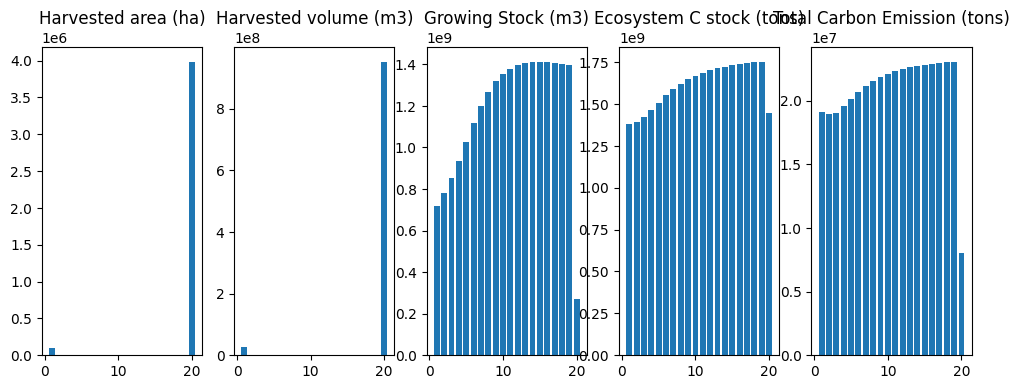

In [217]:
# product_info = {
#     "solid_wood": (1, 100),  # proportion, half-life
#     "paper": (0, 2)
# }
# Displacement factor = 2.2
run_scenario(fm,'base')

(<Figure size 2000x400 with 5 Axes>,
 array([<Axes: title={'center': 'Solid Wood Product C Stock'}, xlabel='Period', ylabel='Stock (tons)'>,
        <Axes: title={'center': 'Paper Product C Stock'}, xlabel='Period', ylabel='Stock (tons)'>,
        <Axes: title={'center': 'Total Product C Stock'}, xlabel='Period', ylabel='Stock (tons)'>,
        <Axes: title={'center': 'Ecosystem C Stock'}, xlabel='Period', ylabel='Stock (tons)'>,
        <Axes: title={'center': 'Total System C Stock'}, xlabel='Period', ylabel='Stock (tons)'>],
       dtype=object),
     period    solid_wood  paper   sum_product     ecosystem        system
 0        1  6.252062e+06    0.0  6.252062e+06  1.378141e+09  1.384393e+09
 1        2  6.208726e+06    0.0  6.208726e+06  1.391481e+09  1.397690e+09
 2        3  6.165690e+06    0.0  6.165690e+06  1.423068e+09  1.429233e+09
 3        4  6.122953e+06    0.0  6.122953e+06  1.464024e+09  1.470147e+09
 4        5  6.080512e+06    0.0  6.080512e+06  1.508406e+09  1.514487

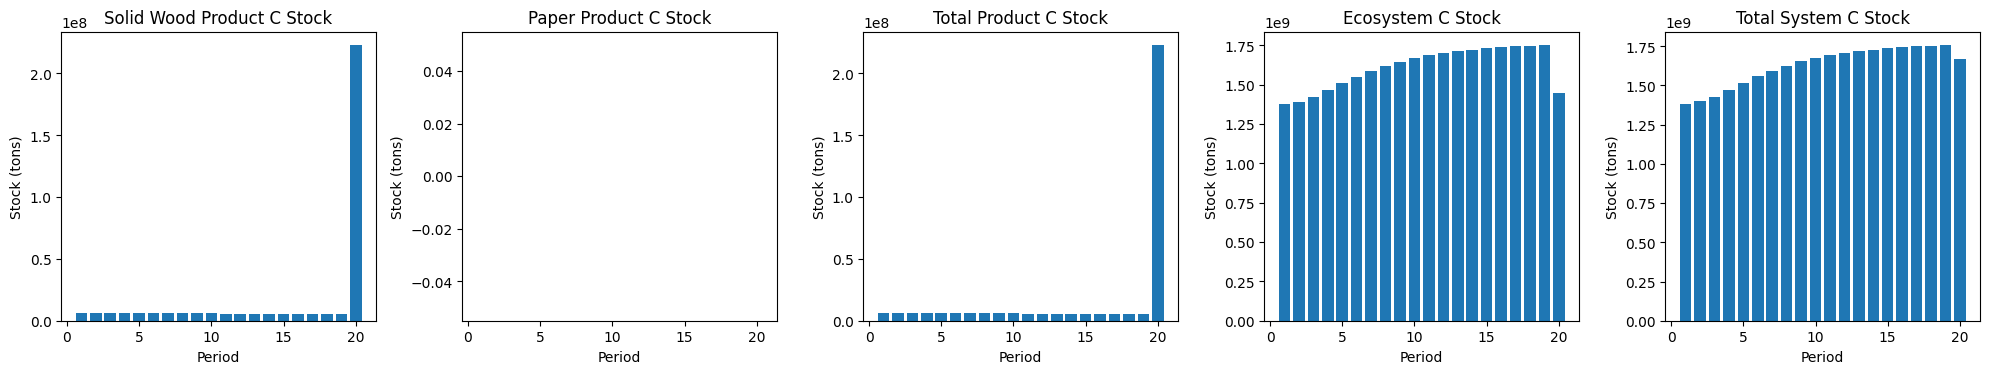

In [218]:
track_system_stock(fm)

(<Figure size 2000x400 with 5 Axes>,
 array([<Axes: title={'center': 'Solid Wood Product CO2 Emission'}, xlabel='Period', ylabel='Emission (tons)'>,
        <Axes: title={'center': 'Paper Product CO2 Emission'}, xlabel='Period', ylabel='Emission (tons)'>,
        <Axes: title={'center': 'Total Product CO2 Emission'}, xlabel='Period', ylabel='Emission (tons)'>,
        <Axes: title={'center': 'Ecosystem CO2 Emission'}, xlabel='Period', ylabel='Emission (tons)'>,
        <Axes: title={'center': 'Total System CO2 Emission'}, xlabel='Period', ylabel='Emission (tons)'>],
       dtype=object),
     period    solid_wood  paper   sum_product     ecosystem        system
 0        1  1.600077e+05    0.0  1.600077e+05  0.000000e+00 -5.062531e+07
 1        2  1.588986e+05    0.0  1.588986e+05 -3.723956e+09 -3.723797e+09
 2        3  1.577972e+05    0.0  1.577972e+05 -3.826433e+09 -3.826276e+09
 3        4  1.567035e+05    0.0  1.567035e+05 -3.945019e+09 -3.944862e+09
 4        5  1.556173e+05    0

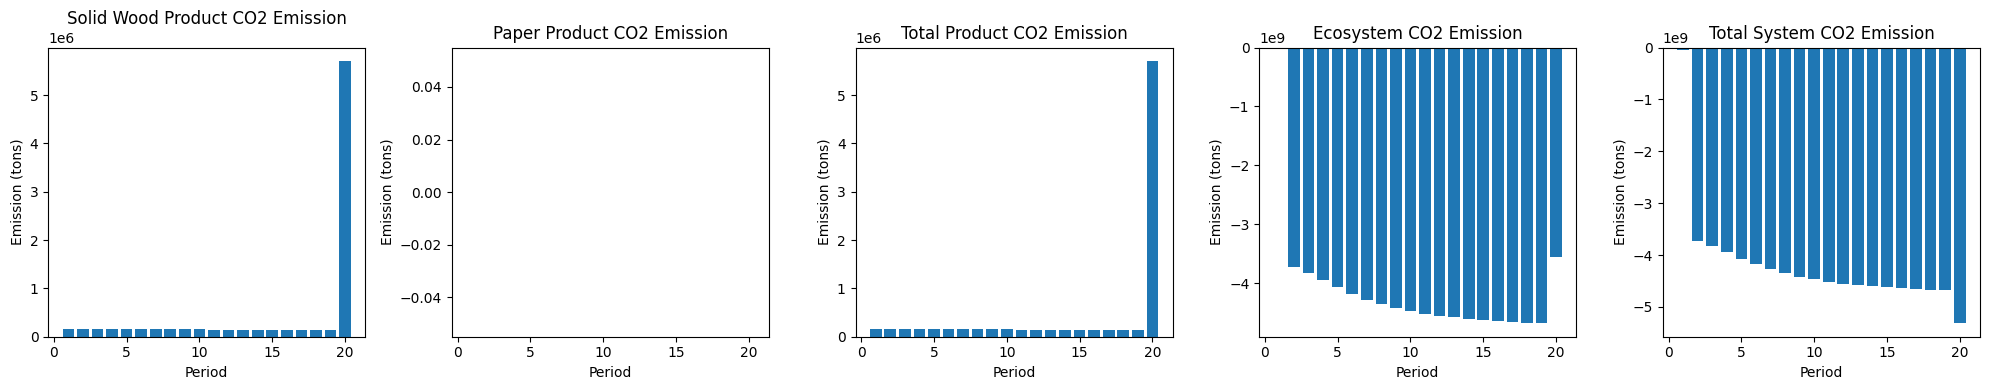

In [219]:
track_system_emission(fm)

running base scenario
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (linux64)

CPU model: Intel Xeon Processor (Skylake, IBRS), instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 16 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 770 rows, 45499 columns and 45499 nonzeros
Model fingerprint: 0x3cae8348
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [7e+03, 1e+09]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+00]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 770 rows and 45499 columns
Presolve time: 0.03s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.5123975e+10   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.04 seconds (0.02 work units)
Optimal objective -3.512397513e+10
foo


(<Figure size 1200x400 with 5 Axes>,
     period        oha           ohv           ogs           ocp           ocf
 0        1   707603.1  1.584027e+08  5.630487e+08  1.351818e+09  1.694781e+07
 1        2    31391.2  5.734745e+06  6.112967e+08  1.327255e+09  1.888383e+07
 2        3    23212.8  4.212992e+06  6.729190e+08  1.339842e+09  1.795340e+07
 3        4    12405.3  3.537681e+06  7.474417e+08  1.371473e+09  1.813828e+07
 4        5    14355.2  4.023922e+06  8.321680e+08  1.414473e+09  1.872158e+07
 5        6     2007.3  5.434263e+05  9.349033e+08  1.462452e+09  1.949794e+07
 6        7        0.0  0.000000e+00  1.041951e+09  1.510063e+09  2.016713e+07
 7        8    33054.5  1.148576e+07  1.126638e+09  1.551252e+09  2.058772e+07
 8        9   187992.1  6.328654e+07  1.135257e+09  1.575624e+09  2.042086e+07
 9       10   134566.7  4.460886e+07  1.147999e+09  1.585697e+09  2.099278e+07
 10      11        0.0  0.000000e+00  1.197101e+09  1.596901e+09  2.150076e+07
 11      12    

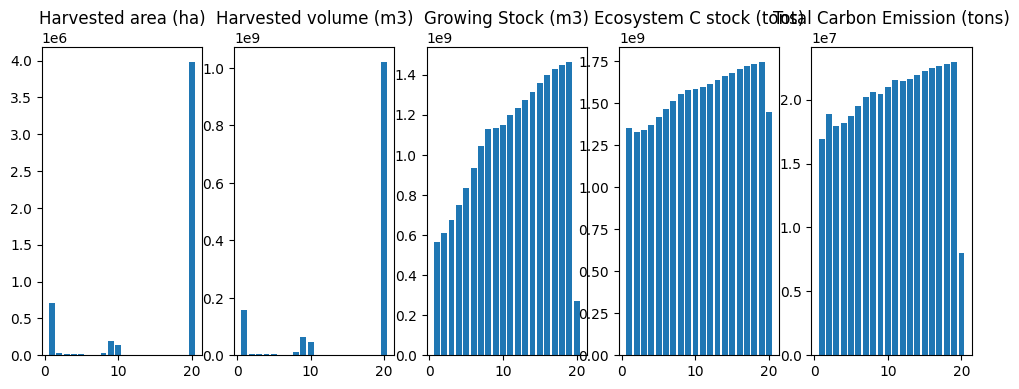

In [131]:
# product_info = {
#     "solid_wood": (1, 30),  # proportion, half-life
#     "paper": (0, 2)
# }
# Displacement factor = 5
run_scenario(fm,'base')

(<Figure size 2000x400 with 5 Axes>,
 array([<Axes: title={'center': 'Solid Wood Product C Stock'}, xlabel='Period', ylabel='Stock (tons)'>,
        <Axes: title={'center': 'Paper Product C Stock'}, xlabel='Period', ylabel='Stock (tons)'>,
        <Axes: title={'center': 'Total Product C Stock'}, xlabel='Period', ylabel='Stock (tons)'>,
        <Axes: title={'center': 'Ecosystem C Stock'}, xlabel='Period', ylabel='Stock (tons)'>,
        <Axes: title={'center': 'Total System C Stock'}, xlabel='Period', ylabel='Stock (tons)'>],
       dtype=object),
     period    solid_wood  paper   sum_product     ecosystem        system
 0        1  3.559085e+07    0.0  3.559085e+07  1.351818e+09  1.387409e+09
 1        2  3.605704e+07    0.0  3.605704e+07  1.327255e+09  1.363312e+09
 2        3  3.617054e+07    0.0  3.617054e+07  1.339842e+09  1.376013e+09
 3        4  3.612969e+07    0.0  3.612969e+07  1.371473e+09  1.407603e+09
 4        5  3.619904e+07    0.0  3.619904e+07  1.414473e+09  1.450672

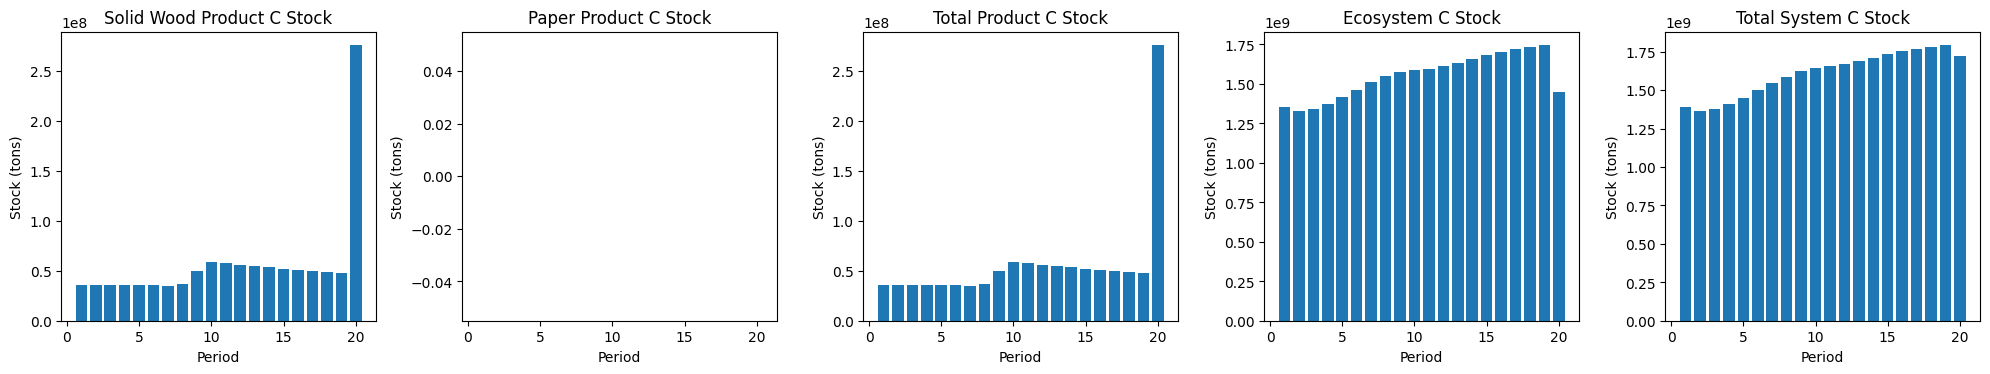

In [133]:
track_system_stock(fm)

(<Figure size 2000x400 with 5 Axes>,
 array([<Axes: title={'center': 'Solid Wood Product CO2 Emission'}, xlabel='Period', ylabel='Emission (tons)'>,
        <Axes: title={'center': 'Paper Product CO2 Emission'}, xlabel='Period', ylabel='Emission (tons)'>,
        <Axes: title={'center': 'Total Product CO2 Emission'}, xlabel='Period', ylabel='Emission (tons)'>,
        <Axes: title={'center': 'Ecosystem CO2 Emission'}, xlabel='Period', ylabel='Emission (tons)'>,
        <Axes: title={'center': 'Total System CO2 Emission'}, xlabel='Period', ylabel='Emission (tons)'>],
       dtype=object),
     period    solid_wood  paper   sum_product     ecosystem        system
 0        1  3.086498e+06    0.0  3.086498e+06  0.000000e+00 -6.648448e+08
 1        2  3.126927e+06    0.0  3.126927e+06 -3.514785e+09 -3.535840e+09
 2        3  3.136771e+06    0.0  3.136771e+06 -3.585500e+09 -3.600128e+09
 3        4  3.133228e+06    0.0  3.133228e+06 -3.688891e+09 -3.700675e+09
 4        5  3.139242e+06    0

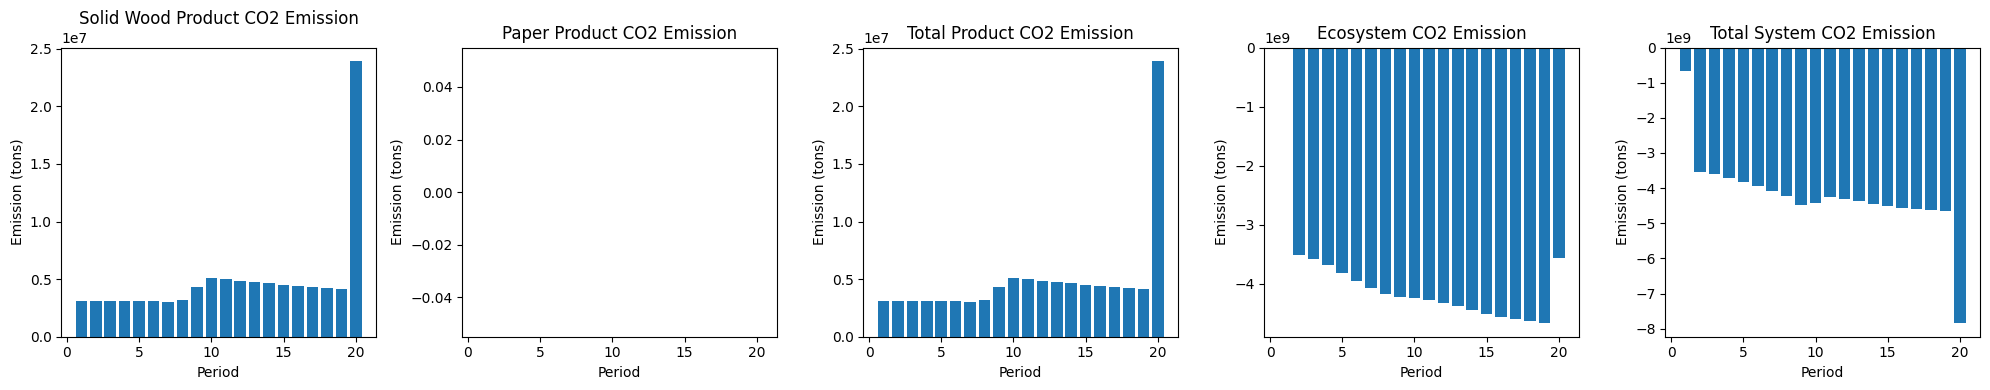

In [134]:
track_system_emission(fm)

## Minimize Net System Carbon Emission with Even-flow Constraints

running base scenario
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (linux64)

CPU model: Intel Xeon Processor (Skylake, IBRS), instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 16 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 810 rows, 45499 columns and 486195 nonzeros
Model fingerprint: 0x57ddd9e8
Coefficient statistics:
  Matrix range     [2e-01, 1e+05]
  Objective range  [7e+03, 8e+08]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+00]
Presolve removed 332 rows and 330 columns
Presolve time: 0.16s
Presolved: 478 rows, 45169 columns, 470823 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 1.669e+04
 Factor NZ  : 2.218e+04 (roughly 20 MB of memory)
 Factor Ops : 1.107e+06 (less than 1 second per iteration)
 Threads    : 14

Barrier performed 0 iterations in 0.27 seconds (0.14 work units)
Barrier solve interrupte

(<Figure size 1200x400 with 5 Axes>,
     period  oha  ohv           ogs           ocp           ocf
 0        1  0.0  0.0  7.494048e+08  1.381789e+09  1.954011e+07
 1        2  0.0  0.0  8.124675e+08  1.402196e+09  1.894992e+07
 2        3  0.0  0.0  8.861458e+08  1.436742e+09  1.921555e+07
 3        4  0.0  0.0  9.707337e+08  1.478353e+09  1.975706e+07
 4        5  0.0  0.0  1.060630e+09  1.521575e+09  2.033804e+07
 5        6  0.0  0.0  1.146251e+09  1.561899e+09  2.085700e+07
 6        7  0.0  0.0  1.219698e+09  1.597082e+09  2.128955e+07
 7        8  0.0  0.0  1.278276e+09  1.626686e+09  2.164259e+07
 8        9  0.0  0.0  1.322490e+09  1.651037e+09  2.192896e+07
 9       10  0.0  0.0  1.354309e+09  1.670935e+09  2.216033e+07
 10      11  0.0  0.0  1.376027e+09  1.687321e+09  2.234828e+07
 11      12  0.0  0.0  1.389710e+09  1.700760e+09  2.250060e+07
 12      13  0.0  0.0  1.397148e+09  1.711820e+09  2.262491e+07
 13      14  0.0  0.0  1.399821e+09  1.721052e+09  2.272777e+07
 14

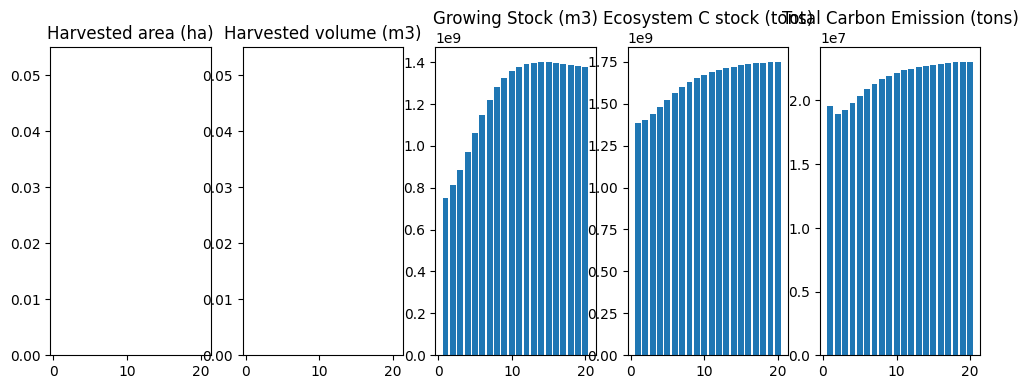

In [155]:
# product_info = {
#     "solid_wood": (0, 30),  # proportion, half-life
#     "paper": (1, 2)
# }
# Displacement factor = 2.2
run_scenario(fm,'base')

running base scenario
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (linux64)

CPU model: Intel Xeon Processor (Skylake, IBRS), instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 16 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 810 rows, 45499 columns and 486195 nonzeros
Model fingerprint: 0x22cc9311
Coefficient statistics:
  Matrix range     [2e-01, 1e+05]
  Objective range  [7e+03, 8e+08]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+00]
Presolve removed 332 rows and 330 columns
Presolve time: 0.25s
Presolved: 478 rows, 45169 columns, 470823 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 1.669e+04
 Factor NZ  : 2.218e+04 (roughly 20 MB of memory)
 Factor Ops : 1.107e+06 (less than 1 second per iteration)
 Threads    : 14

Barrier performed 0 iterations in 0.89 seconds (0.14 work units)
Barrier solve interrupte

(<Figure size 1200x400 with 5 Axes>,
     period  oha  ohv           ogs           ocp           ocf
 0        1  0.0  0.0  7.494048e+08  1.381789e+09  1.954011e+07
 1        2  0.0  0.0  8.124675e+08  1.402196e+09  1.894992e+07
 2        3  0.0  0.0  8.861458e+08  1.436742e+09  1.921555e+07
 3        4  0.0  0.0  9.707337e+08  1.478353e+09  1.975706e+07
 4        5  0.0  0.0  1.060630e+09  1.521575e+09  2.033804e+07
 5        6  0.0  0.0  1.146251e+09  1.561899e+09  2.085700e+07
 6        7  0.0  0.0  1.219698e+09  1.597082e+09  2.128955e+07
 7        8  0.0  0.0  1.278276e+09  1.626686e+09  2.164259e+07
 8        9  0.0  0.0  1.322490e+09  1.651037e+09  2.192896e+07
 9       10  0.0  0.0  1.354309e+09  1.670935e+09  2.216033e+07
 10      11  0.0  0.0  1.376027e+09  1.687321e+09  2.234828e+07
 11      12  0.0  0.0  1.389710e+09  1.700760e+09  2.250060e+07
 12      13  0.0  0.0  1.397148e+09  1.711820e+09  2.262491e+07
 13      14  0.0  0.0  1.399821e+09  1.721052e+09  2.272777e+07
 14

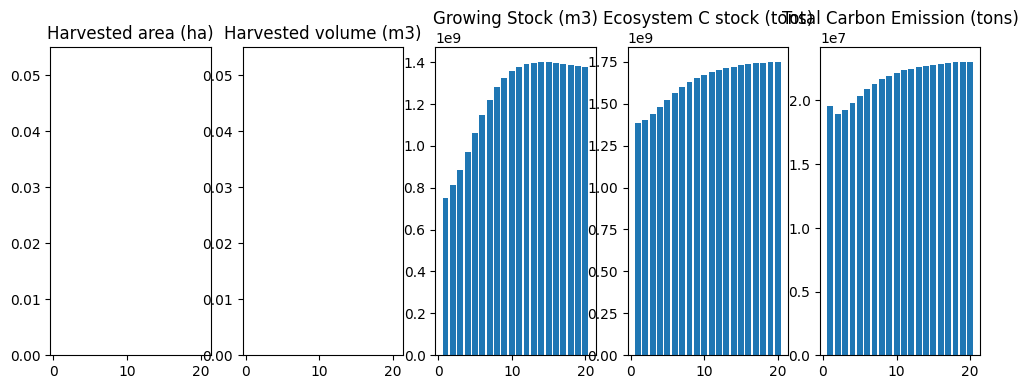

In [322]:
# product_info = {
#     "solid_wood": (0.5, 30),  # proportion, half-life
#     "paper": (0.5, 2)
# }
# Displacement factor = 2.2
run_scenario(fm,'base')

running base scenario
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (linux64)

CPU model: Intel Xeon Processor (Skylake, IBRS), instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 16 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 810 rows, 45499 columns and 486195 nonzeros
Model fingerprint: 0xde1507c0
Coefficient statistics:
  Matrix range     [2e-01, 1e+05]
  Objective range  [7e+03, 9e+08]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+00]
Presolve removed 332 rows and 330 columns
Presolve time: 0.19s
Presolved: 478 rows, 45169 columns, 470823 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 1.669e+04
 Factor NZ  : 2.218e+04 (roughly 20 MB of memory)
 Factor Ops : 1.107e+06 (less than 1 second per iteration)
 Threads    : 14

Barrier performed 0 iterations in 0.32 seconds (0.14 work units)
Barrier solve interrupte

(<Figure size 1200x400 with 5 Axes>,
     period  oha  ohv           ogs           ocp           ocf
 0        1  0.0  0.0  7.494048e+08  1.381789e+09  1.954011e+07
 1        2  0.0  0.0  8.124675e+08  1.402196e+09  1.894992e+07
 2        3  0.0  0.0  8.861458e+08  1.436742e+09  1.921555e+07
 3        4  0.0  0.0  9.707337e+08  1.478353e+09  1.975706e+07
 4        5  0.0  0.0  1.060630e+09  1.521575e+09  2.033804e+07
 5        6  0.0  0.0  1.146251e+09  1.561899e+09  2.085700e+07
 6        7  0.0  0.0  1.219698e+09  1.597082e+09  2.128955e+07
 7        8  0.0  0.0  1.278276e+09  1.626686e+09  2.164259e+07
 8        9  0.0  0.0  1.322490e+09  1.651037e+09  2.192896e+07
 9       10  0.0  0.0  1.354309e+09  1.670935e+09  2.216033e+07
 10      11  0.0  0.0  1.376027e+09  1.687321e+09  2.234828e+07
 11      12  0.0  0.0  1.389710e+09  1.700760e+09  2.250060e+07
 12      13  0.0  0.0  1.397148e+09  1.711820e+09  2.262491e+07
 13      14  0.0  0.0  1.399821e+09  1.721052e+09  2.272777e+07
 14

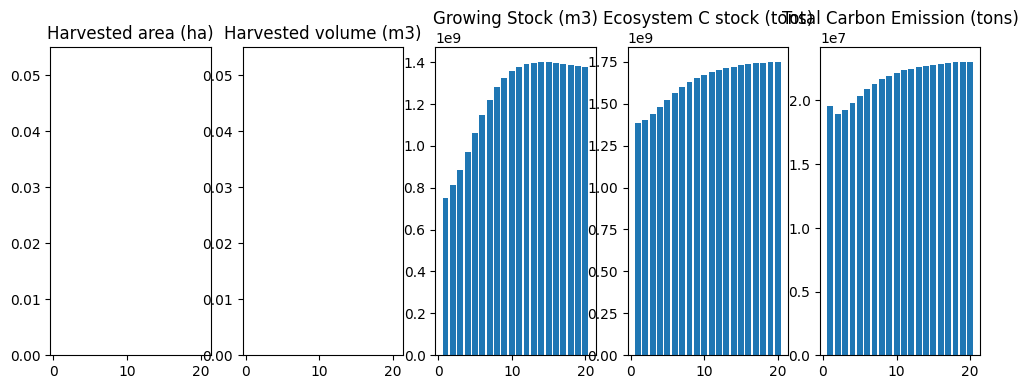

In [163]:
# product_info = {
#     "solid_wood": (1, 30),  # proportion, half-life
#     "paper": (0, 2)
# }
# Displacement factor = 2.2
run_scenario(fm,'base')

running base scenario
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (linux64)

CPU model: Intel Xeon Processor (Skylake, IBRS), instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 16 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 810 rows, 45499 columns and 486195 nonzeros
Model fingerprint: 0xa80c48cb
Coefficient statistics:
  Matrix range     [2e-01, 1e+05]
  Objective range  [7e+03, 9e+08]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+00]
Presolve removed 332 rows and 330 columns
Presolve time: 0.17s
Presolved: 478 rows, 45169 columns, 470823 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 1.669e+04
 Factor NZ  : 2.218e+04 (roughly 20 MB of memory)
 Factor Ops : 1.107e+06 (less than 1 second per iteration)
 Threads    : 14

Barrier performed 0 iterations in 0.34 seconds (0.14 work units)
Barrier solve interrupte

(<Figure size 1200x400 with 5 Axes>,
     period  oha  ohv           ogs           ocp           ocf
 0        1  0.0  0.0  7.494048e+08  1.381789e+09  1.954011e+07
 1        2  0.0  0.0  8.124675e+08  1.402196e+09  1.894992e+07
 2        3  0.0  0.0  8.861458e+08  1.436742e+09  1.921555e+07
 3        4  0.0  0.0  9.707337e+08  1.478353e+09  1.975706e+07
 4        5  0.0  0.0  1.060630e+09  1.521575e+09  2.033804e+07
 5        6  0.0  0.0  1.146251e+09  1.561899e+09  2.085700e+07
 6        7  0.0  0.0  1.219698e+09  1.597082e+09  2.128955e+07
 7        8  0.0  0.0  1.278276e+09  1.626686e+09  2.164259e+07
 8        9  0.0  0.0  1.322490e+09  1.651037e+09  2.192896e+07
 9       10  0.0  0.0  1.354309e+09  1.670935e+09  2.216033e+07
 10      11  0.0  0.0  1.376027e+09  1.687321e+09  2.234828e+07
 11      12  0.0  0.0  1.389710e+09  1.700760e+09  2.250060e+07
 12      13  0.0  0.0  1.397148e+09  1.711820e+09  2.262491e+07
 13      14  0.0  0.0  1.399821e+09  1.721052e+09  2.272777e+07
 14

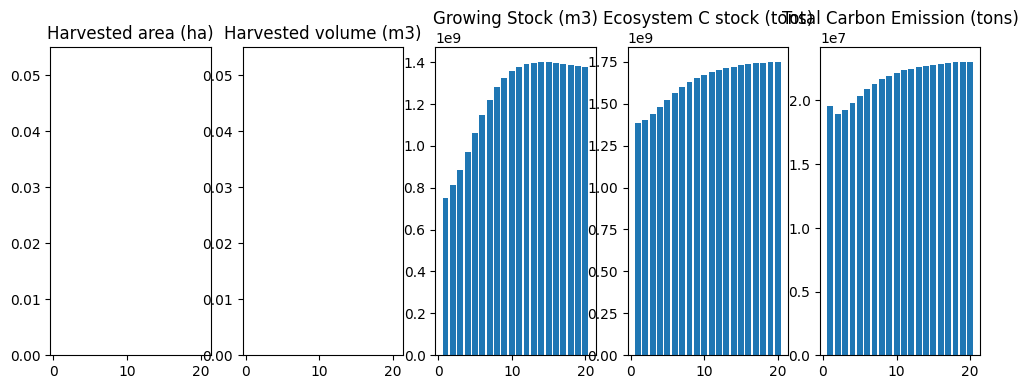

In [170]:
# product_info = {
#     "solid_wood": (1, 100),  # proportion, half-life
#     "paper": (0, 2)
# }
# Displacement factor = 2.2
run_scenario(fm,'base')

running base scenario
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (linux64)

CPU model: Intel Xeon Processor (Skylake, IBRS), instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 16 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 810 rows, 45499 columns and 486195 nonzeros
Model fingerprint: 0x205c7cac
Coefficient statistics:
  Matrix range     [2e-01, 1e+05]
  Objective range  [7e+03, 9e+08]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+00]
Presolve removed 332 rows and 330 columns
Presolve time: 0.35s
Presolved: 478 rows, 45169 columns, 470823 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 1.669e+04
 Factor NZ  : 2.218e+04 (roughly 20 MB of memory)
 Factor Ops : 1.107e+06 (less than 1 second per iteration)
 Threads    : 14

Barrier performed 0 iterations in 0.75 seconds (0.14 work units)
Barrier solve interrupte

(<Figure size 1200x400 with 5 Axes>,
     period  oha  ohv           ogs           ocp           ocf
 0        1  0.0  0.0  7.494048e+08  1.381789e+09  1.954011e+07
 1        2  0.0  0.0  8.124675e+08  1.402196e+09  1.894992e+07
 2        3  0.0  0.0  8.861458e+08  1.436742e+09  1.921555e+07
 3        4  0.0  0.0  9.707337e+08  1.478353e+09  1.975706e+07
 4        5  0.0  0.0  1.060630e+09  1.521575e+09  2.033804e+07
 5        6  0.0  0.0  1.146251e+09  1.561899e+09  2.085700e+07
 6        7  0.0  0.0  1.219698e+09  1.597082e+09  2.128955e+07
 7        8  0.0  0.0  1.278276e+09  1.626686e+09  2.164259e+07
 8        9  0.0  0.0  1.322490e+09  1.651037e+09  2.192896e+07
 9       10  0.0  0.0  1.354309e+09  1.670935e+09  2.216033e+07
 10      11  0.0  0.0  1.376027e+09  1.687321e+09  2.234828e+07
 11      12  0.0  0.0  1.389710e+09  1.700760e+09  2.250060e+07
 12      13  0.0  0.0  1.397148e+09  1.711820e+09  2.262491e+07
 13      14  0.0  0.0  1.399821e+09  1.721052e+09  2.272777e+07
 14

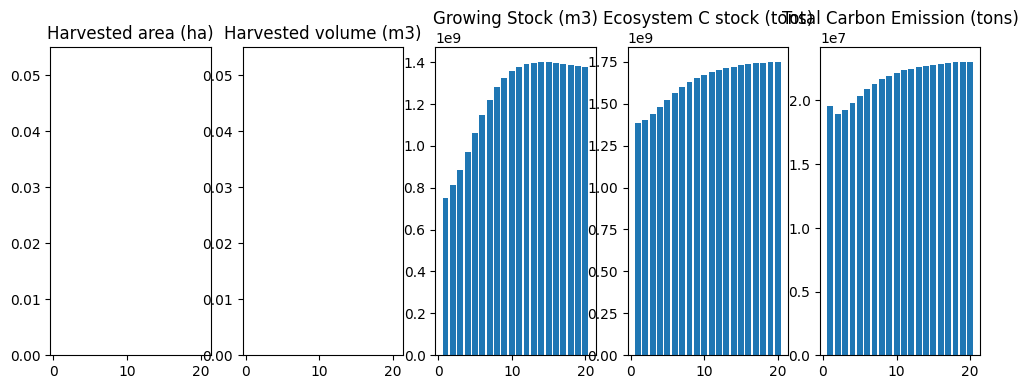

In [332]:
# product_info = {
#     "solid_wood": (0.5, 30),  # proportion, half-life
#     "paper": (0.5, 2)
# }
# Displacement factor = 5
run_scenario(fm,'base')

running base scenario
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (linux64)

CPU model: Intel Xeon Processor (Skylake, IBRS), instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 16 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 810 rows, 45499 columns and 486195 nonzeros
Model fingerprint: 0x4584d11b
Coefficient statistics:
  Matrix range     [2e-01, 1e+05]
  Objective range  [7e+03, 1e+09]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+00]
Presolve removed 332 rows and 330 columns
Presolve time: 0.26s
Presolved: 478 rows, 45169 columns, 470823 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 1.669e+04
 Factor NZ  : 2.218e+04 (roughly 20 MB of memory)
 Factor Ops : 1.107e+06 (less than 1 second per iteration)
 Threads    : 14

Barrier performed 0 iterations in 0.59 seconds (0.14 work units)
Barrier solve interrupte

(<Figure size 1200x400 with 5 Axes>,
     period           oha           ohv           ogs           ocp  \
 0        1  17265.333333  5.524618e+06  7.429052e+08  1.380784e+09   
 1        2  16402.066667  5.018486e+06  8.000572e+08  1.399221e+09   
 2        3  16402.066667  5.159057e+06  8.675329e+08  1.431180e+09   
 3        4  16402.066667  5.000701e+06  9.461895e+08  1.470379e+09   
 4        5  16402.066667  5.076348e+06  1.030467e+09  1.511270e+09   
 5        6  16402.066667  4.963727e+06  1.111925e+09  1.549775e+09   
 6        7  16402.066667  5.023834e+06  1.182495e+09  1.583610e+09   
 7        8  16402.066667  5.437285e+06  1.238970e+09  1.612093e+09   
 8        9  16402.066667  5.437285e+06  1.281912e+09  1.635587e+09   
 9       10  16402.066667  5.437285e+06  1.313193e+09  1.654844e+09   
 10      11  16402.066667  5.437285e+06  1.334948e+09  1.670745e+09   
 11      12  16402.066667  5.667324e+06  1.348864e+09  1.683704e+09   
 12      13  16402.066667  5.805621e+06 

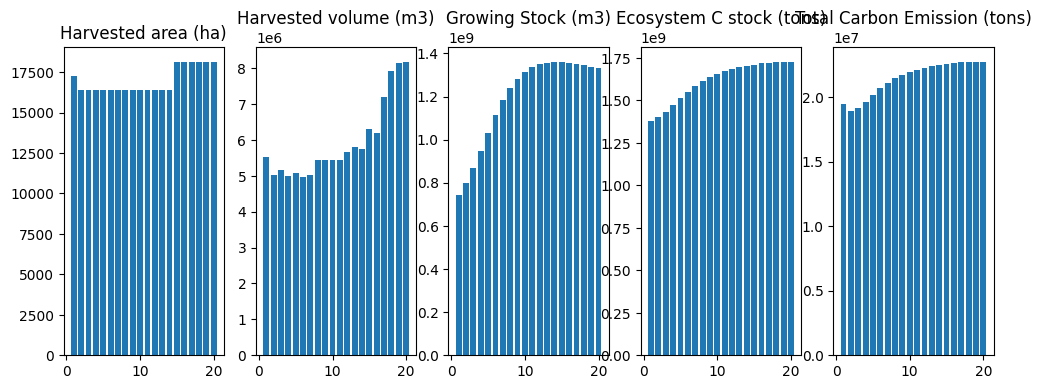

In [362]:
# product_info = {
#     "solid_wood": (0.5, 30),  # proportion, half-life
#     "paper": (0.5, 2)
# }
# Displacement factor = 7.5
run_scenario(fm,'base')

(<Figure size 2000x400 with 5 Axes>,
 array([<Axes: title={'center': 'Solid Wood Product C Stock'}, xlabel='Period', ylabel='Stock (tons)'>,
        <Axes: title={'center': 'Paper Product C Stock'}, xlabel='Period', ylabel='Stock (tons)'>,
        <Axes: title={'center': 'Total Product C Stock'}, xlabel='Period', ylabel='Stock (tons)'>,
        <Axes: title={'center': 'Ecosystem C Stock'}, xlabel='Period', ylabel='Stock (tons)'>,
        <Axes: title={'center': 'Total System C Stock'}, xlabel='Period', ylabel='Stock (tons)'>],
       dtype=object),
     period    solid_wood         paper   sum_product     ecosystem  \
 0        1  6.206518e+05  4.151421e+05  1.035794e+06  1.380784e+09   
 1        2  1.170103e+06  6.483741e+05  1.818477e+06  1.399221e+09   
 2        3  1.722652e+06  8.113371e+05  2.533989e+06  1.431180e+09   
 3        4  2.244643e+06  9.059220e+05  3.150565e+06  1.470379e+09   
 4        5  2.763073e+06  9.734106e+05  3.736484e+06  1.511270e+09   
 5        6  3.2568

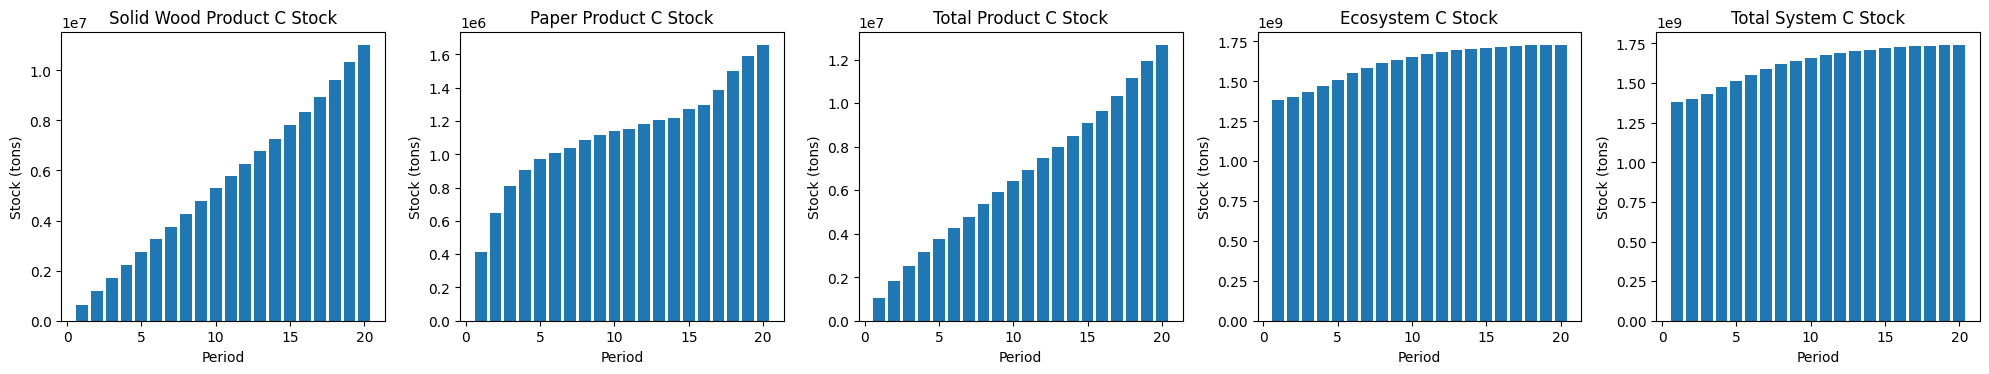

In [364]:
track_system_stock(fm)

(<Figure size 2000x400 with 5 Axes>,
 array([<Axes: title={'center': 'Solid Wood Product CO2 Emission'}, xlabel='Period', ylabel='Emission (tons)'>,
        <Axes: title={'center': 'Paper Product CO2 Emission'}, xlabel='Period', ylabel='Emission (tons)'>,
        <Axes: title={'center': 'Total Product CO2 Emission'}, xlabel='Period', ylabel='Emission (tons)'>,
        <Axes: title={'center': 'Ecosystem CO2 Emission'}, xlabel='Period', ylabel='Emission (tons)'>,
        <Axes: title={'center': 'Total System CO2 Emission'}, xlabel='Period', ylabel='Emission (tons)'>],
       dtype=object),
     period     solid_wood         paper   sum_product     ecosystem  \
 0        1   53823.969011  8.073595e+05  8.611835e+05  0.000000e+00   
 1        2  101473.312243  1.260944e+06  1.362417e+06 -3.749693e+09   
 2        3  149391.251153  1.577871e+06  1.727263e+06 -3.848441e+09   
 3        4  194659.257977  1.761818e+06  1.956477e+06 -3.960209e+09   
 4        5  239618.342576  1.893068e+06  2.1

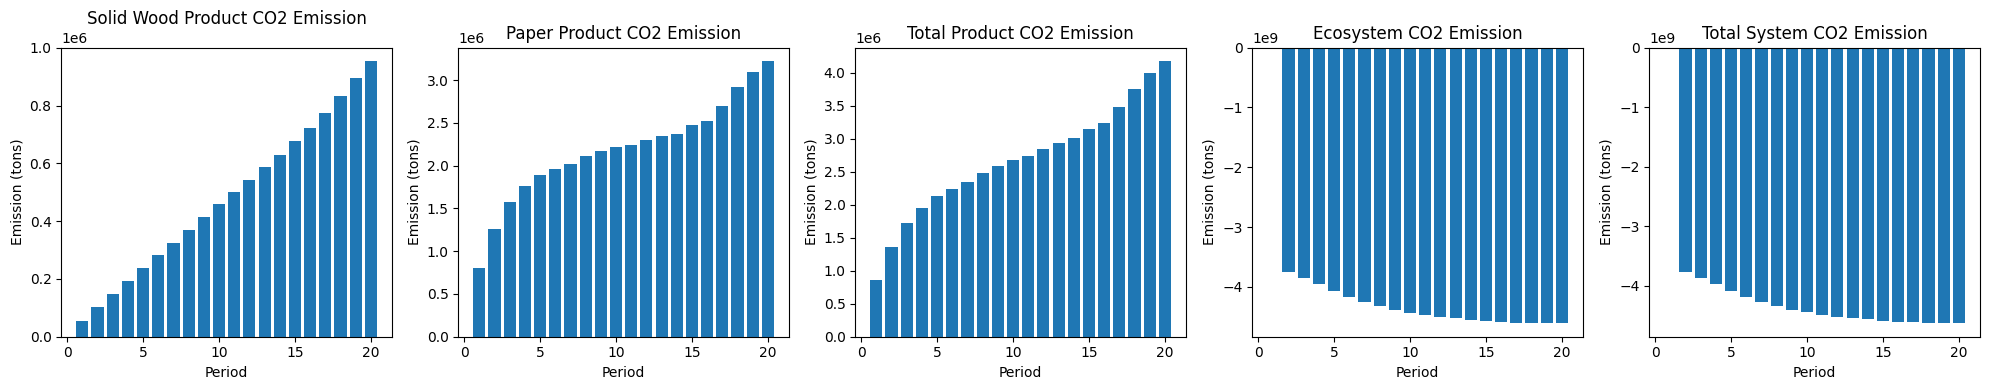

In [365]:
track_system_emission(fm)

running base scenario
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (linux64)

CPU model: Intel Xeon Processor (Skylake, IBRS), instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 16 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 810 rows, 45499 columns and 486195 nonzeros
Model fingerprint: 0x0a941cd5
Coefficient statistics:
  Matrix range     [2e-01, 1e+05]
  Objective range  [7e+03, 1e+09]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+00]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 332 rows and 330 columns
Presolve time: 0.26s
Presolved: 478 rows, 45169 columns, 470823 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 1.669e+04
 Factor NZ  : 2.218e+04 (roughly 20 MB of memory)
 Factor Ops : 1.107e+06 (less than 1 second per iteration)

(<Figure size 1200x400 with 5 Axes>,
     period            oha           ohv           ogs           ocp  \
 0        1  137776.354167  3.949737e+07  7.029373e+08  1.372406e+09   
 1        2  130887.536458  3.511029e+07  7.248862e+08  1.377971e+09   
 2        3  130887.536458  3.206263e+07  7.600269e+08  1.393712e+09   
 3        4  130887.536458  2.472075e+07  8.142792e+08  1.417665e+09   
 4        5  130887.536458  2.923445e+07  8.698483e+08  1.445027e+09   
 5        6  130887.536458  3.625242e+07  9.182117e+08  1.470533e+09   
 6        7  130887.536458  3.687117e+07  9.600797e+08  1.493132e+09   
 7        8  130887.536458  3.699209e+07  9.900859e+08  1.511044e+09   
 8        9  130887.536458  3.332733e+07  1.011762e+09  1.522304e+09   
 9       10  130887.536458  2.604265e+07  1.037571e+09  1.535600e+09   
 10      11  130887.536458  3.705091e+07  1.050093e+09  1.547401e+09   
 11      12  130887.536458  3.512635e+07  1.065817e+09  1.557353e+09   
 12      13  130887.536458 

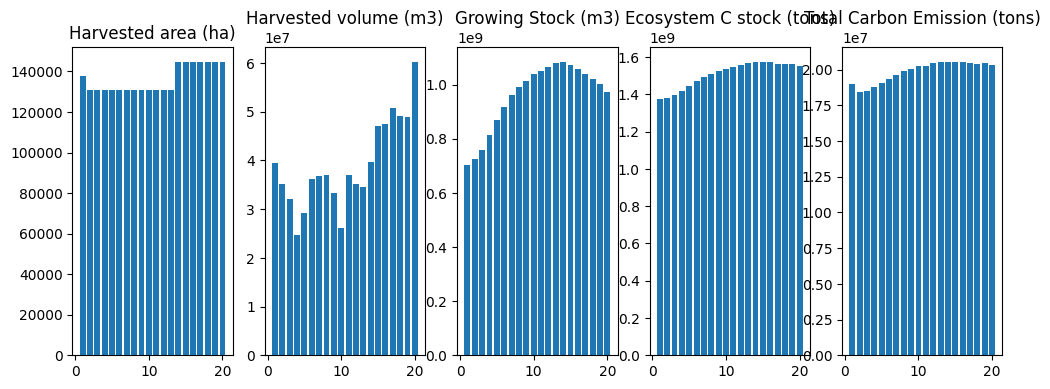

In [375]:
# product_info = {
#     "solid_wood": (0.5, 30),  # proportion, half-life
#     "paper": (0.5, 2)
# }
# Displacement factor = 10
run_scenario(fm,'base')

(<Figure size 2000x400 with 5 Axes>,
 array([<Axes: title={'center': 'Solid Wood Product C Stock'}, xlabel='Period', ylabel='Stock (tons)'>,
        <Axes: title={'center': 'Paper Product C Stock'}, xlabel='Period', ylabel='Stock (tons)'>,
        <Axes: title={'center': 'Total Product C Stock'}, xlabel='Period', ylabel='Stock (tons)'>,
        <Axes: title={'center': 'Ecosystem C Stock'}, xlabel='Period', ylabel='Stock (tons)'>,
        <Axes: title={'center': 'Total System C Stock'}, xlabel='Period', ylabel='Stock (tons)'>],
       dtype=object),
     period    solid_wood         paper   sum_product     ecosystem  \
 0        1  4.437250e+06  2.967992e+06  7.405242e+06  1.372406e+09   
 1        2  8.279121e+06  4.577693e+06  1.285681e+07  1.377971e+09   
 2        3  1.168984e+07  5.400502e+06  1.709035e+07  1.393712e+09   
 3        4  1.419695e+07  5.386447e+06  1.958340e+07  1.417665e+09   
 4        5  1.715322e+07  5.716442e+06  2.286966e+07  1.445027e+09   
 5        6  2.0829

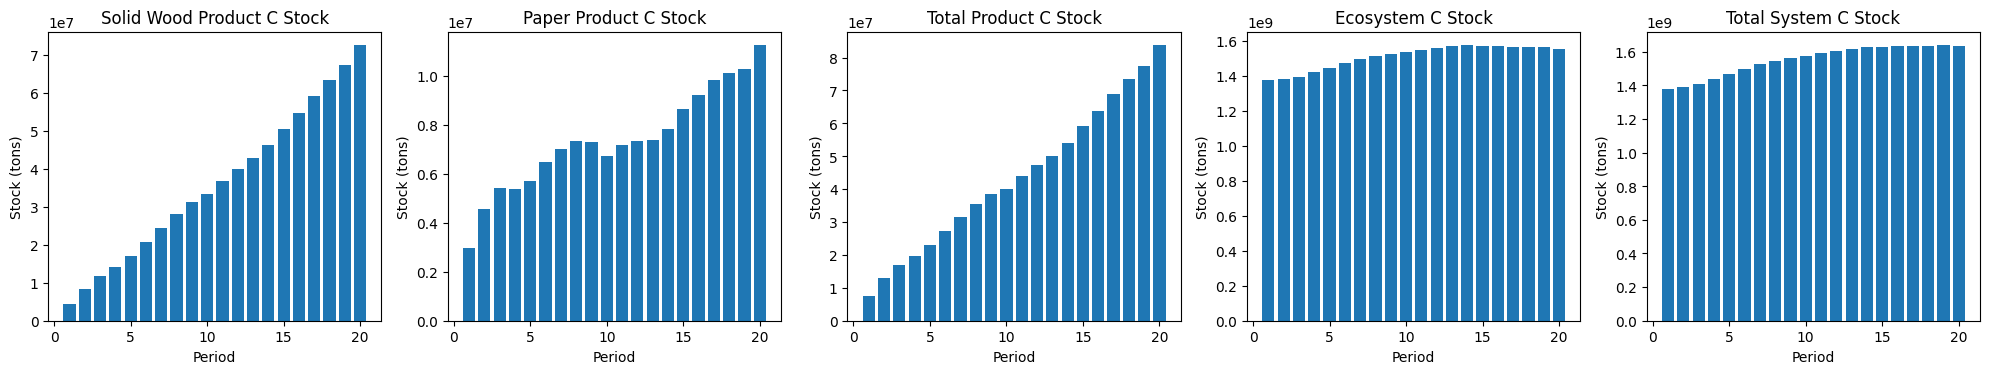

In [376]:
track_system_stock(fm)

(<Figure size 2000x400 with 5 Axes>,
 array([<Axes: title={'center': 'Solid Wood Product CO2 Emission'}, xlabel='Period', ylabel='Emission (tons)'>,
        <Axes: title={'center': 'Paper Product CO2 Emission'}, xlabel='Period', ylabel='Emission (tons)'>,
        <Axes: title={'center': 'Total Product CO2 Emission'}, xlabel='Period', ylabel='Emission (tons)'>,
        <Axes: title={'center': 'Ecosystem CO2 Emission'}, xlabel='Period', ylabel='Emission (tons)'>,
        <Axes: title={'center': 'Total System CO2 Emission'}, xlabel='Period', ylabel='Emission (tons)'>],
       dtype=object),
     period    solid_wood         paper   sum_product     ecosystem  \
 0        1  3.848058e+05  5.772087e+06  6.156893e+06  0.000000e+00   
 1        2  7.179794e+05  8.902601e+06  9.620580e+06 -3.680155e+09   
 2        3  1.013763e+06  1.050278e+07  1.151654e+07 -3.732307e+09   
 3        4  1.231184e+06  1.047545e+07  1.170663e+07 -3.804392e+09   
 4        5  1.487556e+06  1.111721e+07  1.260477e

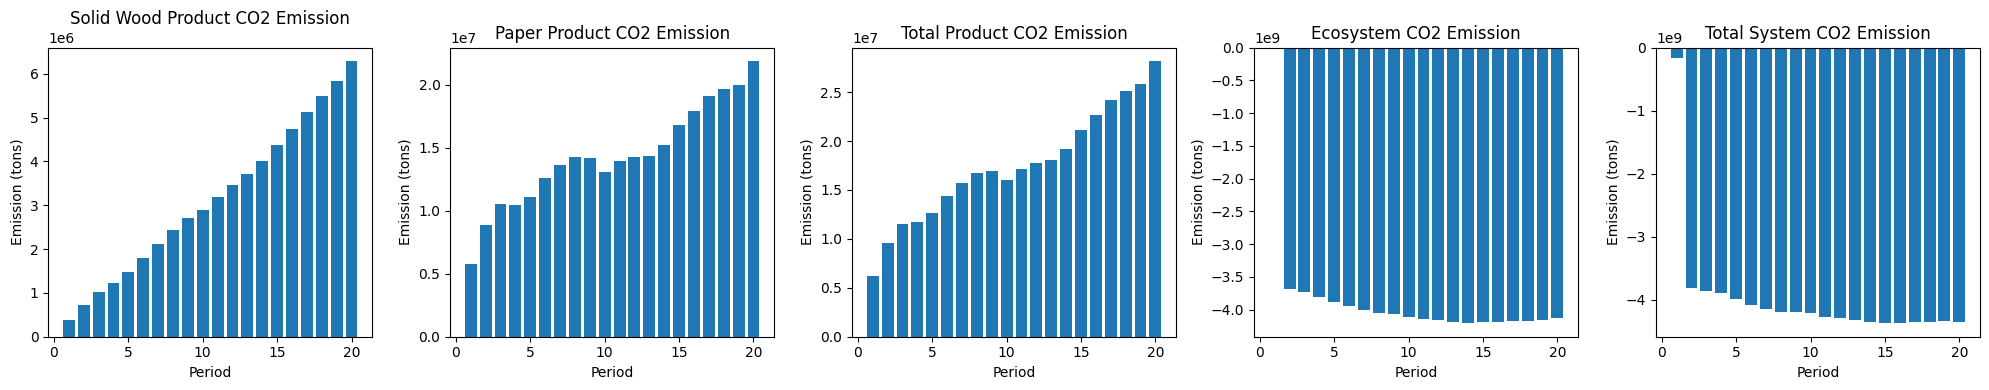

In [377]:
track_system_emission(fm)

running base scenario
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (linux64)

CPU model: Intel Xeon Processor (Skylake, IBRS), instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 16 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 810 rows, 45499 columns and 486195 nonzeros
Model fingerprint: 0x7d8ca042
Coefficient statistics:
  Matrix range     [2e-01, 1e+05]
  Objective range  [7e+03, 1e+09]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+00]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 332 rows and 330 columns
Presolve time: 0.41s
Presolved: 478 rows, 45169 columns, 470823 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 1.669e+04
 Factor NZ  : 2.218e+04 (roughly 20 MB of memory)
 Factor Ops : 1.107e+06 (less than 1 second per iteration)

(<Figure size 1200x400 with 5 Axes>,
     period            oha           ohv           ogs           ocp  \
 0        1  338700.917310  8.415612e+07  6.503976e+08  1.359511e+09   
 1        2  321765.871444  6.856900e+07  6.327651e+08  1.343609e+09   
 2        3  321765.871444  6.126905e+07  6.328307e+08  1.334783e+09   
 3        4  321765.871444  6.534447e+07  6.381613e+08  1.333596e+09   
 4        5  321765.871444  7.443653e+07  6.388580e+08  1.334568e+09   
 5        6  321765.871444  5.853080e+07  6.595728e+08  1.334147e+09   
 6        7  321765.871444  7.955173e+07  6.514407e+08  1.339140e+09   
 7        8  321765.871444  7.752308e+07  6.344026e+08  1.335502e+09   
 8        9  321765.871444  7.569152e+07  6.127392e+08  1.328416e+09   
 9       10  321765.871444  7.739278e+07  5.902629e+08  1.320418e+09   
 10      11  321765.871444  5.871006e+07  5.946072e+08  1.310104e+09   
 11      12  321765.871444  6.210358e+07  6.083954e+08  1.314620e+09   
 12      13  321765.871444 

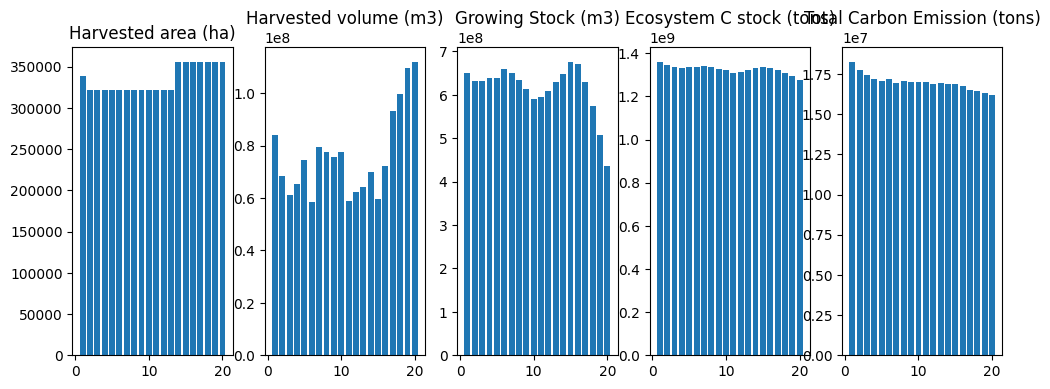

In [387]:
# product_info = {
#     "solid_wood": (0.5, 30),  # proportion, half-life
#     "paper": (0.5, 2)
# }
# Displacement factor = 20
run_scenario(fm,'base')

(<Figure size 2000x400 with 5 Axes>,
 array([<Axes: title={'center': 'Solid Wood Product C Stock'}, xlabel='Period', ylabel='Stock (tons)'>,
        <Axes: title={'center': 'Paper Product C Stock'}, xlabel='Period', ylabel='Stock (tons)'>,
        <Axes: title={'center': 'Total Product C Stock'}, xlabel='Period', ylabel='Stock (tons)'>,
        <Axes: title={'center': 'Ecosystem C Stock'}, xlabel='Period', ylabel='Stock (tons)'>,
        <Axes: title={'center': 'Total System C Stock'}, xlabel='Period', ylabel='Stock (tons)'>],
       dtype=object),
     period    solid_wood         paper   sum_product     ecosystem  \
 0        1  9.454346e+06  6.323831e+06  1.577818e+07  1.359511e+09   
 1        2  1.693915e+07  9.284709e+06  2.622386e+07  1.343609e+09   
 2        3  2.343091e+07  1.067088e+07  3.410179e+07  1.334783e+09   
 3        4  3.023053e+07  1.188288e+07  4.211342e+07  1.333596e+09   
 4        5  3.789448e+07  1.335805e+07  5.125253e+07  1.334568e+09   
 5        6  4.3594

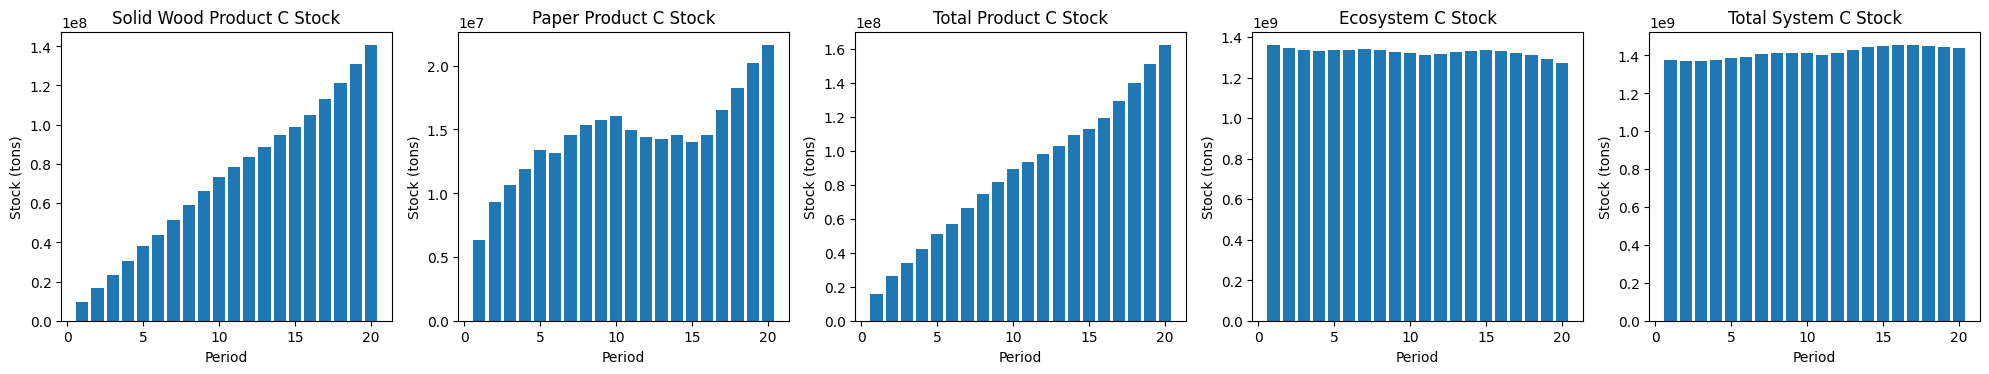

In [389]:
track_system_stock(fm)

(<Figure size 2000x400 with 5 Axes>,
 array([<Axes: title={'center': 'Solid Wood Product CO2 Emission'}, xlabel='Period', ylabel='Emission (tons)'>,
        <Axes: title={'center': 'Paper Product CO2 Emission'}, xlabel='Period', ylabel='Emission (tons)'>,
        <Axes: title={'center': 'Total Product CO2 Emission'}, xlabel='Period', ylabel='Emission (tons)'>,
        <Axes: title={'center': 'Ecosystem CO2 Emission'}, xlabel='Period', ylabel='Emission (tons)'>,
        <Axes: title={'center': 'Total System CO2 Emission'}, xlabel='Period', ylabel='Emission (tons)'>],
       dtype=object),
     period    solid_wood         paper   sum_product     ecosystem  \
 0        1  8.198968e+05  1.229845e+07  1.311835e+07  0.000000e+00   
 1        2  1.468991e+06  1.805671e+07  1.952570e+07 -3.567057e+09   
 2        3  2.031968e+06  2.075250e+07  2.278447e+07 -3.550594e+09   
 3        4  2.621643e+06  2.310957e+07  2.573122e+07 -3.555070e+09   
 4        5  3.286273e+06  2.597845e+07  2.926472e

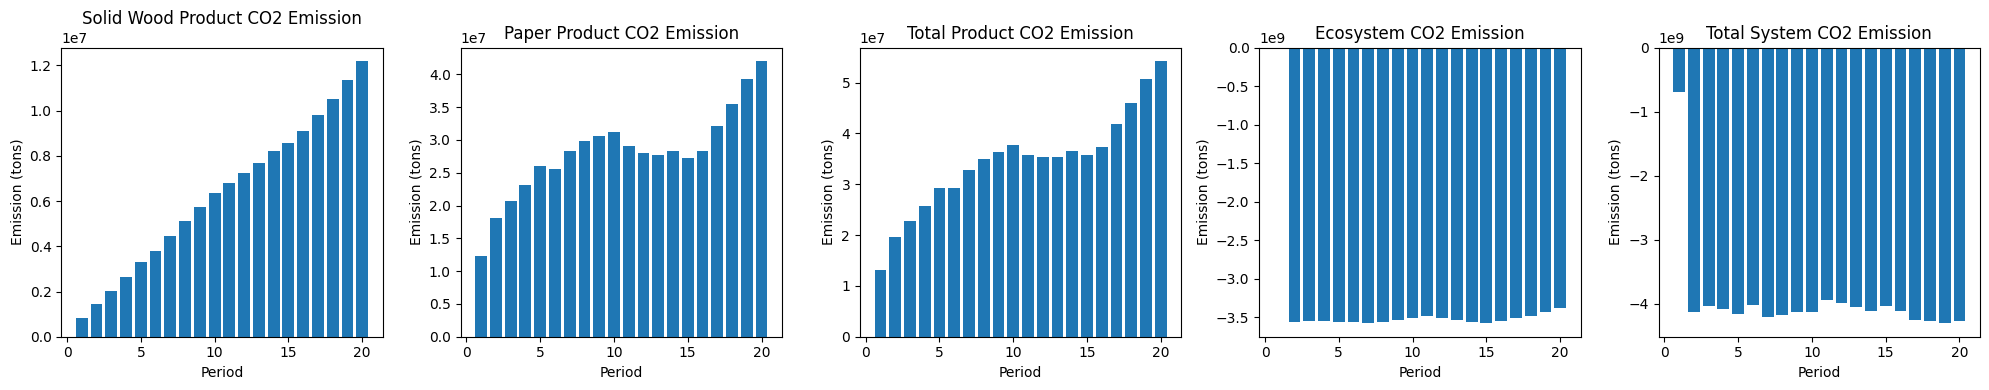

In [390]:
track_system_emission(fm)

running base scenario
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (linux64)

CPU model: Intel Xeon Processor (Skylake, IBRS), instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 16 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 810 rows, 45499 columns and 486195 nonzeros
Model fingerprint: 0xc00497b2
Coefficient statistics:
  Matrix range     [2e-01, 1e+05]
  Objective range  [7e+03, 1e+09]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+00]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 332 rows and 330 columns
Presolve time: 0.27s
Presolved: 478 rows, 45169 columns, 470823 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 1.669e+04
 Factor NZ  : 2.218e+04 (roughly 20 MB of memory)
 Factor Ops : 1.107e+06 (less than 1 second per iteration)

(<Figure size 1200x400 with 5 Axes>,
     period            oha           ohv           ogs           ocp  \
 0        1  159262.201258  4.508999e+07  6.963577e+08  1.371302e+09   
 1        2  151299.091195  3.796307e+07  7.149004e+08  1.374489e+09   
 2        3  151299.091195  4.002655e+07  7.406763e+08  1.387004e+09   
 3        4  151299.091195  3.459201e+07  7.827488e+08  1.406558e+09   
 4        5  151299.091195  2.962497e+07  8.371774e+08  1.430833e+09   
 5        6  151299.091195  4.269670e+07  8.784179e+08  1.455355e+09   
 6        7  151299.091195  4.163851e+07  9.141989e+08  1.475349e+09   
 7        8  151299.091195  4.243055e+07  9.388471e+08  1.490676e+09   
 8        9  151299.091195  3.963034e+07  9.556684e+08  1.502808e+09   
 9       10  151299.091195  3.325005e+07  9.733936e+08  1.511582e+09   
 10      11  151299.091195  3.305294e+07  9.944026e+08  1.523026e+09   
 11      12  151299.091195  3.877371e+07  1.010930e+09  1.533998e+09   
 12      13  151299.091195 

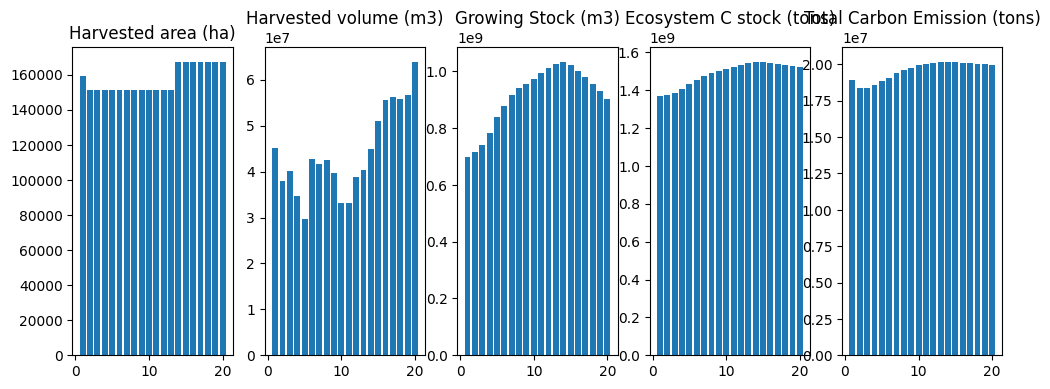

In [ ]:
# product_info = {
#     "solid_wood": (1, 30),  # proportion, half-life
#     "paper": (0, 2)
# }
# Displacement factor = 5
run_scenario(fm,'base')

running base scenario
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (linux64)

CPU model: Intel Xeon Processor (Skylake, IBRS), instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 16 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 810 rows, 45499 columns and 486195 nonzeros
Model fingerprint: 0x5de47e9a
Coefficient statistics:
  Matrix range     [2e-01, 1e+05]
  Objective range  [7e+03, 1e+09]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+00]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 332 rows and 330 columns
Presolve time: 0.21s
Presolved: 478 rows, 45169 columns, 470823 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 1.669e+04
 Factor NZ  : 2.218e+04 (roughly 20 MB of memory)
 Factor Ops : 1.107e+06 (less than 1 second per iteration)

(<Figure size 1200x400 with 5 Axes>,
     period            oha           ohv           ogs           ocp  \
 0        1  175136.008264  4.895802e+07  6.918071e+08  1.370691e+09   
 1        2  166379.207851  3.855842e+07  7.094676e+08  1.372508e+09   
 2        3  166379.207851  4.294179e+07  7.316331e+08  1.383526e+09   
 3        4  166379.207851  4.090314e+07  7.661340e+08  1.401067e+09   
 4        5  166379.207851  3.331859e+07  8.153792e+08  1.421237e+09   
 5        6  166379.207851  4.080023e+07  8.588583e+08  1.442478e+09   
 6        7  166379.207851  4.809625e+07  8.884820e+08  1.462538e+09   
 7        8  166379.207851  4.475344e+07  9.118919e+08  1.476414e+09   
 8        9  166379.207851  4.468730e+07  9.261088e+08  1.487329e+09   
 9       10  166379.207851  3.748418e+07  9.408896e+08  1.495143e+09   
 10      11  166379.207851  3.473436e+07  9.591518e+08  1.504586e+09   
 11      12  166379.207851  3.841258e+07  9.771643e+08  1.515375e+09   
 12      13  166379.207851 

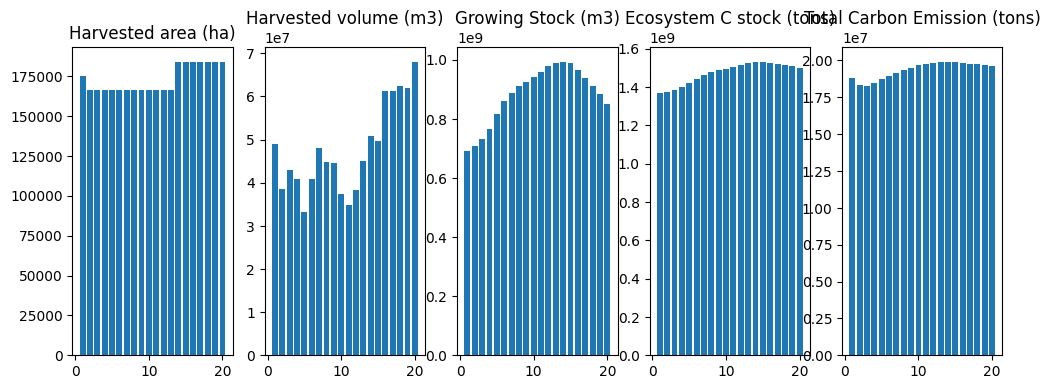

In [180]:
# product_info = {
#     "solid_wood": (1, 100),  # proportion, half-life
#     "paper": (0, 2)
# }
# Displacement factor = 5
run_scenario(fm,'base')

(<Figure size 2000x400 with 5 Axes>,
 array([<Axes: title={'center': 'Solid Wood Product C Stock'}, xlabel='Period', ylabel='Stock (tons)'>,
        <Axes: title={'center': 'Paper Product C Stock'}, xlabel='Period', ylabel='Stock (tons)'>,
        <Axes: title={'center': 'Total Product C Stock'}, xlabel='Period', ylabel='Stock (tons)'>,
        <Axes: title={'center': 'Ecosystem C Stock'}, xlabel='Period', ylabel='Stock (tons)'>,
        <Axes: title={'center': 'Total System C Stock'}, xlabel='Period', ylabel='Stock (tons)'>],
       dtype=object),
     period    solid_wood  paper   sum_product     ecosystem        system
 0        1  1.118229e+07    0.0  1.118229e+07  1.370691e+09  1.381873e+09
 1        2  1.991175e+07    0.0  1.991175e+07  1.372508e+09  1.392420e+09
 2        3  2.958189e+07    0.0  2.958189e+07  1.383526e+09  1.413107e+09
 3        4  3.871935e+07    0.0  3.871935e+07  1.401067e+09  1.439786e+09
 4        5  4.606113e+07    0.0  4.606113e+07  1.421237e+09  1.467298

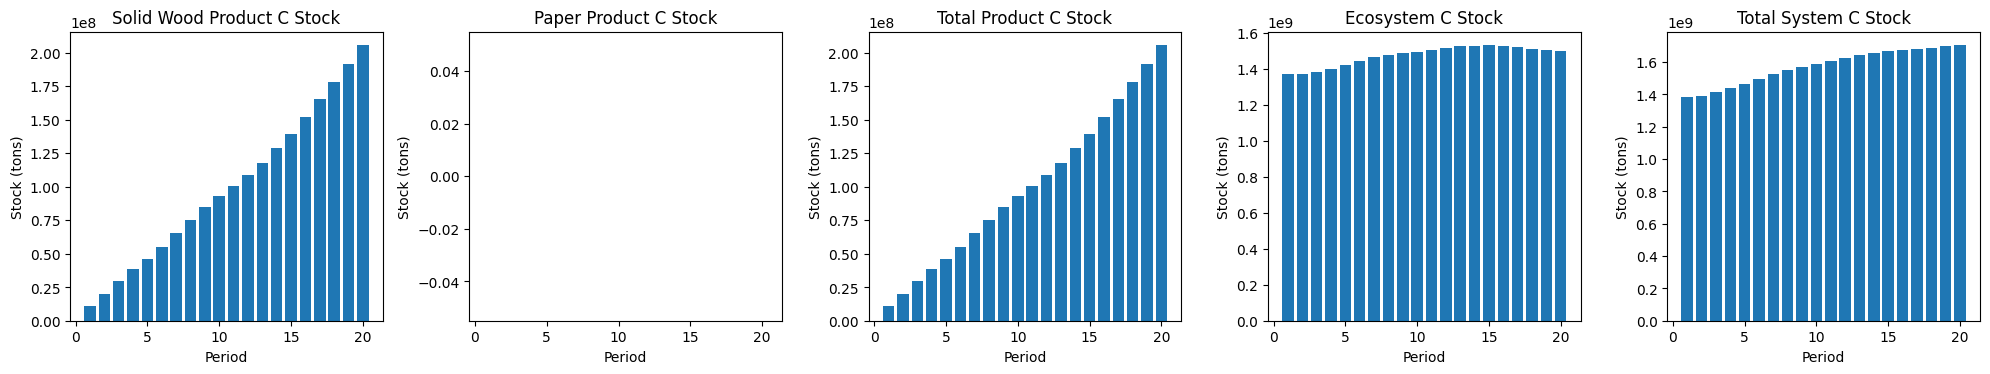

In [181]:
track_system_stock(fm)

(<Figure size 2000x400 with 5 Axes>,
 array([<Axes: title={'center': 'Solid Wood Product CO2 Emission'}, xlabel='Period', ylabel='Emission (tons)'>,
        <Axes: title={'center': 'Paper Product CO2 Emission'}, xlabel='Period', ylabel='Emission (tons)'>,
        <Axes: title={'center': 'Total Product CO2 Emission'}, xlabel='Period', ylabel='Emission (tons)'>,
        <Axes: title={'center': 'Ecosystem CO2 Emission'}, xlabel='Period', ylabel='Emission (tons)'>,
        <Axes: title={'center': 'Total System CO2 Emission'}, xlabel='Period', ylabel='Emission (tons)'>],
       dtype=object),
     period    solid_wood  paper   sum_product     ecosystem        system
 0        1  2.861861e+05    0.0  2.861861e+05  0.000000e+00 -2.061535e+08
 1        2  5.095973e+05    0.0  5.095973e+05 -3.661840e+09 -3.823919e+09
 2        3  7.570830e+05    0.0  7.570830e+05 -3.700419e+09 -3.880733e+09
 3        4  9.909364e+05    0.0  9.909364e+05 -3.753718e+09 -3.925202e+09
 4        5  1.178833e+06    0

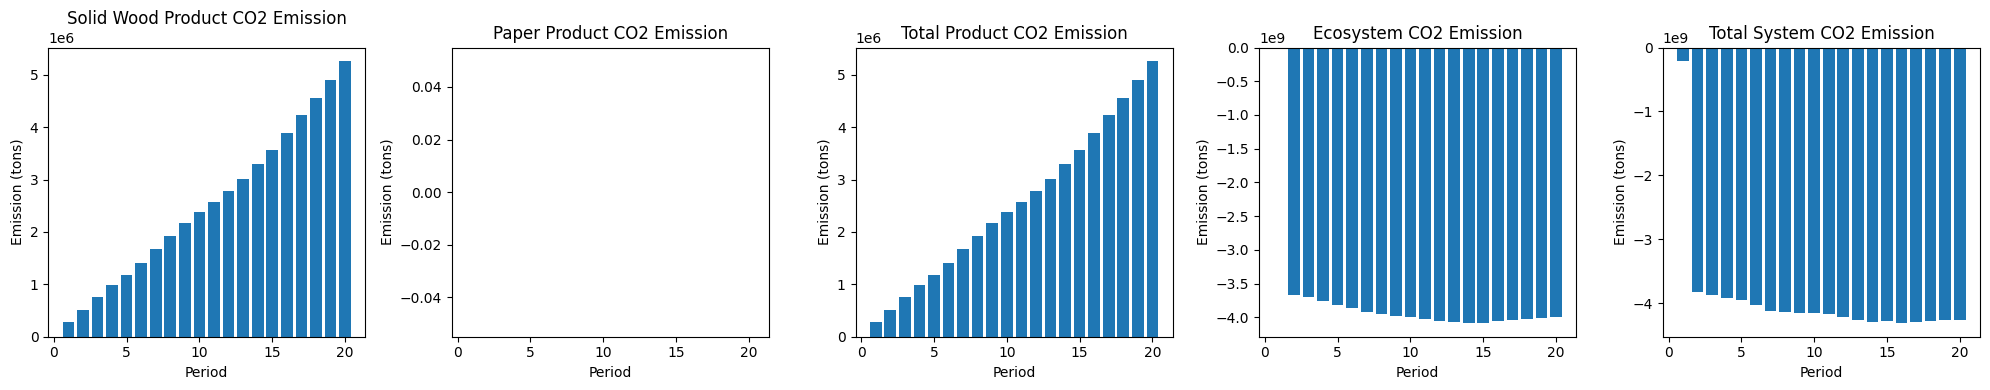

In [182]:
track_system_emission(fm)